In [94]:
import pandas as pd
import numpy as np
import seaborn as sns


np.random.seed(4)
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
# 解决中文显示乱码的问题
plt.rcParams['font.sans-serif']=['SimHei']    # 我这步没用  还是乱码！
 # 解决一些符号显示的问题
plt.rcParams['axes.unicode_minus']=False 
import statsmodels.api as sm
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# 一、获取原始数据
1、获取数据（1km的路段共437条，每条路段有四年的数据=1748），变量变成数字，而不是字符串

In [2]:
rawdata = pd.read_excel('/Users/yy/PycharmProjects/pythonProject/excel/明细数据.xlsx')
# 选取2019-2022年的数据
rawdata = rawdata[rawdata['检测时间'].isin(['2019年', '2020年', '2021年', '2022年'])]
rawdata = rawdata[
    ["个体编号", "路线编号", "起讫桩号", "起讫桩号(P)", "检测时间", "路面损坏状况指数PCI", "年平均交通量(辆)","年平均降水量(mm)", "年平均最低温(℃)", "年平均最高温(℃)", "年霜冻期(天)", "季节冻土层厚度(cm)","年平均日照时长(h)"]]
# 应该是连续性的变量的类型变成数字类型
var_list = ["年平均交通量(辆)", "路面损坏状况指数PCI", "年平均降水量(mm)", "年平均最低温(℃)", "年平均最高温(℃)", "年霜冻期(天)", "季节冻土层厚度(cm)", "年平均日照时长(h)"]
for var in var_list:
    rawdata[var] = pd.to_numeric(rawdata[var], errors='coerce')   
# 原始数据如下
rawdata

/Users/yy/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,个体编号,路线编号,起讫桩号,起讫桩号(P),检测时间,路面损坏状况指数PCI,年平均交通量(辆),年平均降水量(mm),年平均最低温(℃),年平均最高温(℃),年霜冻期(天),季节冻土层厚度(cm),年平均日照时长(h)
2,1,G109,1485~1491,1485~1486,2019年,91.83,10115.0,171.0,-14.0,34.0,150,54,7.6
3,1,G109,1485~1491,1485~1486,2020年,93.63,10219.0,163.0,-14.0,32.0,150,54,7.6
4,1,G109,1485~1491,1485~1486,2021年,90.52,16447.0,188.0,-19.0,35.0,150,54,7.6
5,1,G109,1485~1491,1485~1486,2022年,91.18,15070.0,192.4,-17.0,37.0,150,54,7.6
8,2,G109,1485~1491,1486~1487,2019年,93.94,10115.0,171.0,-14.0,34.0,150,54,7.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2615,436,G569,321~329,327~328,2022年,100.00,115520.0,113.1,-19.0,38.0,215,109,3189.3
2618,437,G569,321~329,328~329,2019年,78.44,NaN,127.0,-19.1,39.2,215,109,3189.3
2619,437,G569,321~329,328~329,2020年,70.32,NaN,80.5,-19.3,36.7,215,109,3189.3
2620,437,G569,321~329,328~329,2021年,69.28,139544.0,100.7,-24.3,37.7,215,109,3189.3


2、使得一条公路只有一条数据，也就是把四年的数据变成一条数据。总共437条1km的路段。

In [3]:
pivot_values = ["年平均交通量(辆)", "路面损坏状况指数PCI", "年平均降水量(mm)", "年平均最低温(℃)", "年平均最高温(℃)"]
# 数据透视表
trans_years = rawdata.pivot_table(
    index=['个体编号', '路线编号', '起讫桩号', '起讫桩号(P)', '年霜冻期(天)', '季节冻土层厚度(cm)','年平均日照时长(h)'], 
    columns='检测时间', 
    values=pivot_values).reset_index()
trans_years

个体编号  路线编号       起讫桩号    起讫桩号(P) 年霜冻期(天) 季节冻土层厚度(cm) 年平均日照时长(h)  \
检测时间                                                                   
0       1  G109  1485~1491  1485~1486     150          54        7.6   
1       2  G109  1485~1491  1486~1487     150          54        7.6   
2       3  G109  1485~1491  1487~1488     150          54        7.6   
3       4  G109  1485~1491  1488~1489     150          54        7.6   
4       5  G109  1485~1491  1489~1490     150          54        7.6   
..    ...   ...        ...        ...     ...         ...        ...   
432   433  G569    321~329    324~325     215         109     3189.3   
433   434  G569    321~329    325~326     215         109     3189.3   
434   435  G569    321~329    326~327     215         109     3189.3   
435   436  G569    321~329    327~328     215         109     3189.3   
436   437  G569    321~329    328~329     215         109     3189.3   

     年平均交通量(辆)                     ... 年平均最高温(℃)       年平均降水量(mm)         \
检测时间     2019年    2020年     2021年  ...     2021年 2022年      2019年  2020年   
0      10115.0  10219.0   16447.0  ...      35.0  37.0      171.0  163.0   
1      10115.0  10219.0   16447.0  ...      35.0  37.0      171.0  163.0   
2      10115.0  10219.0   16447.0  ...      35.0  37.0      171.0  163.0   
3      10115.0  10219.0   16447.0  ...      35.0  37.0      171.0  163.0   
4      10115.0  10219.0   16447.0  ...      35.0  37.0      171.0  163.0   
..         ...      ...       ...  ...       ...   ...        ...    ...   
432        NaN      NaN  139544.0  ...      37.7  38.0      127.0   80.5   
433        NaN      NaN  139544.0  ...      37.7  38.0      127.0   80.5   
434        NaN      NaN  139544.0  ...      37.7  38.0      127.0   80.5   
435        NaN      NaN  139544.0  ...      37.7  38.0      127.0   80.5   
436        NaN      NaN  139544.0  ...      37.7  38.0      127.0   80.5   

                   路面损坏状况指数PCI                        
检测时间  2021年  2022年       2019年  2020年  2021年   2022年  
0     188.0  192.4       91.83  93.63  90.52   91.18  
1     188.0  192.4       93.94  93.58  91.36   90.67  
2     188.0  192.4       90.74  92.02  88.53   89.61  
3     188.0  192.4       93.58  92.69  88.72   89.90  
4     188.0  192.4       93.94  91.65  89.62   90.44  
..      ...    ...         ...    ...    ...     ...  
432   100.7  113.1       79.40  72.32  69.28  100.00  
433   100.7  113.1       87.87  83.20  79.50  100.00  
434   100.7  113.1       86.00  79.69  73.36  100.00  
435   100.7  113.1       93.69  83.05  79.72  100.00  
436   100.7  113.1       78.44  70.32  69.28   83.30  

[437 rows x 27 columns]

3、把表格的行标签名字换得好看一点

In [4]:
# 可以获得透视表的行标签（数据透视表还是不懂），是个list列表，里面元素是元组
list(trans_years)

[('个体编号', ''),
 ('路线编号', ''),
 ('起讫桩号', ''),
 ('起讫桩号(P)', ''),
 ('年霜冻期(天)', ''),
 ('季节冻土层厚度(cm)', ''),
 ('年平均日照时长(h)', ''),
 ('年平均交通量(辆)', '2019年'),
 ('年平均交通量(辆)', '2020年'),
 ('年平均交通量(辆)', '2021年'),
 ('年平均交通量(辆)', '2022年'),
 ('年平均最低温(℃)', '2019年'),
 ('年平均最低温(℃)', '2020年'),
 ('年平均最低温(℃)', '2021年'),
 ('年平均最低温(℃)', '2022年'),
 ('年平均最高温(℃)', '2019年'),
 ('年平均最高温(℃)', '2020年'),
 ('年平均最高温(℃)', '2021年'),
 ('年平均最高温(℃)', '2022年'),
 ('年平均降水量(mm)', '2019年'),
 ('年平均降水量(mm)', '2020年'),
 ('年平均降水量(mm)', '2021年'),
 ('年平均降水量(mm)', '2022年'),
 ('路面损坏状况指数PCI', '2019年'),
 ('路面损坏状况指数PCI', '2020年'),
 ('路面损坏状况指数PCI', '2021年'),
 ('路面损坏状况指数PCI', '2022年')]

In [5]:
# 行标签重新起个名字，年份带上
rename_list = list(
    map(lambda name_set: name_set[0] + '_' + name_set[1] if name_set[1] != '' else name_set[0], list(trans_years))
)
# 数据表的行标签换成新的
trans_years.columns = rename_list
trans_years

,个体编号,路线编号,起讫桩号,起讫桩号(P),年霜冻期(天),季节冻土层厚度(cm),年平均日照时长(h),年平均交通量(辆)_2019年,年平均交通量(辆)_2020年,年平均交通量(辆)_2021年,...,年平均最高温(℃)_2021年,年平均最高温(℃)_2022年,年平均降水量(mm)_2019年,年平均降水量(mm)_2020年,年平均降水量(mm)_2021年,年平均降水量(mm)_2022年,路面损坏状况指数PCI_2019年,路面损坏状况指数PCI_2020年,路面损坏状况指数PCI_2021年,路面损坏状况指数PCI_2022年
0,1,G109,1485~1491,1485~1486,150,54,7.6,10115.0,10219.0,16447.0,...,35.0,37.0,171.0,163.0,188.0,192.4,91.83,93.63,90.52,91.18
1,2,G109,1485~1491,1486~1487,150,54,7.6,10115.0,10219.0,16447.0,...,35.0,37.0,171.0,163.0,188.0,192.4,93.94,93.58,91.36,90.67
2,3,G109,1485~1491,1487~1488,150,54,7.6,10115.0,10219.0,16447.0,...,35.0,37.0,171.0,163.0,188.0,192.4,90.74,92.02,88.53,89.61
3,4,G109,1485~1491,1488~1489,150,54,7.6,10115.0,10219.0,16447.0,...,35.0,37.0,171.0,163.0,188.0,192.4,93.58,92.69,88.72,89.90
4,5,G109,1485~1491,1489~1490,150,54,7.6,10115.0,10219.0,16447.0,...,35.0,37.0,171.0,163.0,188.0,192.4,93.94,91.65,89.62,90.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,433,G569,321~329,324~325,215,109,3189.3,NaN,NaN,139544.0,...,37.7,38.0,127.0,80.5,100.7,113.1,79.40,72.32,69.28,100.00
433,434,G569,321~329,325~326,215,109,3189.3,NaN,NaN,139544.0,...,37.7,38.0,127.0,80.5,100.7,113.1,87.87,83.20,79.50,100.00
434,435,G569,321~329,326~327,215,109,3189.3,NaN,NaN,139544.0,...,37.7,38.0,127.0,80.5,100.7,113.1,86.00,79.69,73.36,100.00
435,436,G569,321~329,327~328,215,109,3189.3,NaN,NaN,139544.0,...,37.7,38.0,127.0,80.5,100.7,113.1,93.69,83.05,79.72,100.00


In [6]:
rename_list

['个体编号',
 '路线编号',
 '起讫桩号',
 '起讫桩号(P)',
 '年霜冻期(天)',
 '季节冻土层厚度(cm)',
 '年平均日照时长(h)',
 '年平均交通量(辆)_2019年',
 '年平均交通量(辆)_2020年',
 '年平均交通量(辆)_2021年',
 '年平均交通量(辆)_2022年',
 '年平均最低温(℃)_2019年',
 '年平均最低温(℃)_2020年',
 '年平均最低温(℃)_2021年',
 '年平均最低温(℃)_2022年',
 '年平均最高温(℃)_2019年',
 '年平均最高温(℃)_2020年',
 '年平均最高温(℃)_2021年',
 '年平均最高温(℃)_2022年',
 '年平均降水量(mm)_2019年',
 '年平均降水量(mm)_2020年',
 '年平均降水量(mm)_2021年',
 '年平均降水量(mm)_2022年',
 '路面损坏状况指数PCI_2019年',
 '路面损坏状况指数PCI_2020年',
 '路面损坏状况指数PCI_2021年',
 '路面损坏状况指数PCI_2022年']

# 二、异常值处理
## 1、PCI异常
1、PCI数据特征：仅有19年和22年的PCI有缺失, 且不存在同时缺失的状况
2、只选出PCI逐年递减的路段，那么从437条公路变成146条公路

In [7]:
# 筛选符合PCI值随时间衰减规律的数据行
filtered_df = trans_years[
    ((trans_years['路面损坏状况指数PCI_2019年'] != '') & (trans_years['路面损坏状况指数PCI_2022年'] != '') &
     (trans_years['路面损坏状况指数PCI_2019年'] > trans_years['路面损坏状况指数PCI_2020年']) &
     (trans_years['路面损坏状况指数PCI_2020年'] > trans_years['路面损坏状况指数PCI_2021年']) &
     (trans_years['路面损坏状况指数PCI_2021年'] > trans_years['路面损坏状况指数PCI_2022年']))
    |
    ((trans_years['路面损坏状况指数PCI_2019年'] == '') &
     (trans_years['路面损坏状况指数PCI_2020年'] > trans_years['路面损坏状况指数PCI_2021年']) &
     (trans_years['路面损坏状况指数PCI_2021年'] > trans_years['路面损坏状况指数PCI_2022年']))
    |
    ((trans_years['路面损坏状况指数PCI_2022年'] == '') &
     (trans_years['路面损坏状况指数PCI_2019年'] > trans_years['路面损坏状况指数PCI_2020年']) &
     (trans_years['路面损坏状况指数PCI_2020年'] > trans_years['路面损坏状况指数PCI_2021年']))
    ]
filtered_df.to_excel('/Users/yy/PycharmProjects/pythonProject/excel/temp.xlsx')
filtered_df

,个体编号,路线编号,起讫桩号,起讫桩号(P),年霜冻期(天),季节冻土层厚度(cm),年平均日照时长(h),年平均交通量(辆)_2019年,年平均交通量(辆)_2020年,年平均交通量(辆)_2021年,...,年平均最高温(℃)_2021年,年平均最高温(℃)_2022年,年平均降水量(mm)_2019年,年平均降水量(mm)_2020年,年平均降水量(mm)_2021年,年平均降水量(mm)_2022年,路面损坏状况指数PCI_2019年,路面损坏状况指数PCI_2020年,路面损坏状况指数PCI_2021年,路面损坏状况指数PCI_2022年
1,2,G109,1485~1491,1486~1487,150,54,7.6,10115.0,10219.0,16447.0,...,35.0,37.0,171.0,163.0,188.0,192.4,93.94,93.58,91.36,90.67
10,11,G109,1635~1640,1639~1640,182,75,2446.0,3385.0,3213.0,3472.0,...,38.0,38.0,258.0,263.0,266.0,266.0,91.20,89.50,83.90,78.74
12,13,G109,1650.508~1657,1652~1653,182,75,2446.0,3385.0,2926.0,3064.0,...,38.0,38.0,258.0,263.0,266.0,266.0,94.20,90.60,87.02,85.19
13,14,G109,1650.508~1657,1653~1654,182,75,2446.0,3385.0,2926.0,3064.0,...,38.0,38.0,258.0,263.0,266.0,266.0,93.96,92.84,88.41,85.88
14,15,G109,1650.508~1657,1654~1655,182,75,2446.0,3385.0,2926.0,3064.0,...,38.0,38.0,258.0,263.0,266.0,266.0,92.58,90.36,87.00,81.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,402,G568,230~238,230~231,309,150,2296.0,8091.0,8102.0,8273.0,...,30.0,32.0,505.0,508.0,516.0,510.0,92.70,85.42,84.28,79.84
402,403,G568,230~238,231~232,309,150,2296.0,8091.0,8102.0,8273.0,...,30.0,32.0,505.0,508.0,516.0,510.0,91.63,87.24,84.98,78.44
404,405,G568,230~238,233~234,309,150,2296.0,8091.0,8102.0,8273.0,...,30.0,32.0,505.0,508.0,516.0,510.0,92.90,89.59,83.16,82.76
405,406,G568,230~238,234~235,309,150,2296.0,8091.0,8102.0,8273.0,...,30.0,32.0,505.0,508.0,516.0,510.0,91.63,90.26,87.14,81.21


## 2、交通量缺失、异常+日照异常
交通量缺失：均值填补
交通量异常值：又把21年是130840的删掉了
日照异常：有一个极小值

In [8]:
# filtered_df['fill_mean_19'] = filtered_df[['年平均交通量(辆)_2020年', '年平均交通量(辆)_2021年', '年平均交通量(辆)_2022年']].mean(axis=1)
# filtered_df['fill_mean_19']

In [9]:
# 对2019年的交通量数据进行均值填补
filtered_df['fill_mean_19'] = filtered_df[['年平均交通量(辆)_2020年', '年平均交通量(辆)_2021年', '年平均交通量(辆)_2022年']].mean(axis=1)
filtered_df['年平均交通量(辆)_2019年'] = filtered_df['年平均交通量(辆)_2019年'].fillna(filtered_df['fill_mean_19'])
# 对2020年的交通量数据进行均值填补
filtered_df['fill_mean_20'] = filtered_df[
    ['年平均交通量(辆)_2019年', '年平均交通量(辆)_2021年', '年平均交通量(辆)_2022年']].mean(axis=1)
filtered_df['年平均交通量(辆)_2020年'] = filtered_df['年平均交通量(辆)_2020年'].fillna(filtered_df['fill_mean_20'])
filtered_df

,个体编号,路线编号,起讫桩号,起讫桩号(P),年霜冻期(天),季节冻土层厚度(cm),年平均日照时长(h),年平均交通量(辆)_2019年,年平均交通量(辆)_2020年,年平均交通量(辆)_2021年,...,年平均降水量(mm)_2019年,年平均降水量(mm)_2020年,年平均降水量(mm)_2021年,年平均降水量(mm)_2022年,路面损坏状况指数PCI_2019年,路面损坏状况指数PCI_2020年,路面损坏状况指数PCI_2021年,路面损坏状况指数PCI_2022年,fill_mean_19,fill_mean_20
1,2,G109,1485~1491,1486~1487,150,54,7.6,10115.0,10219.0,16447.0,...,171.0,163.0,188.0,192.4,93.94,93.58,91.36,90.67,13912.000000,13877.333333
10,11,G109,1635~1640,1639~1640,182,75,2446.0,3385.0,3213.0,3472.0,...,258.0,263.0,266.0,266.0,91.20,89.50,83.90,78.74,3008.666667,3066.000000
12,13,G109,1650.508~1657,1652~1653,182,75,2446.0,3385.0,2926.0,3064.0,...,258.0,263.0,266.0,266.0,94.20,90.60,87.02,85.19,2777.000000,2930.000000
13,14,G109,1650.508~1657,1653~1654,182,75,2446.0,3385.0,2926.0,3064.0,...,258.0,263.0,266.0,266.0,93.96,92.84,88.41,85.88,2777.000000,2930.000000
14,15,G109,1650.508~1657,1654~1655,182,75,2446.0,3385.0,2926.0,3064.0,...,258.0,263.0,266.0,266.0,92.58,90.36,87.00,81.26,2777.000000,2930.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,402,G568,230~238,230~231,309,150,2296.0,8091.0,8102.0,8273.0,...,505.0,508.0,516.0,510.0,92.70,85.42,84.28,79.84,8289.333333,8285.666667
402,403,G568,230~238,231~232,309,150,2296.0,8091.0,8102.0,8273.0,...,505.0,508.0,516.0,510.0,91.63,87.24,84.98,78.44,8289.333333,8285.666667
404,405,G568,230~238,233~234,309,150,2296.0,8091.0,8102.0,8273.0,...,505.0,508.0,516.0,510.0,92.90,89.59,83.16,82.76,8289.333333,8285.666667
405,406,G568,230~238,234~235,309,150,2296.0,8091.0,8102.0,8273.0,...,505.0,508.0,516.0,510.0,91.63,90.26,87.14,81.21,8289.333333,8285.666667


In [10]:
# 填补完毕删去此过程产生的列数据
filtered_df = filtered_df.drop(['fill_mean_19', 'fill_mean_20'], axis=1)
# 将交通量异常值删去, 交通量超过10万的路段G312 2374~2380.745共7个检测路段, 且仅收集到该路段21年和22年的交通量
filtered_df = filtered_df.drop(filtered_df[filtered_df['年平均交通量(辆)_2021年'] > 100000].index)
# filtered_df.to_excel('excel/temp.xlsx')
# 将日照时长异常值删去
filtered_df = filtered_df.drop(filtered_df[filtered_df['年平均日照时长(h)'] < 10].index)
filtered_df.to_excel('/Users/yy/PycharmProjects/pythonProject/excel/temp.xlsx')
filtered_df

,个体编号,路线编号,起讫桩号,起讫桩号(P),年霜冻期(天),季节冻土层厚度(cm),年平均日照时长(h),年平均交通量(辆)_2019年,年平均交通量(辆)_2020年,年平均交通量(辆)_2021年,...,年平均最高温(℃)_2021年,年平均最高温(℃)_2022年,年平均降水量(mm)_2019年,年平均降水量(mm)_2020年,年平均降水量(mm)_2021年,年平均降水量(mm)_2022年,路面损坏状况指数PCI_2019年,路面损坏状况指数PCI_2020年,路面损坏状况指数PCI_2021年,路面损坏状况指数PCI_2022年
10,11,G109,1635~1640,1639~1640,182,75,2446.0,3385.0,3213.0,3472.0,...,38.0,38.0,258.0,263.0,266.0,266.0,91.20,89.50,83.90,78.74
12,13,G109,1650.508~1657,1652~1653,182,75,2446.0,3385.0,2926.0,3064.0,...,38.0,38.0,258.0,263.0,266.0,266.0,94.20,90.60,87.02,85.19
13,14,G109,1650.508~1657,1653~1654,182,75,2446.0,3385.0,2926.0,3064.0,...,38.0,38.0,258.0,263.0,266.0,266.0,93.96,92.84,88.41,85.88
14,15,G109,1650.508~1657,1654~1655,182,75,2446.0,3385.0,2926.0,3064.0,...,38.0,38.0,258.0,263.0,266.0,266.0,92.58,90.36,87.00,81.26
15,16,G109,1650.508~1657,1655~1656,182,75,2446.0,3385.0,2926.0,3064.0,...,38.0,38.0,258.0,263.0,266.0,266.0,91.60,90.12,86.40,82.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,402,G568,230~238,230~231,309,150,2296.0,8091.0,8102.0,8273.0,...,30.0,32.0,505.0,508.0,516.0,510.0,92.70,85.42,84.28,79.84
402,403,G568,230~238,231~232,309,150,2296.0,8091.0,8102.0,8273.0,...,30.0,32.0,505.0,508.0,516.0,510.0,91.63,87.24,84.98,78.44
404,405,G568,230~238,233~234,309,150,2296.0,8091.0,8102.0,8273.0,...,30.0,32.0,505.0,508.0,516.0,510.0,92.90,89.59,83.16,82.76
405,406,G568,230~238,234~235,309,150,2296.0,8091.0,8102.0,8273.0,...,30.0,32.0,505.0,508.0,516.0,510.0,91.63,90.26,87.14,81.21


## 3、再来看看有没有异常值--相比师弟我新加的
年霜冻期(天),年平均日照时长(h),仍然有异常值，但却符合逻辑呀（探讨！！）
效果不好可以把异常值全删掉再试试

In [ ]:
# 要查看异常值的变量
ll=['年霜冻期(天)',
 '季节冻土层厚度(cm)',
 '年平均日照时长(h)',
 '年平均交通量(辆)_2019年',
 '年平均交通量(辆)_2020年',
 '年平均交通量(辆)_2021年',
 '年平均交通量(辆)_2022年',
 '年平均最低温(℃)_2019年',
 '年平均最低温(℃)_2020年',
 '年平均最低温(℃)_2021年',
 '年平均最低温(℃)_2022年',
 '年平均最高温(℃)_2019年',
 '年平均最高温(℃)_2020年',
 '年平均最高温(℃)_2021年',
 '年平均最高温(℃)_2022年',
 '年平均降水量(mm)_2019年',
 '年平均降水量(mm)_2020年',
 '年平均降水量(mm)_2021年',
 '年平均降水量(mm)_2022年',
 '路面损坏状况指数PCI_2019年',
 '路面损坏状况指数PCI_2020年',
 '路面损坏状况指数PCI_2021年',
 '路面损坏状况指数PCI_2022年']

IndexError: list index out of range

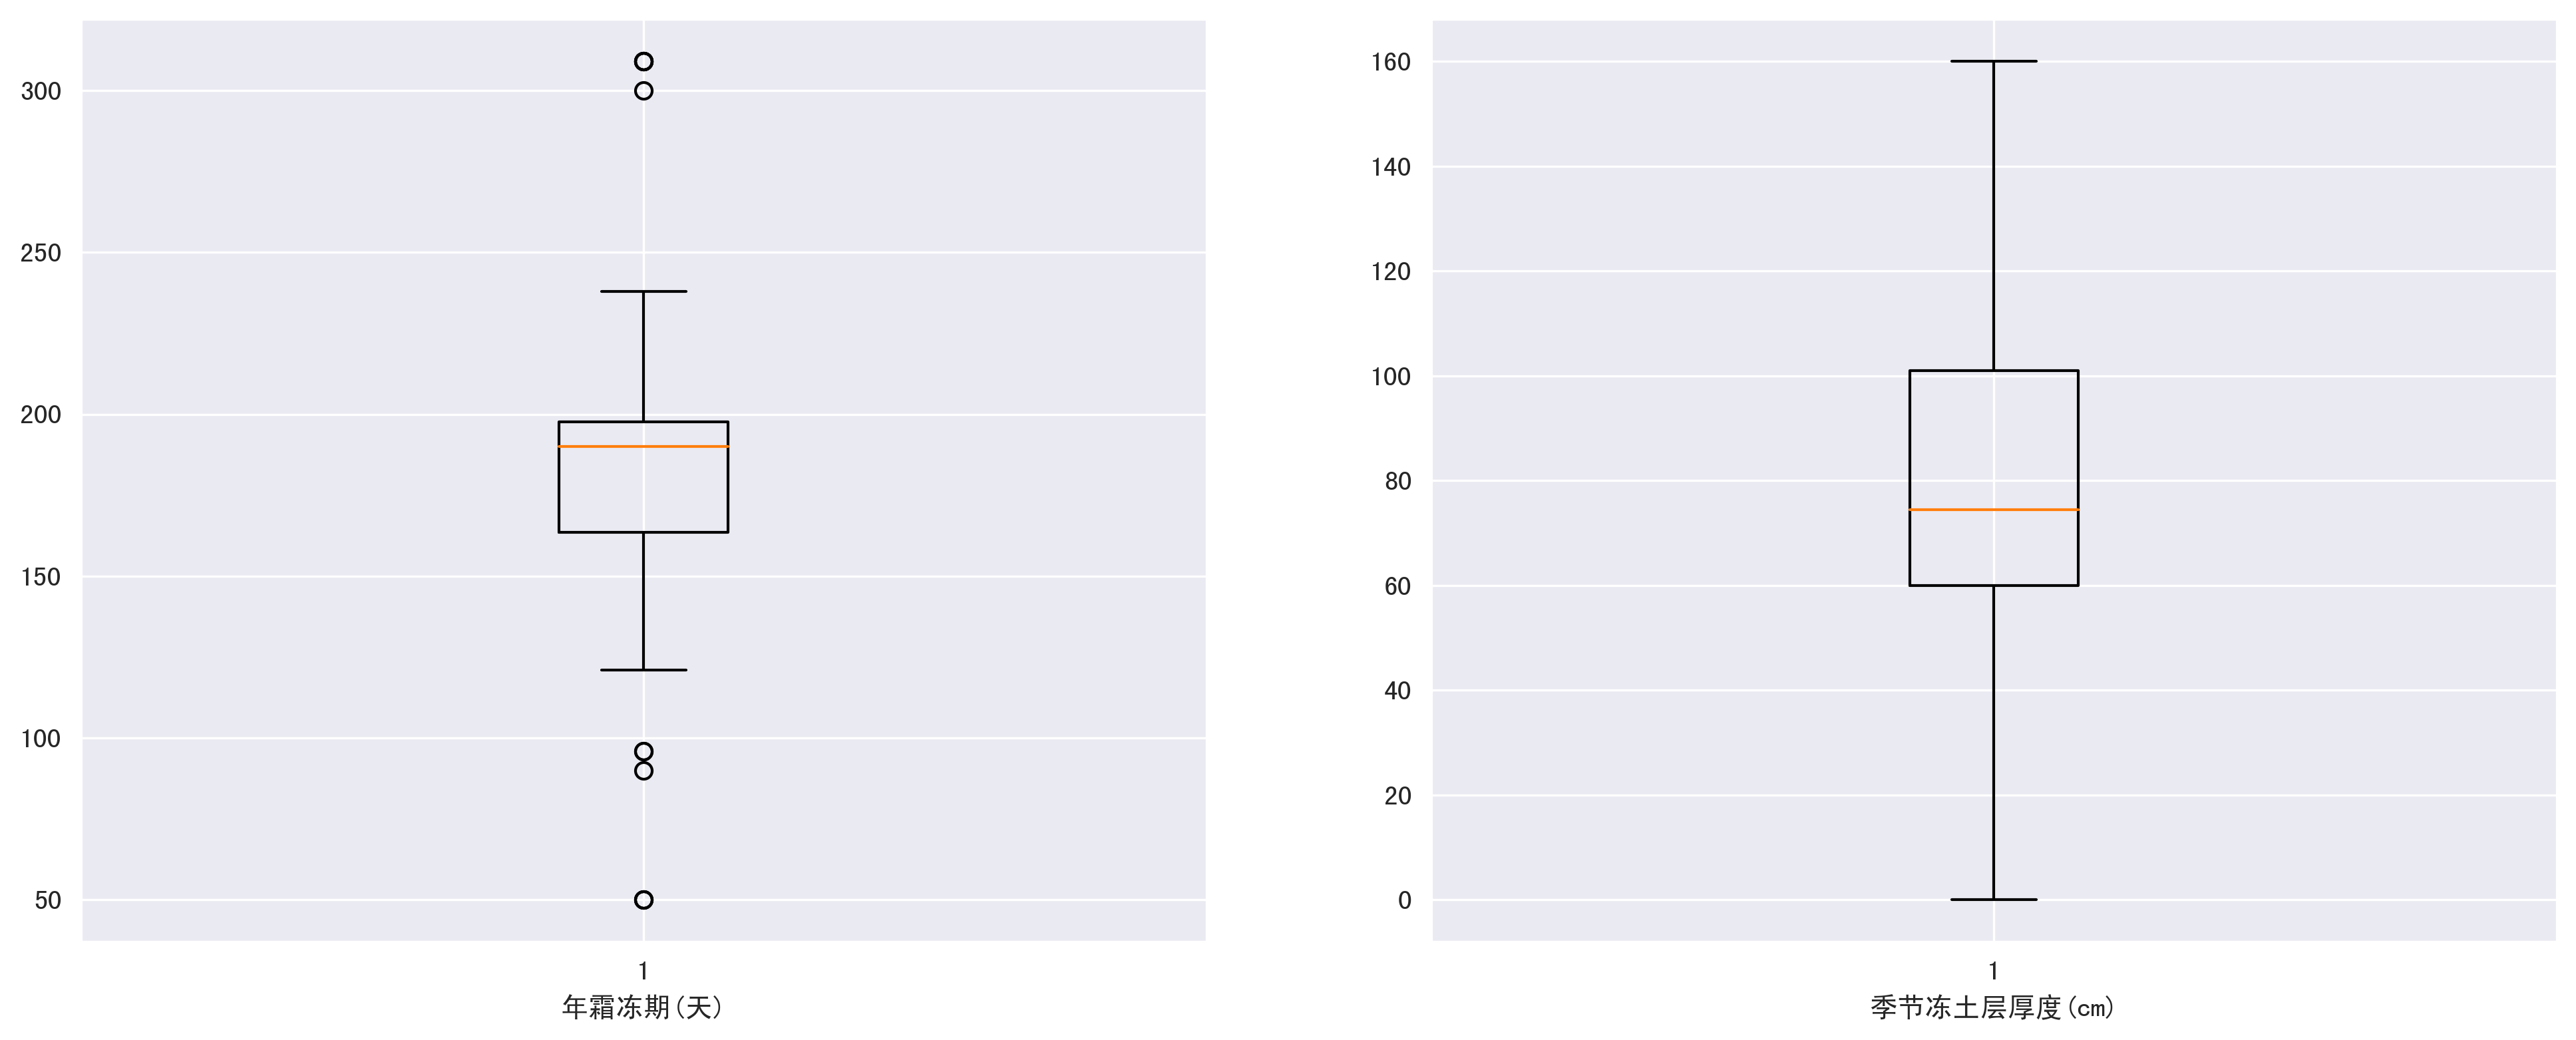

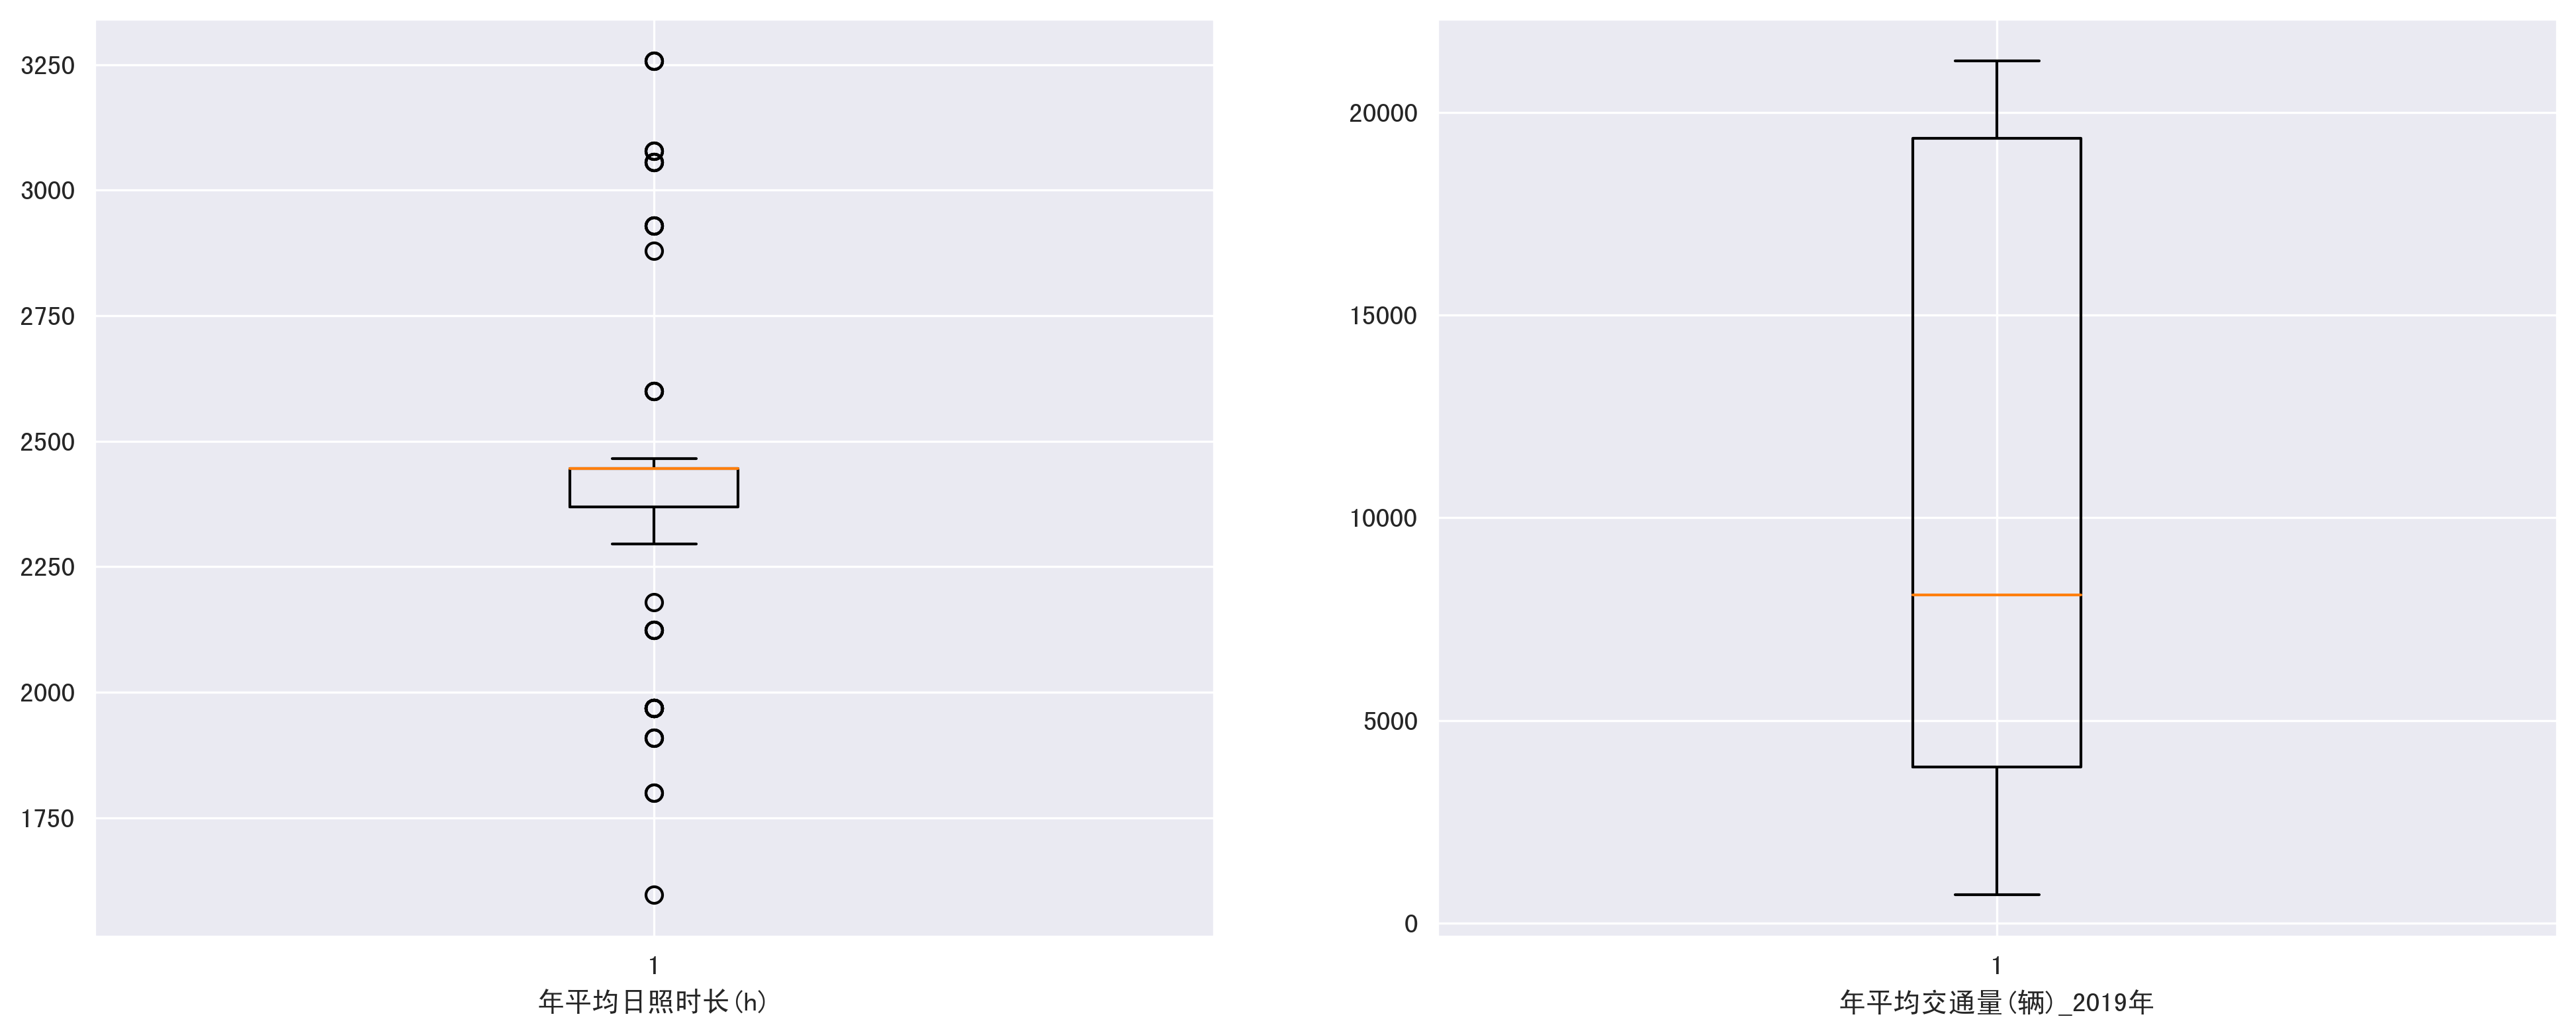

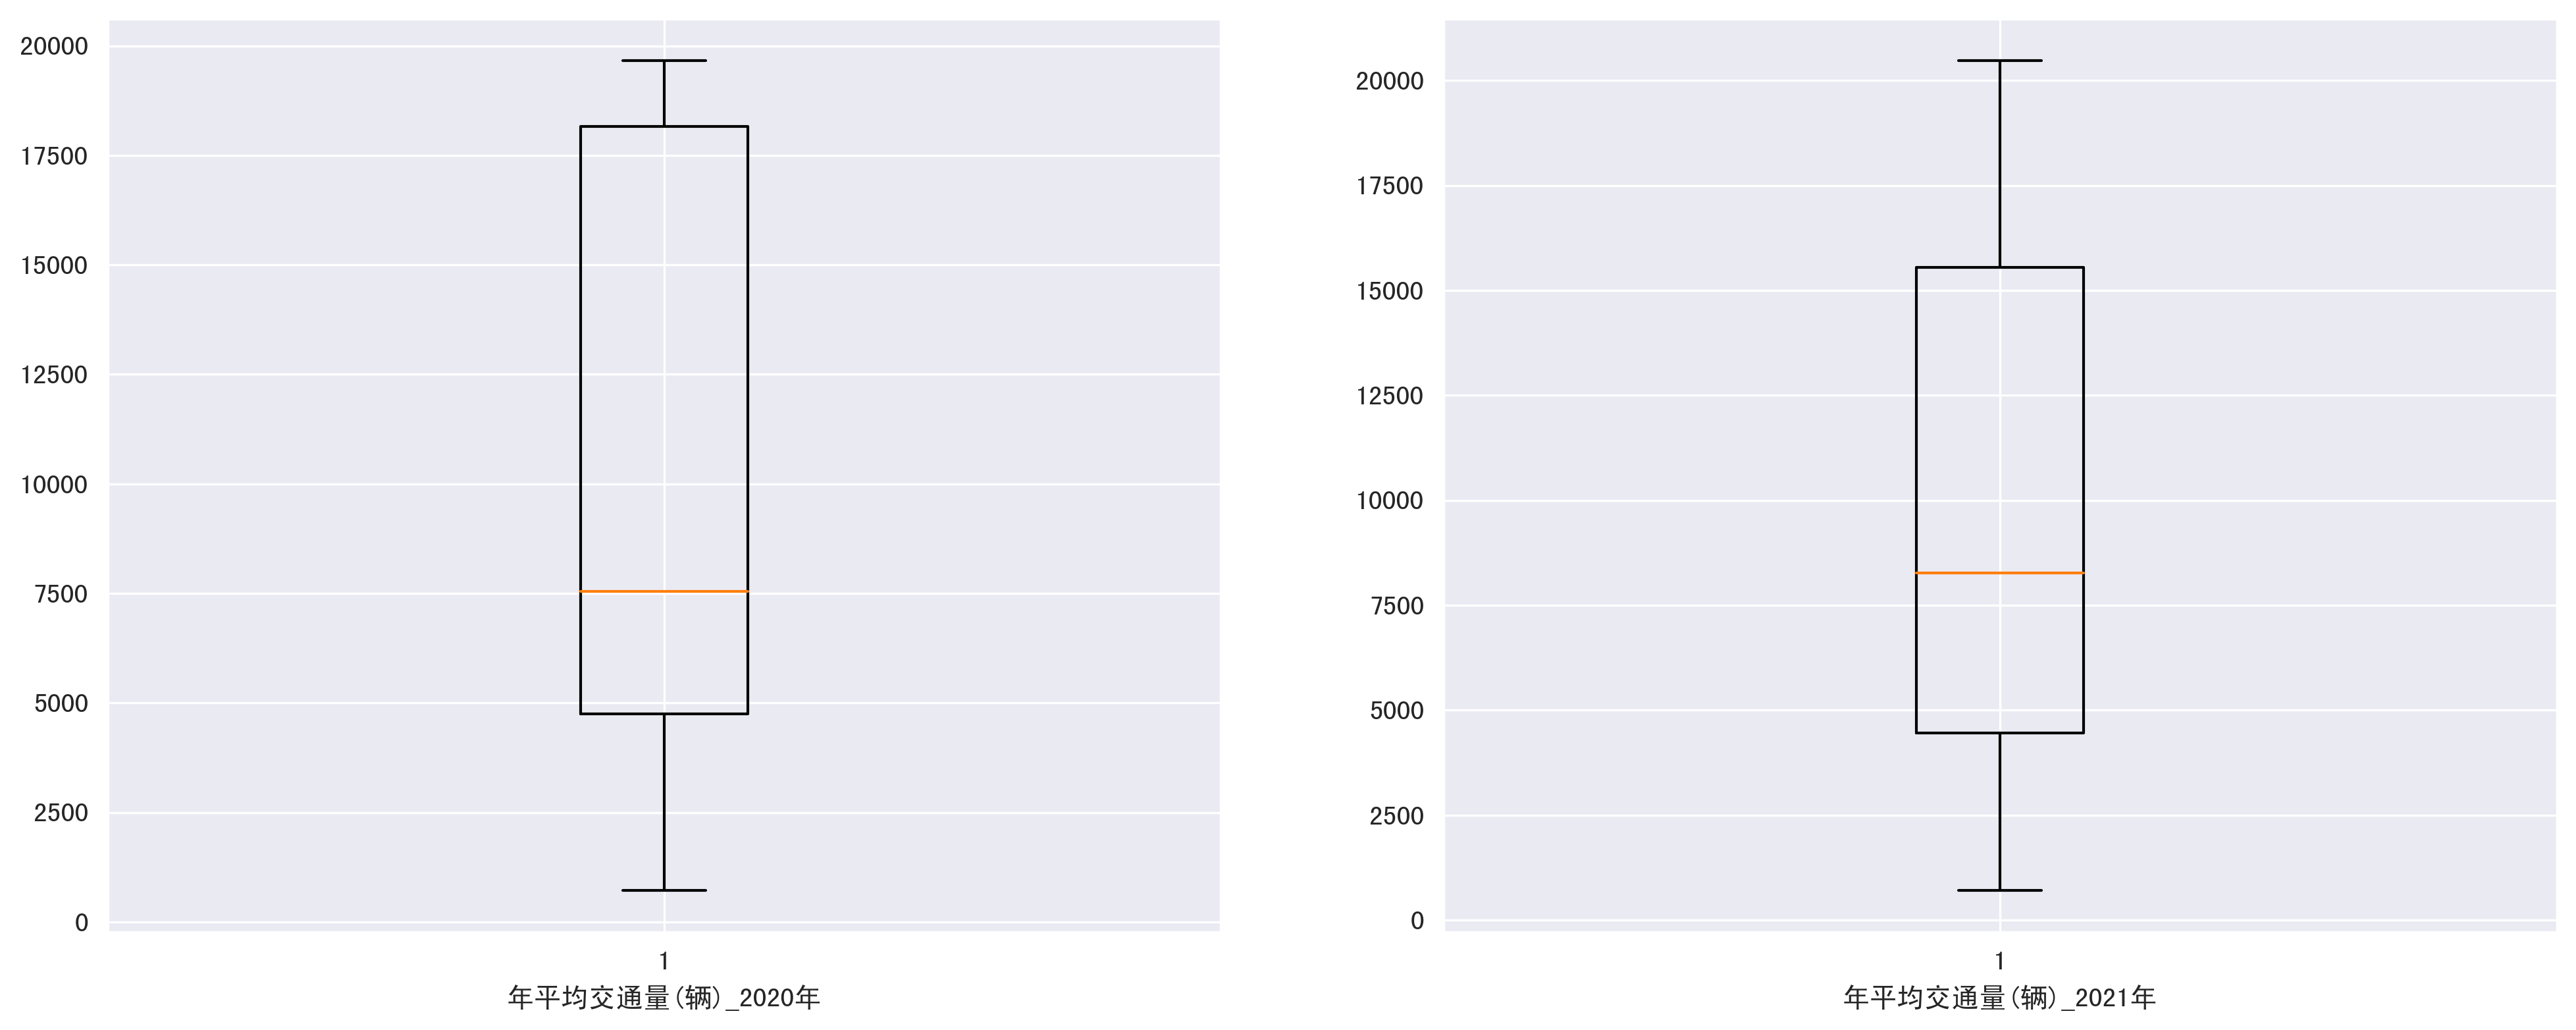

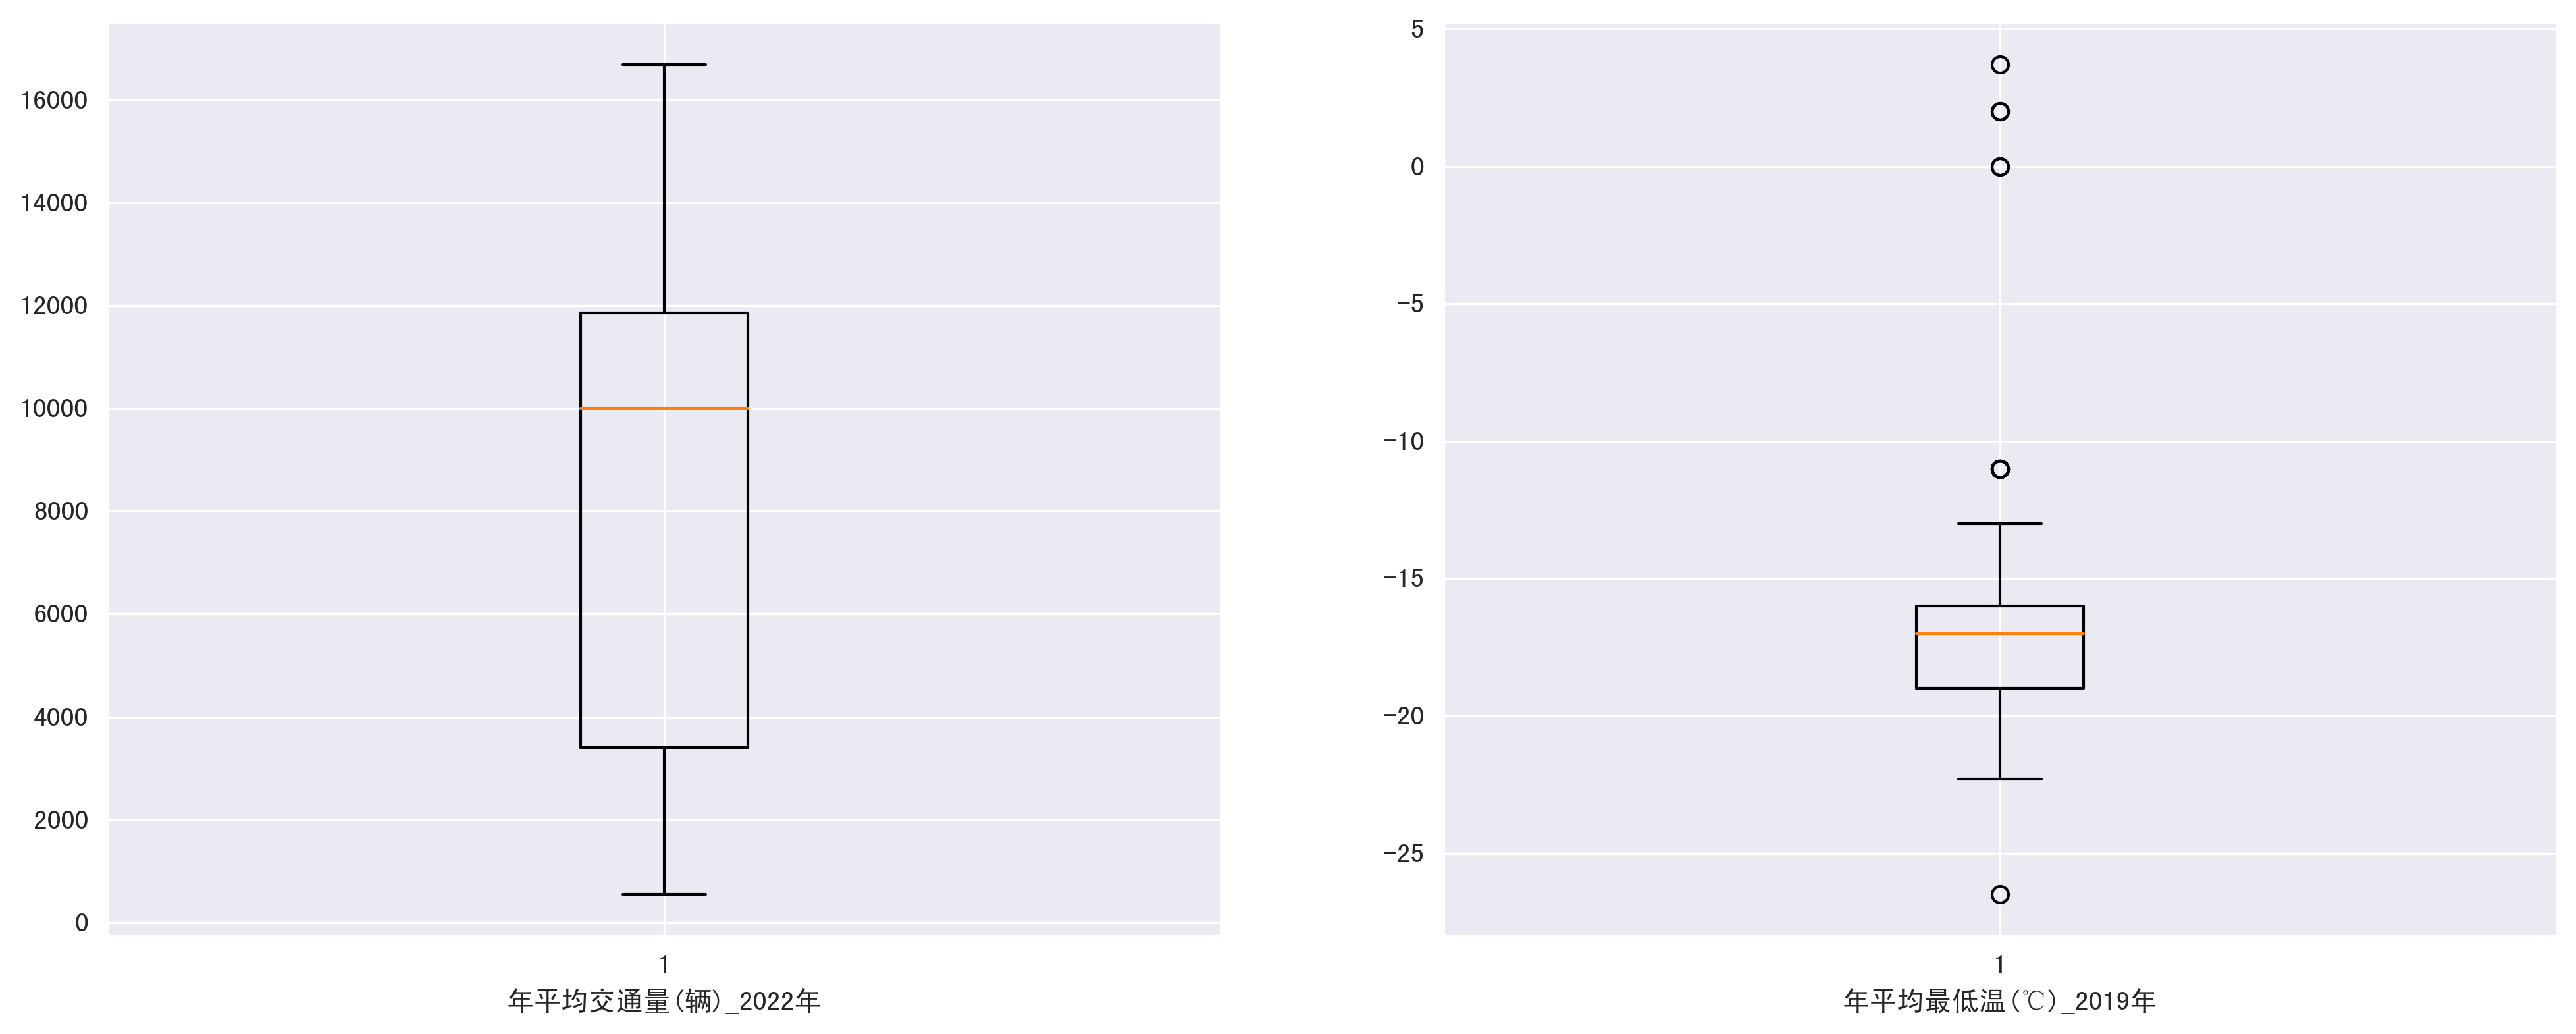

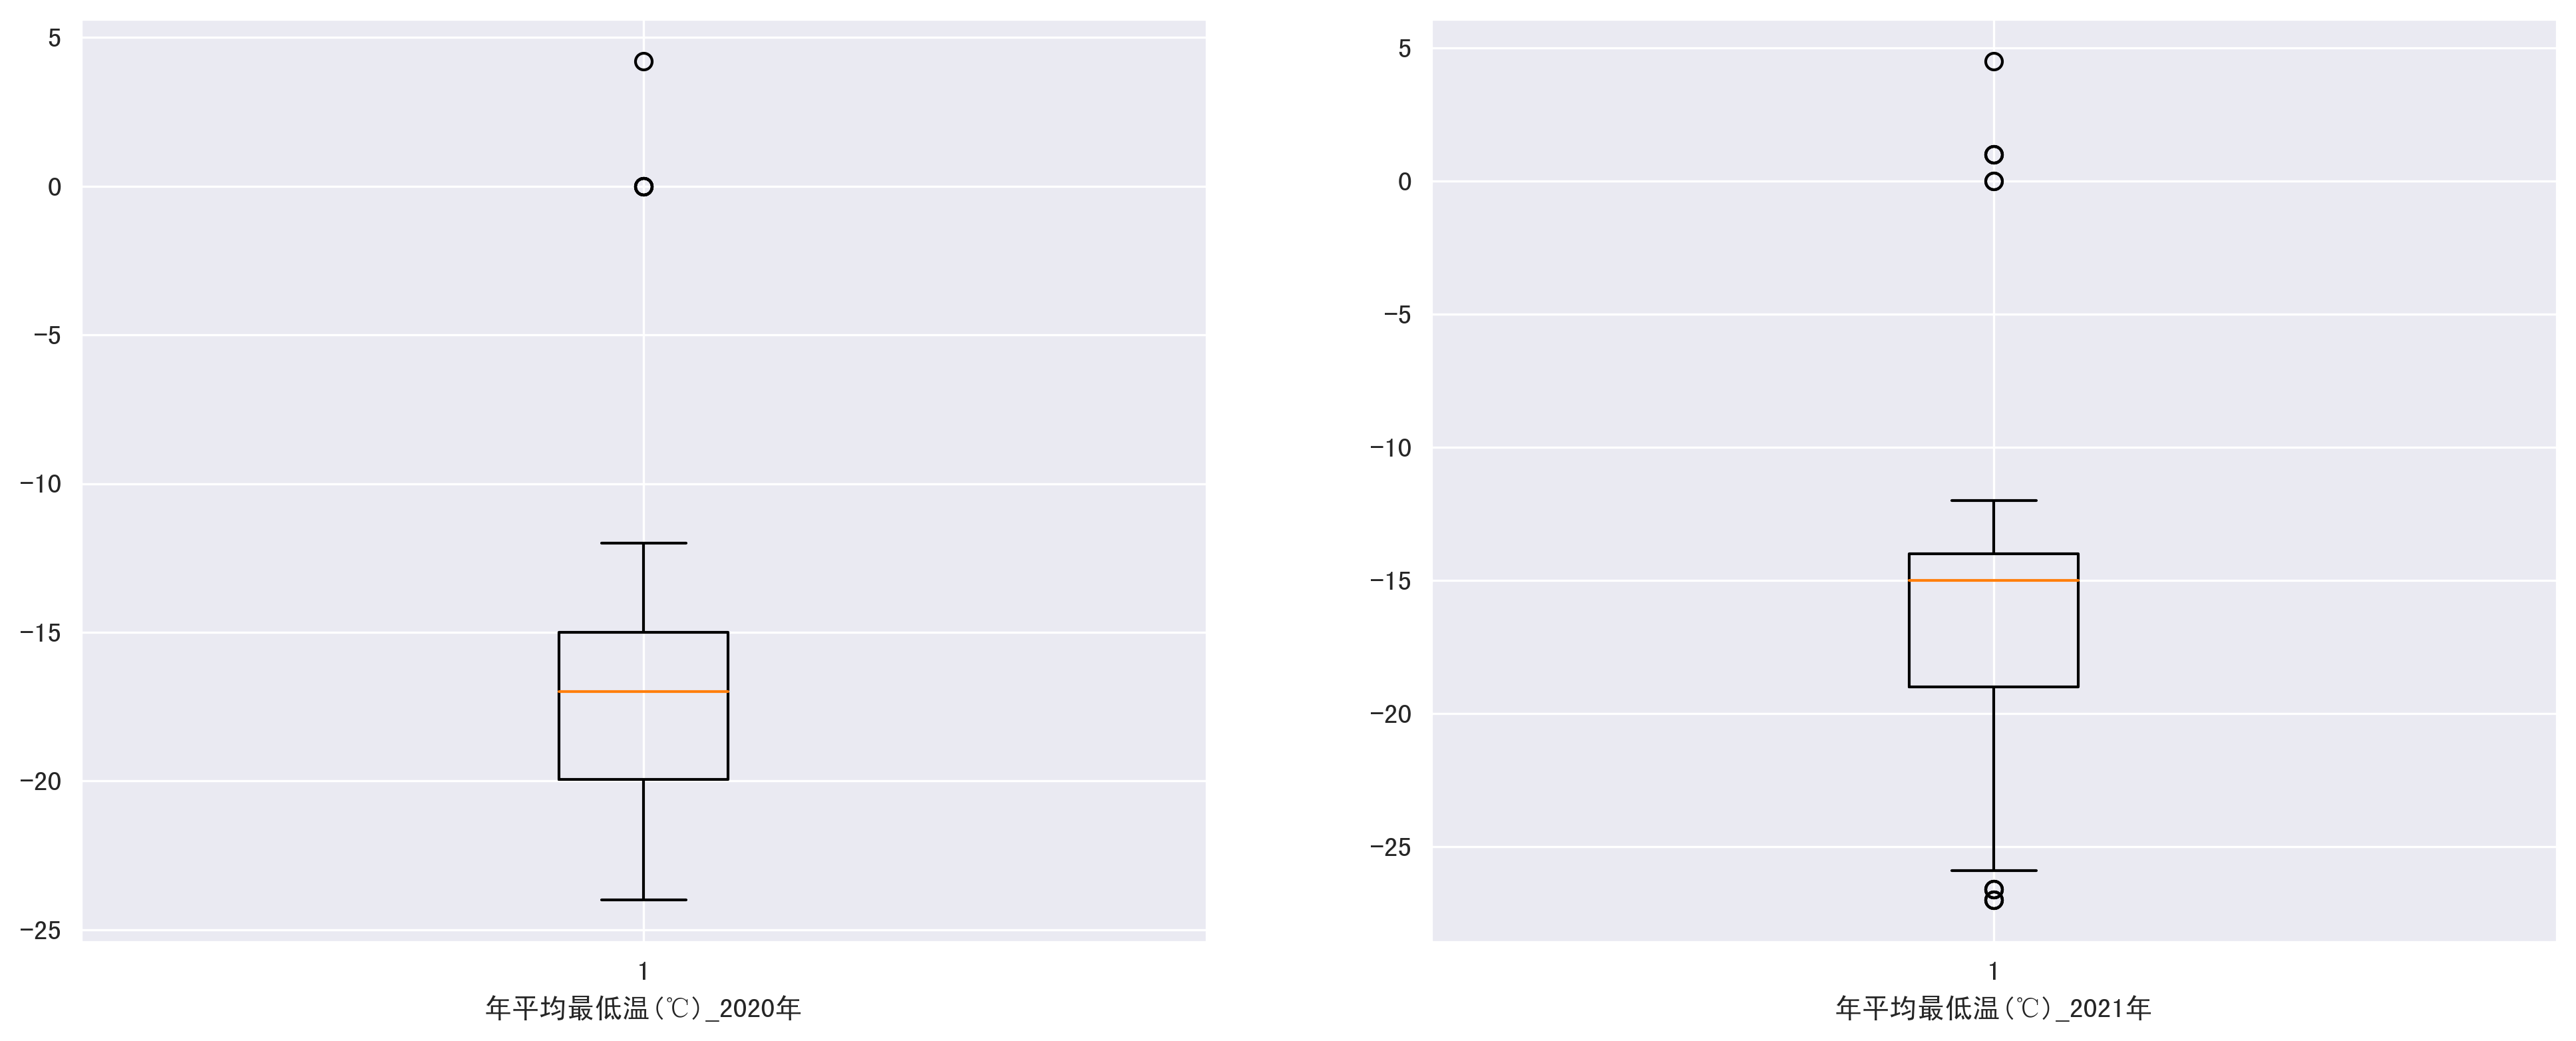

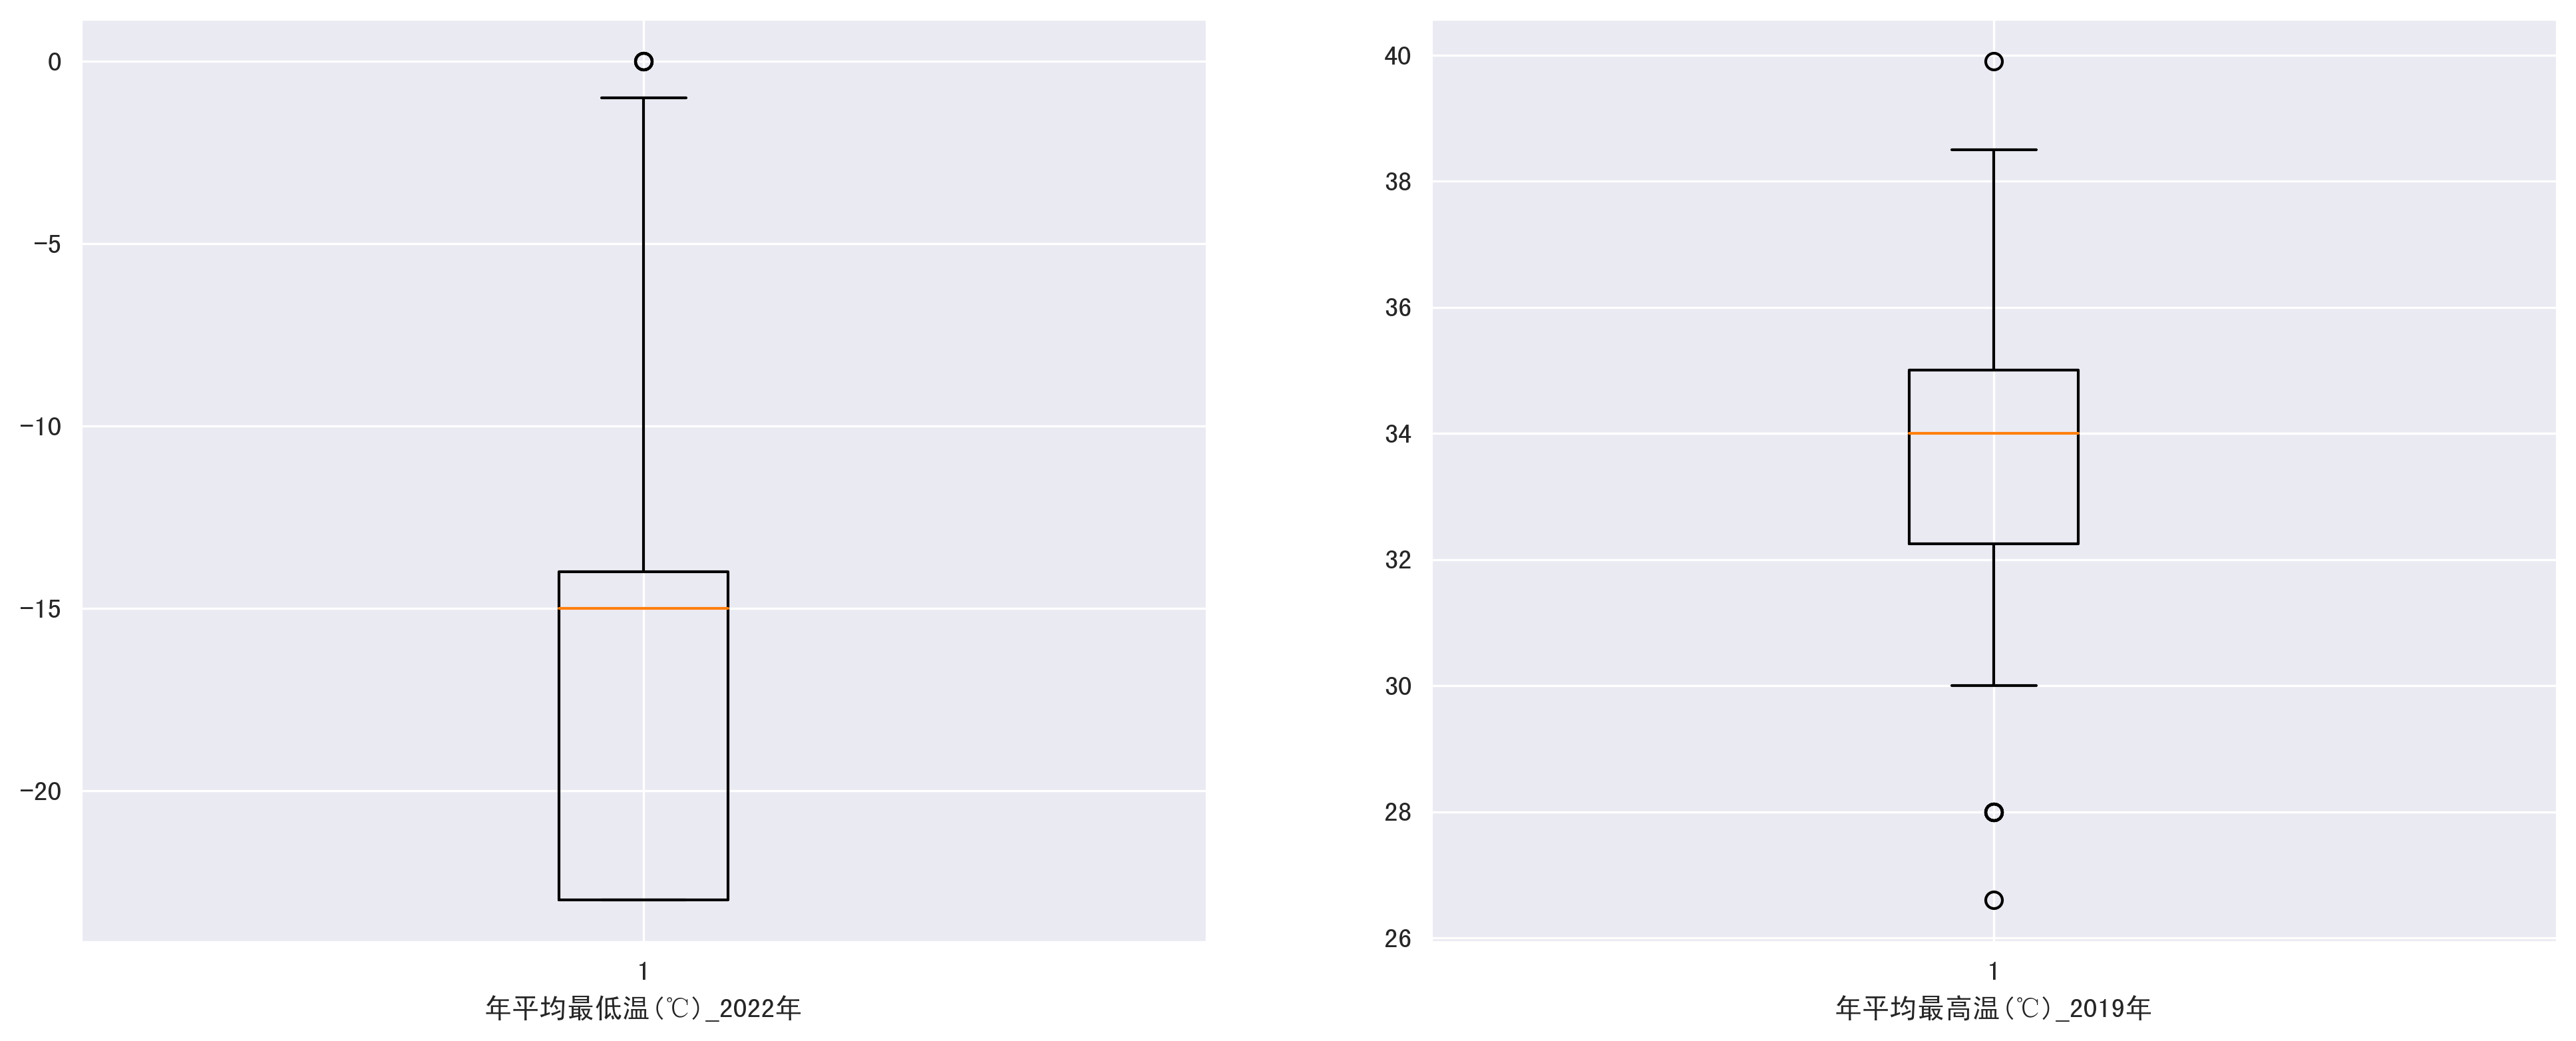

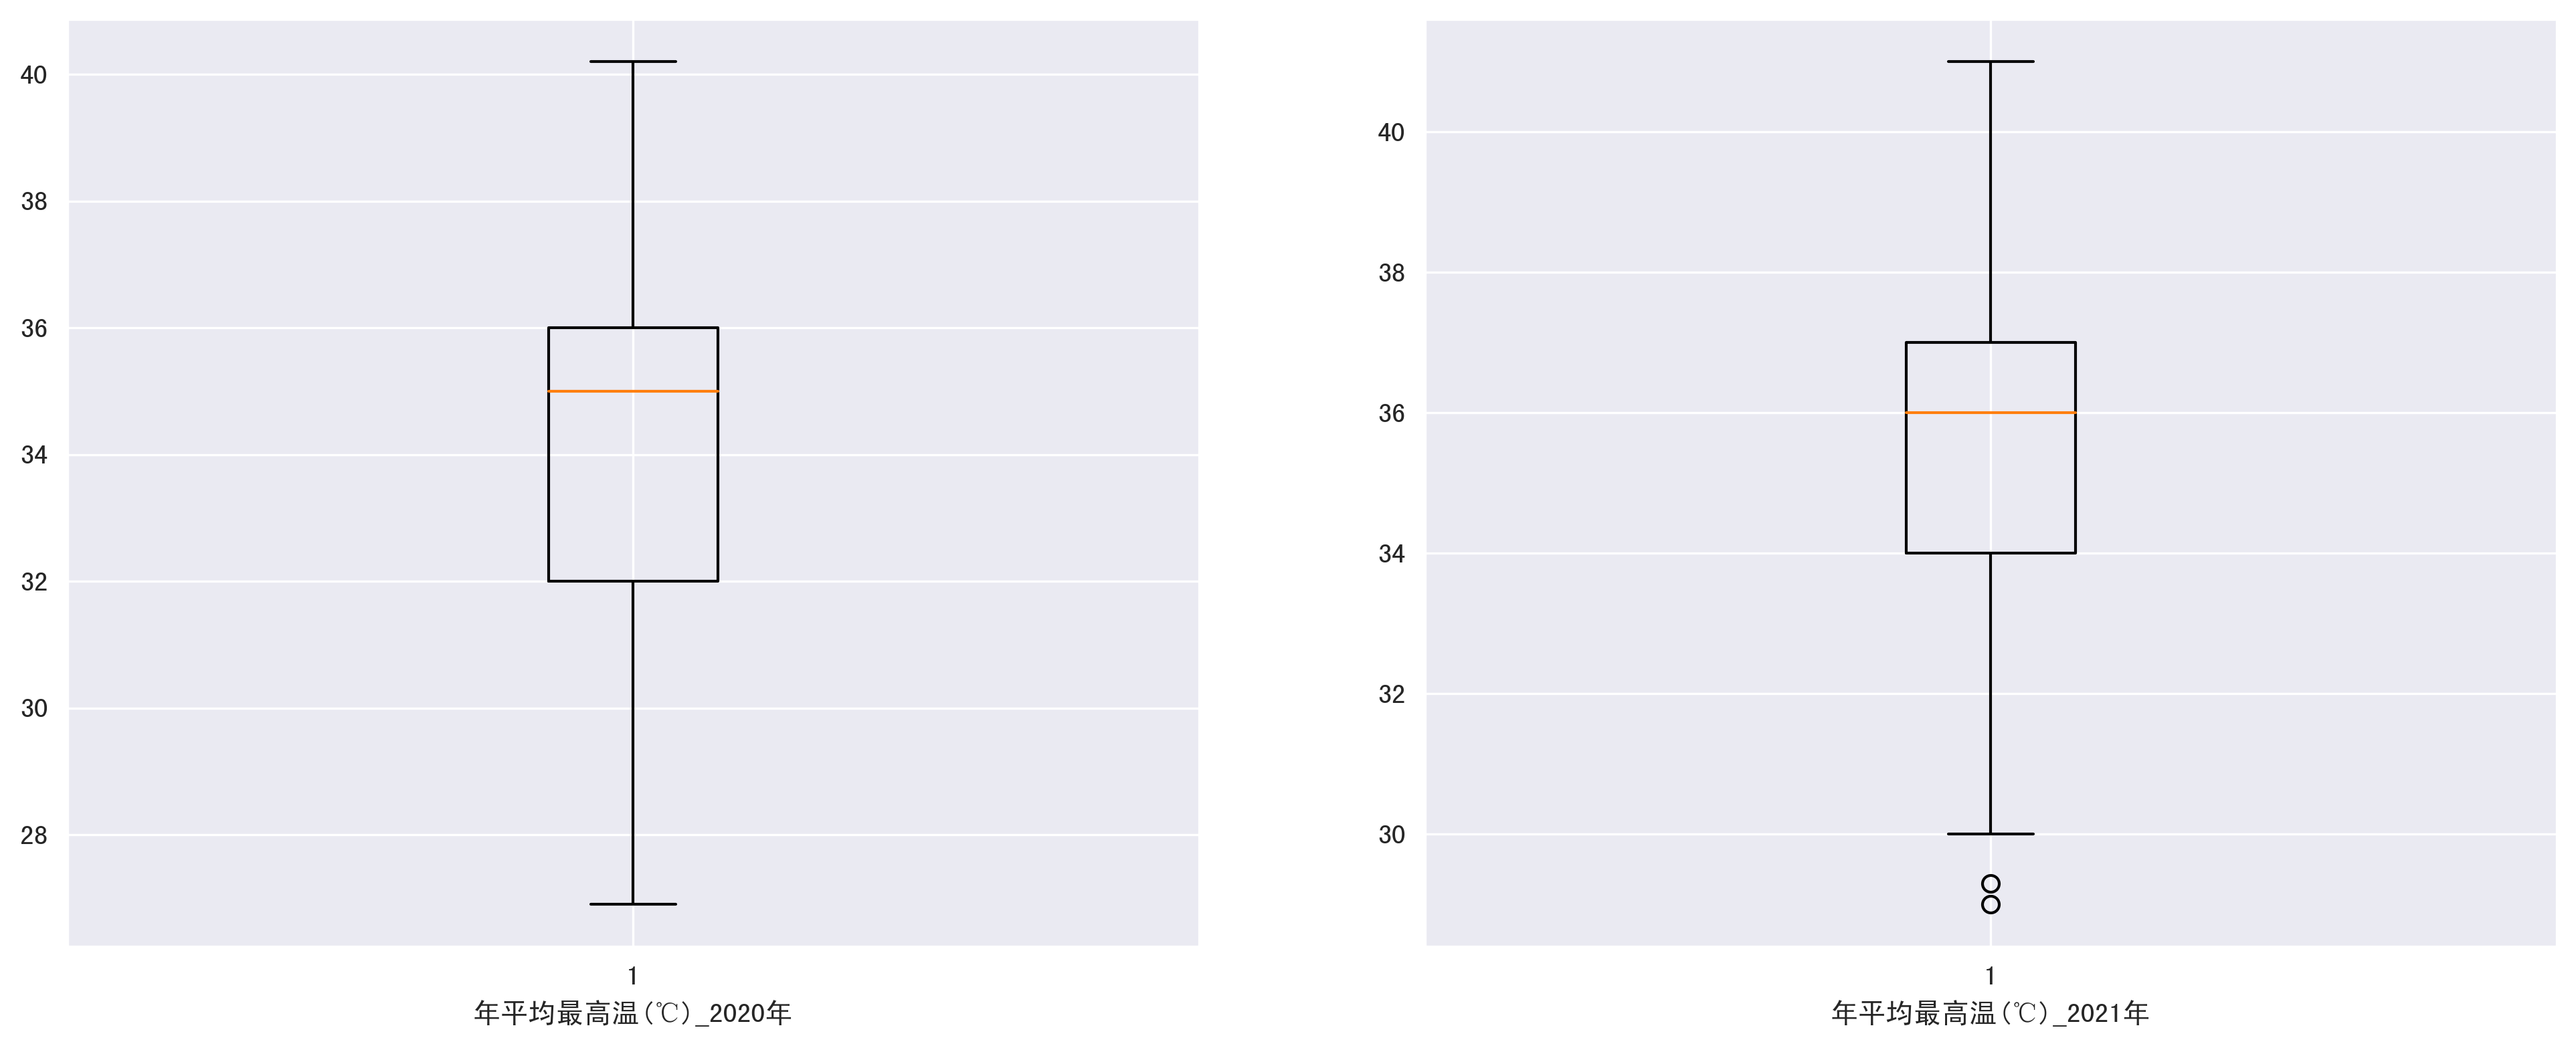

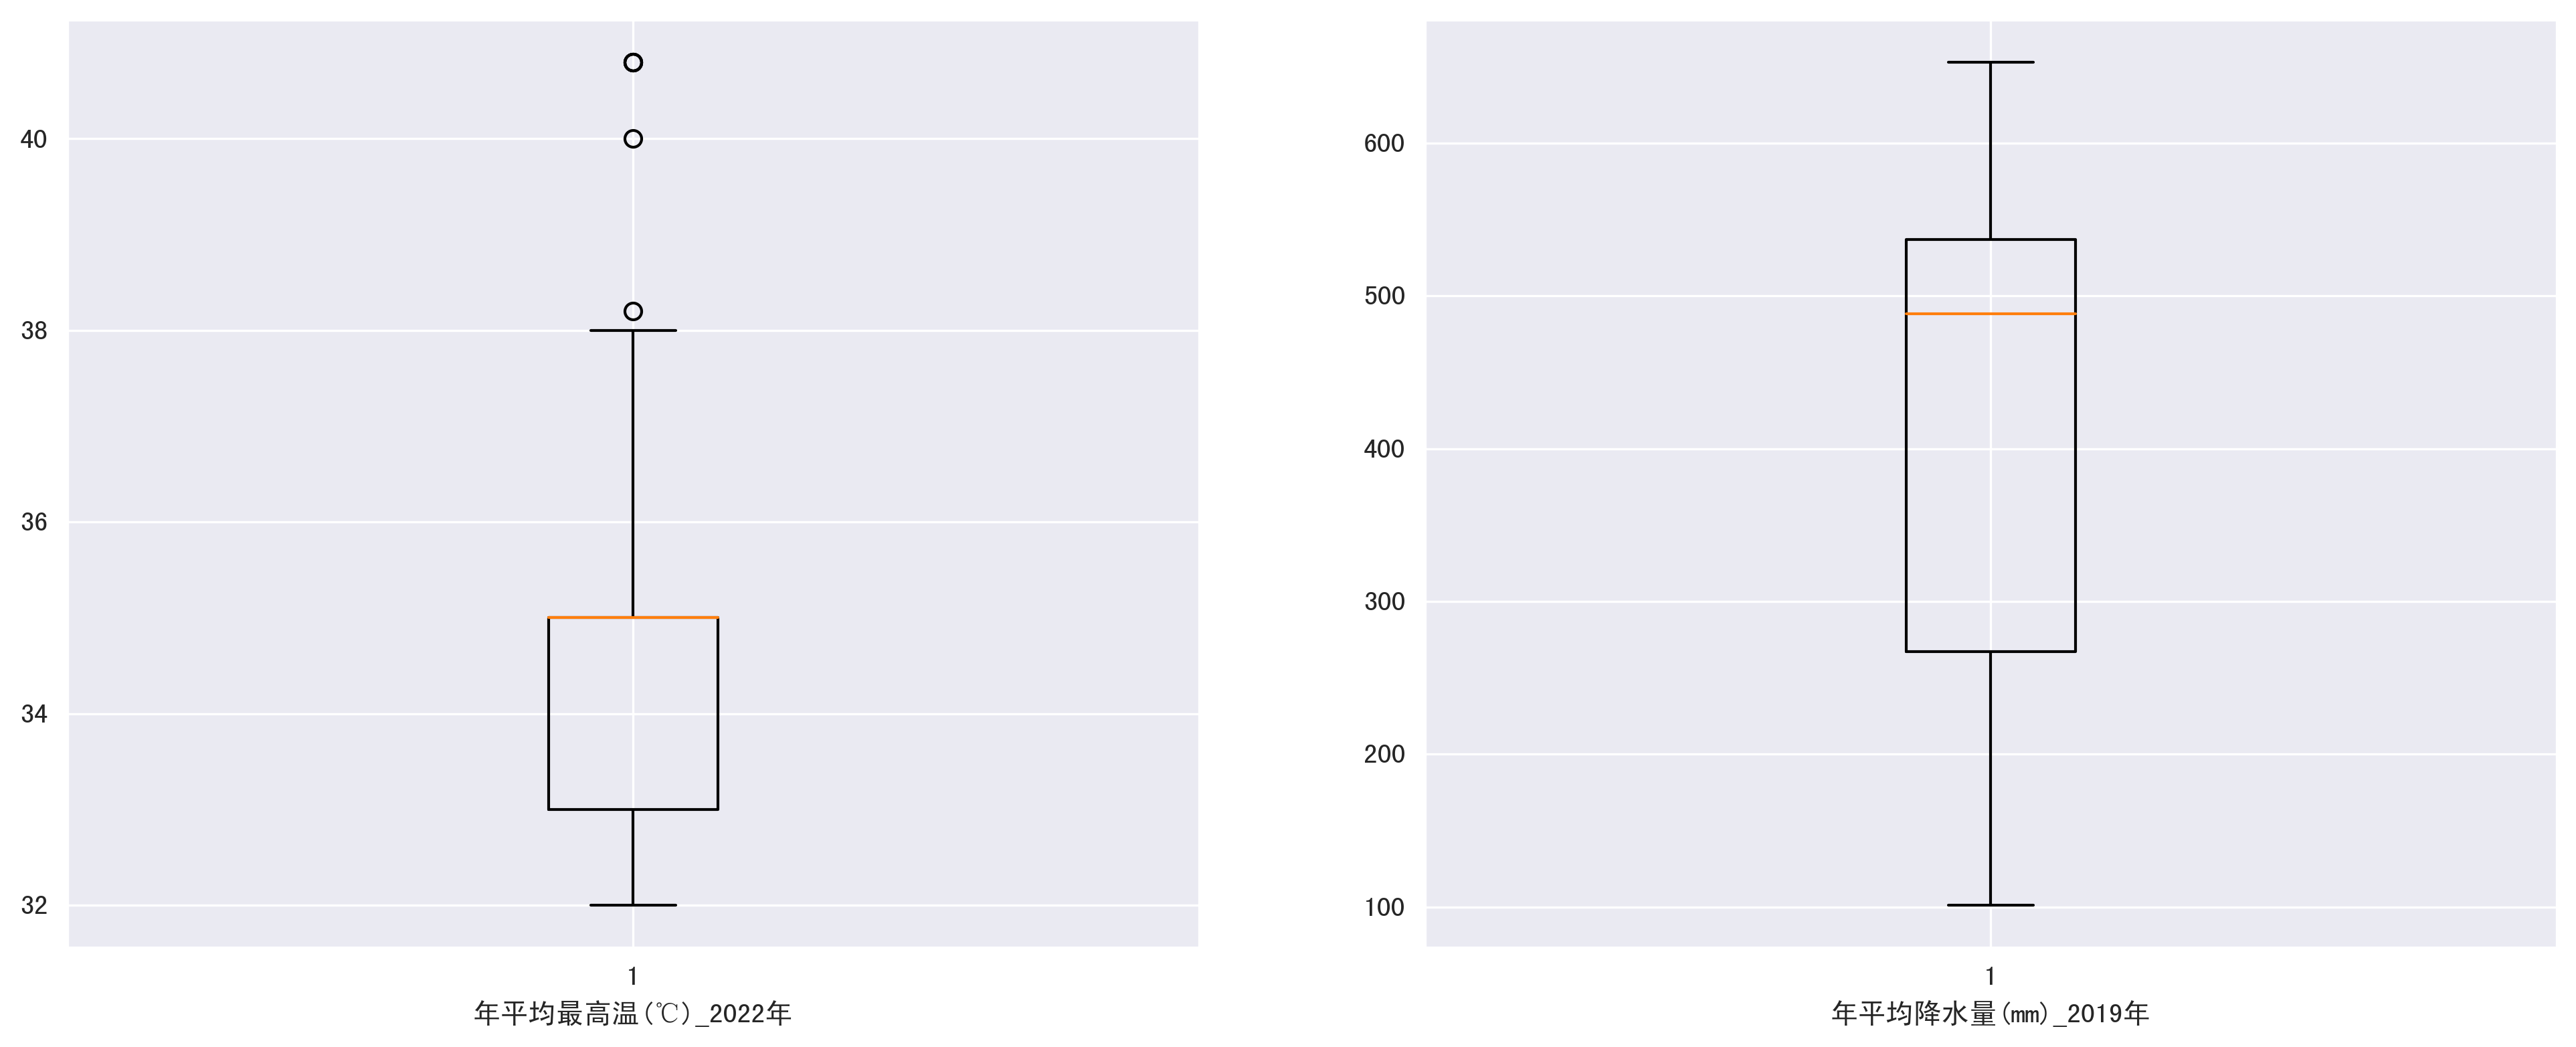

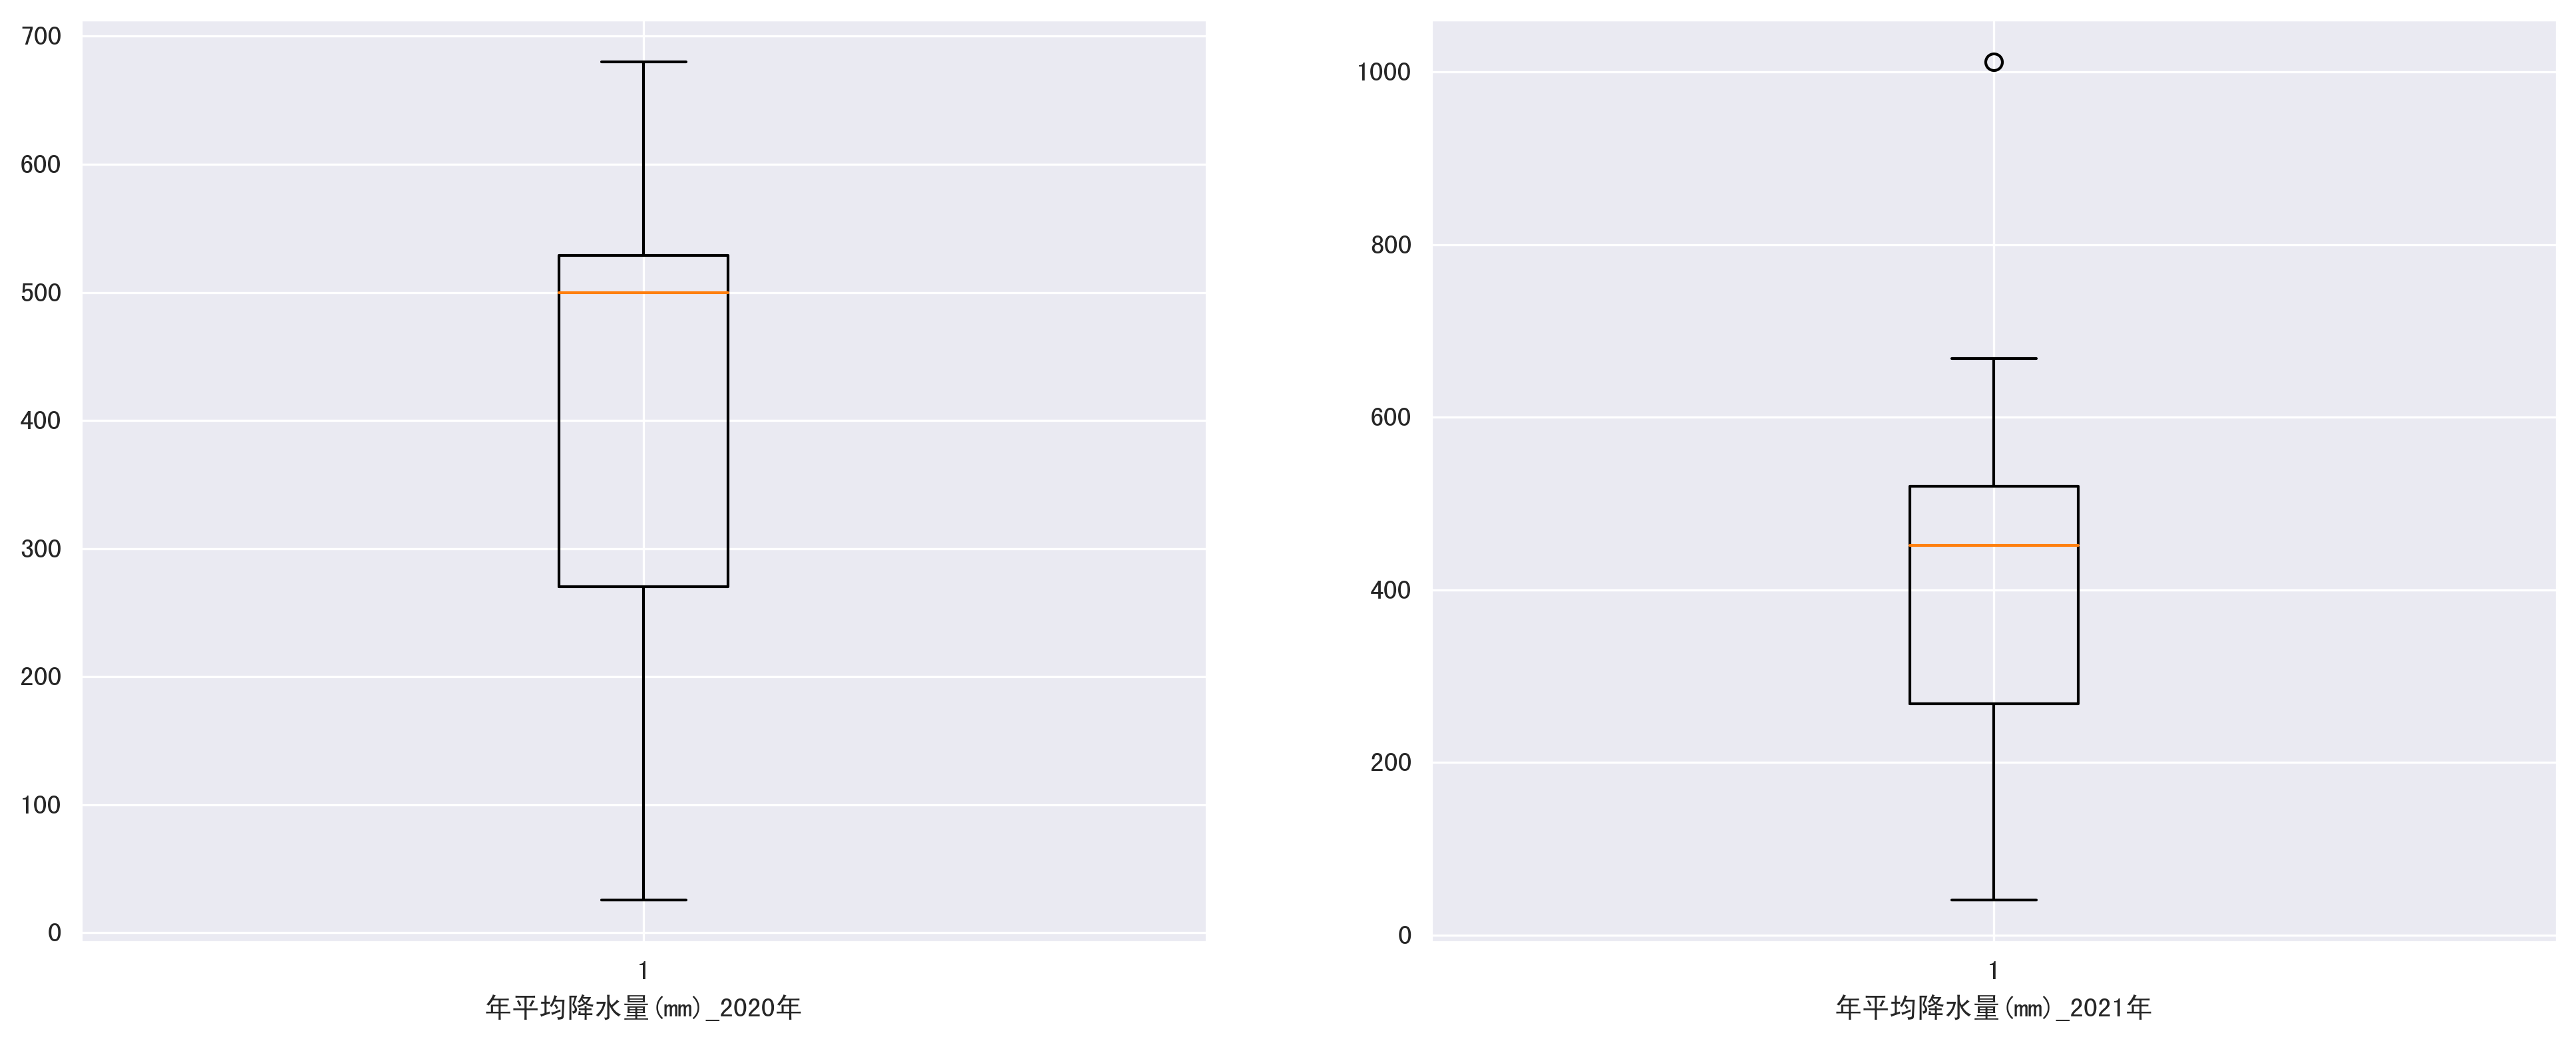

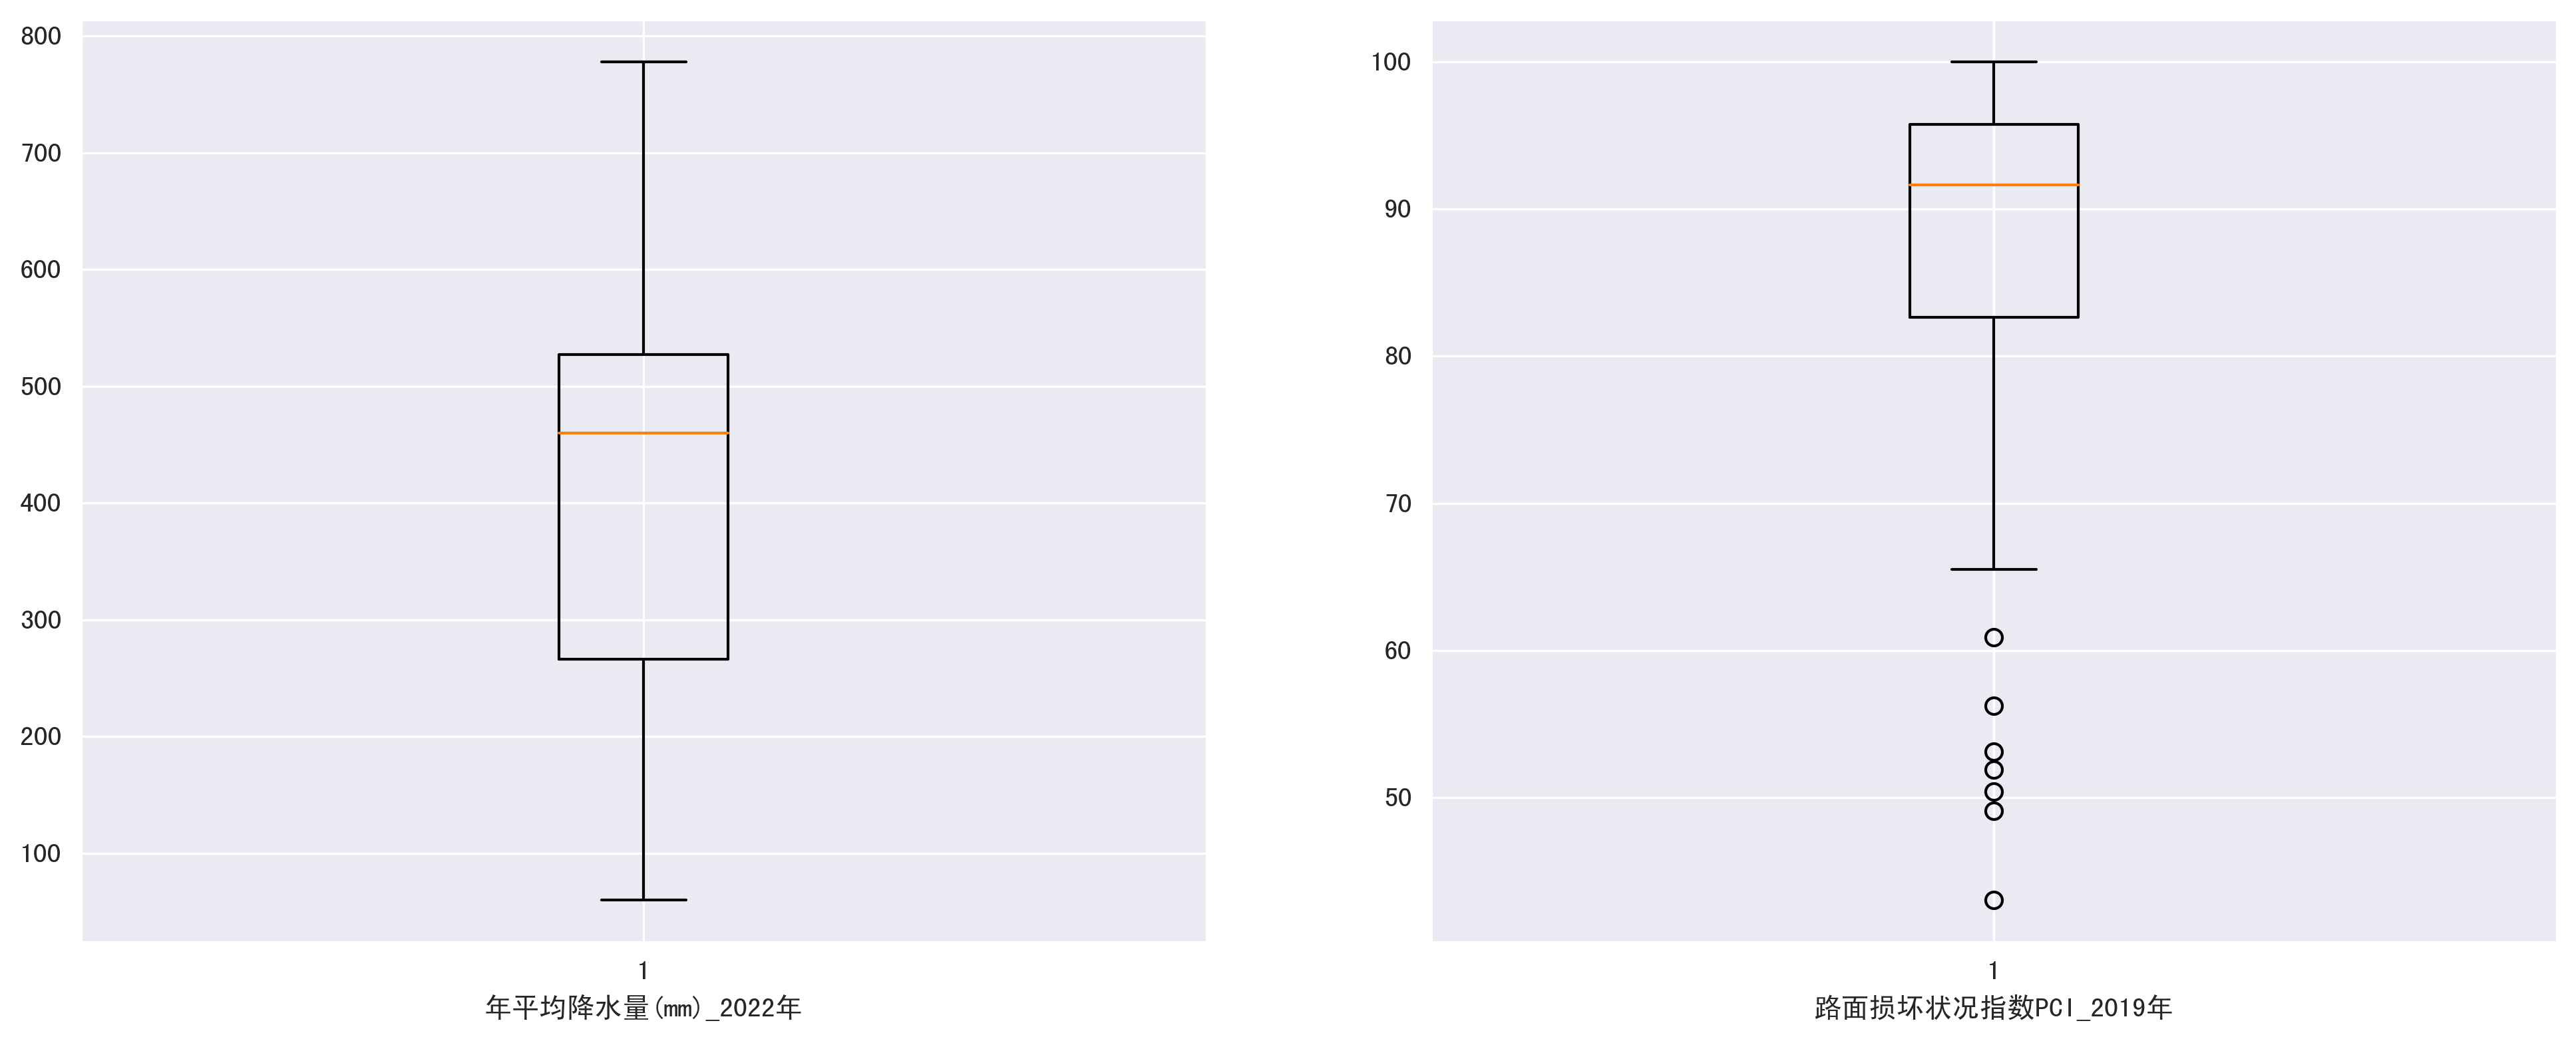

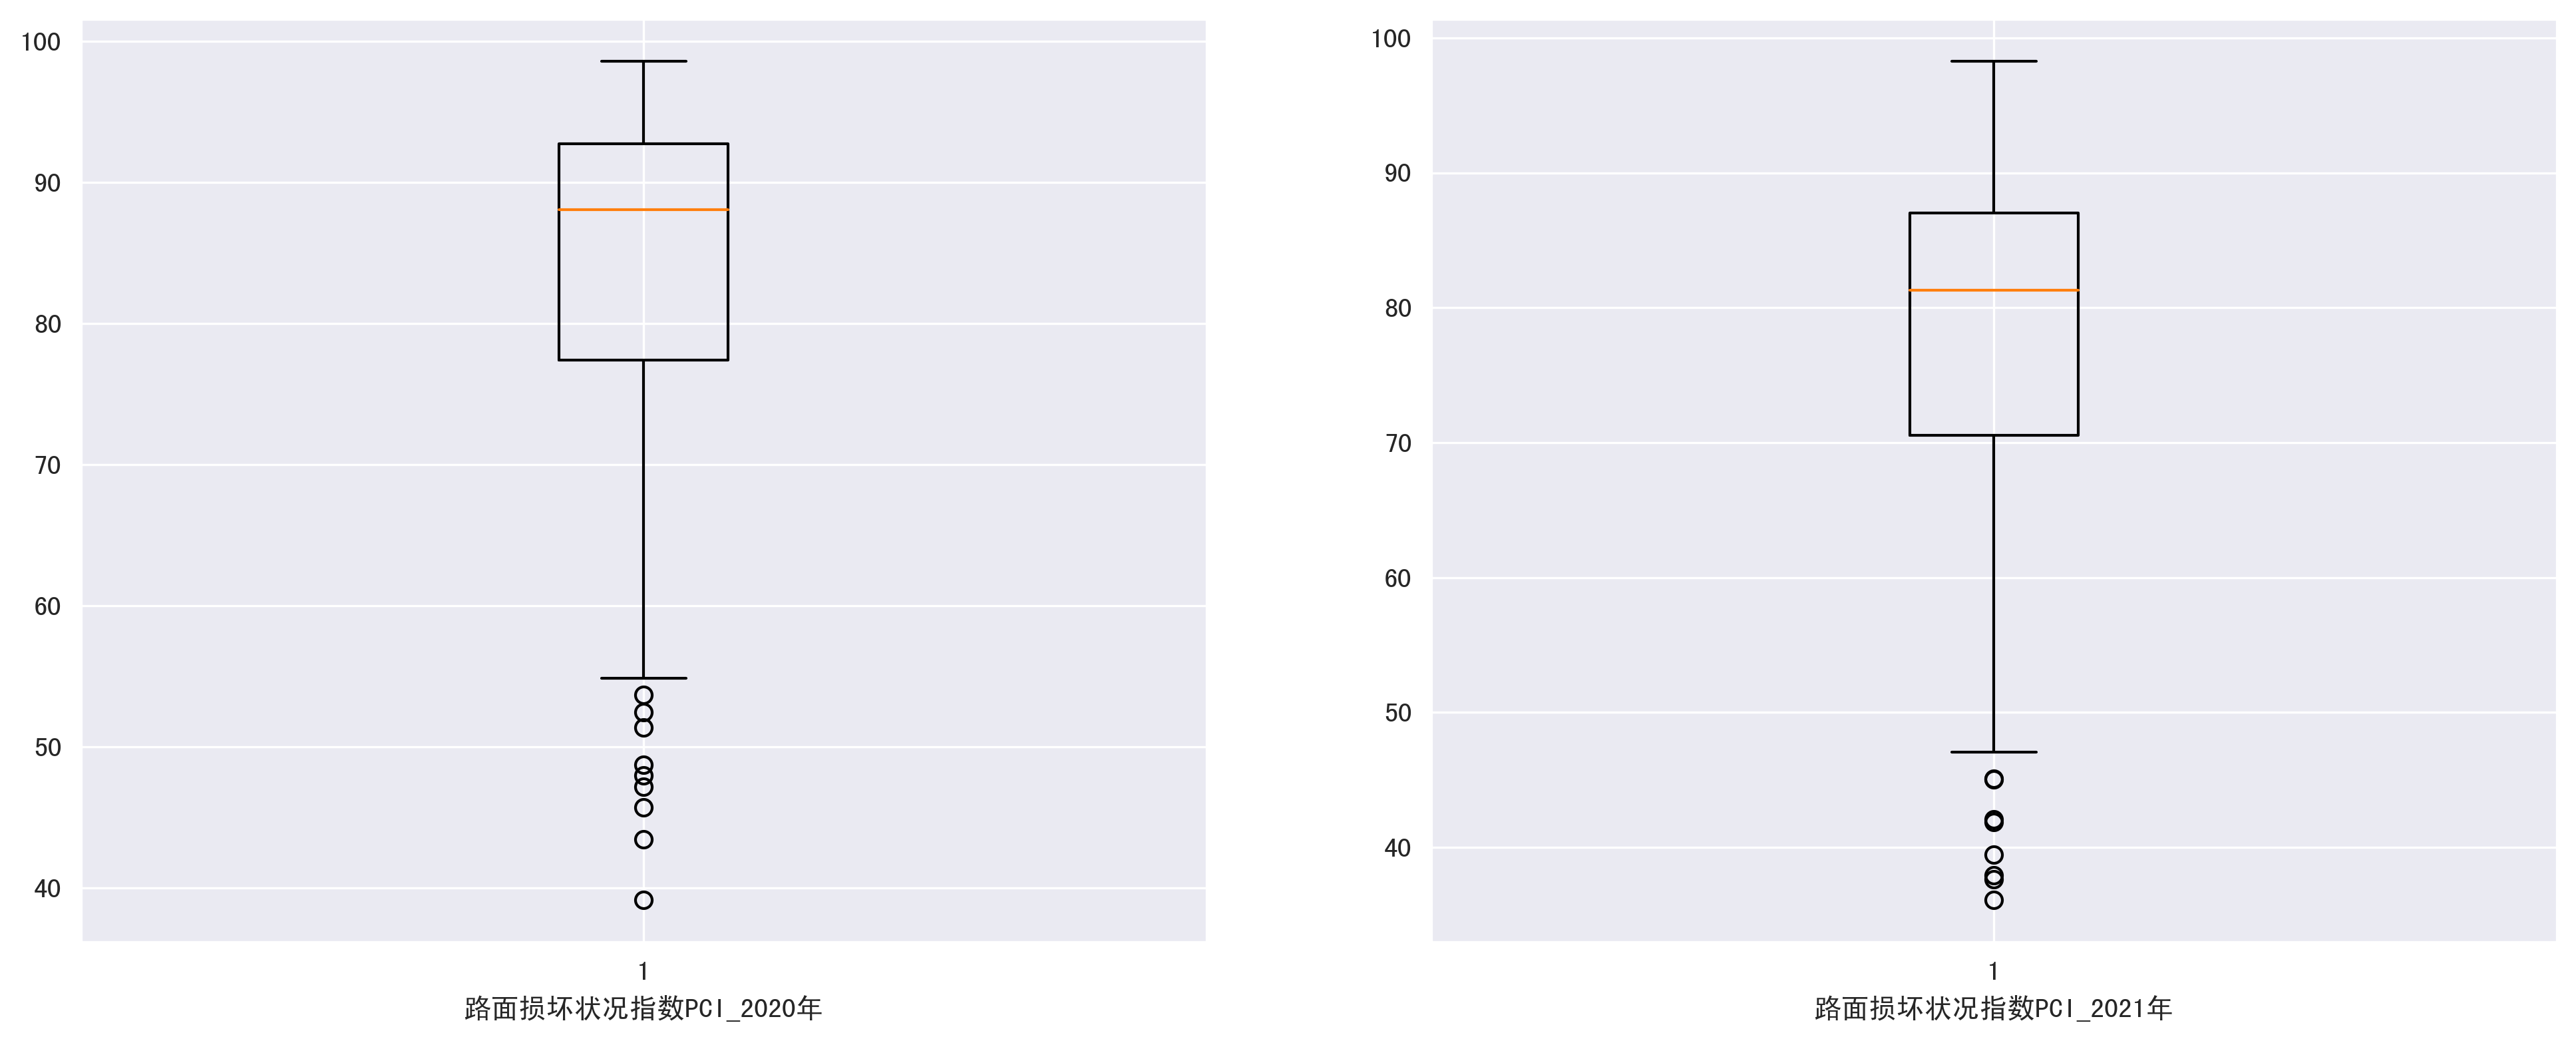

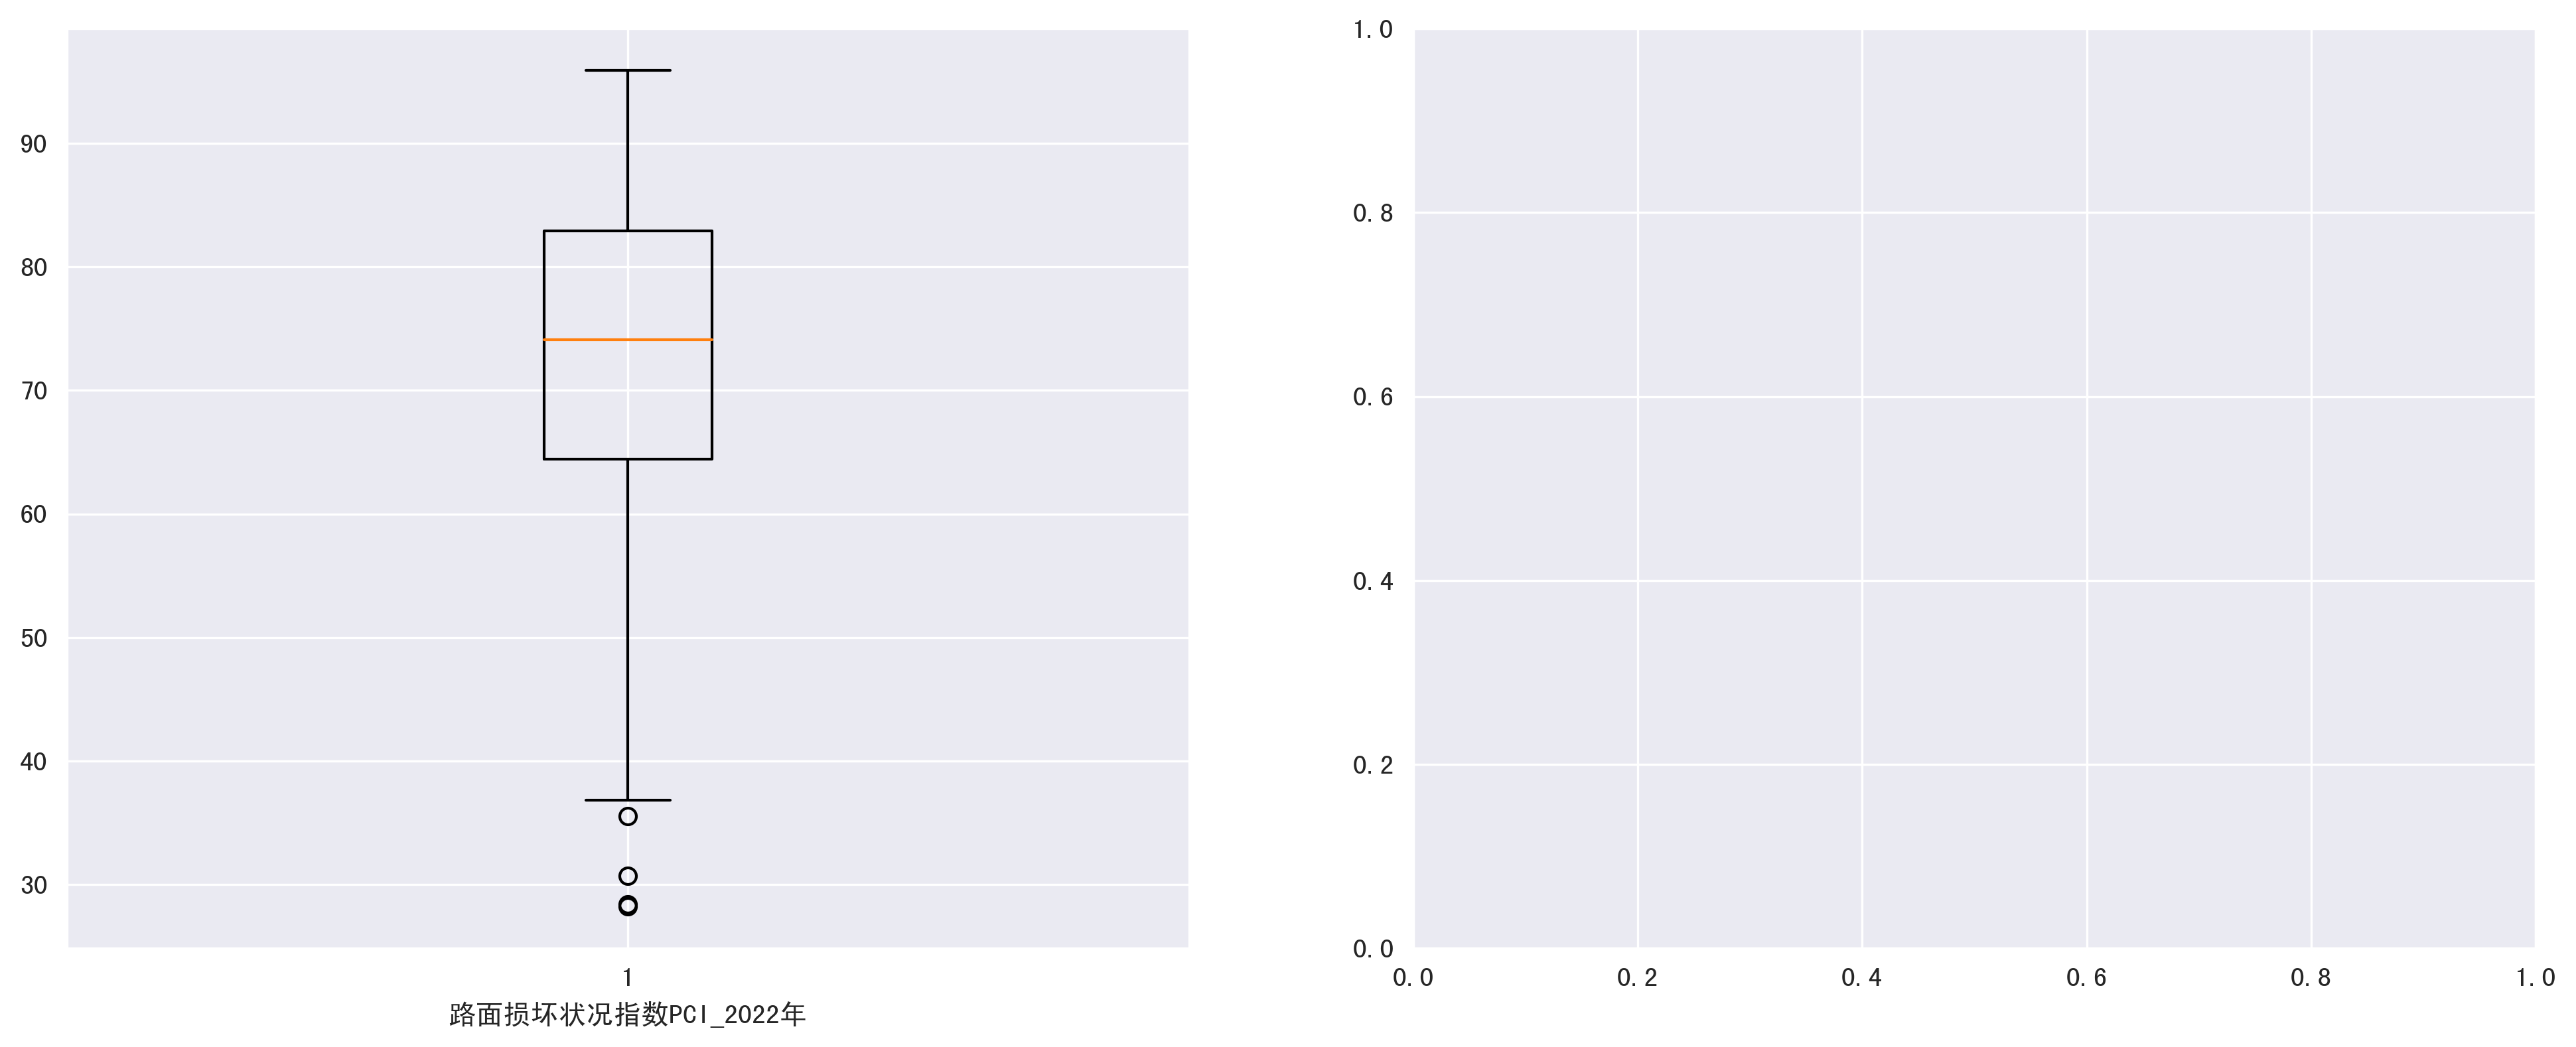

In [17]:
# 箱线图查看异常值
for i in list(range(0,24,2)):
    plt.figure(figsize=(16, 6), dpi=300) # 画布长宽、清晰度
    for j in list(range(i,i+2,1)):
        plt.subplot(1,2,j+1-i)
        plt.boxplot(filtered_df[ll[j]]) # 年霜冻期(天) 有异常值
        plt.xlabel(ll[j])

IndexError: list index out of range

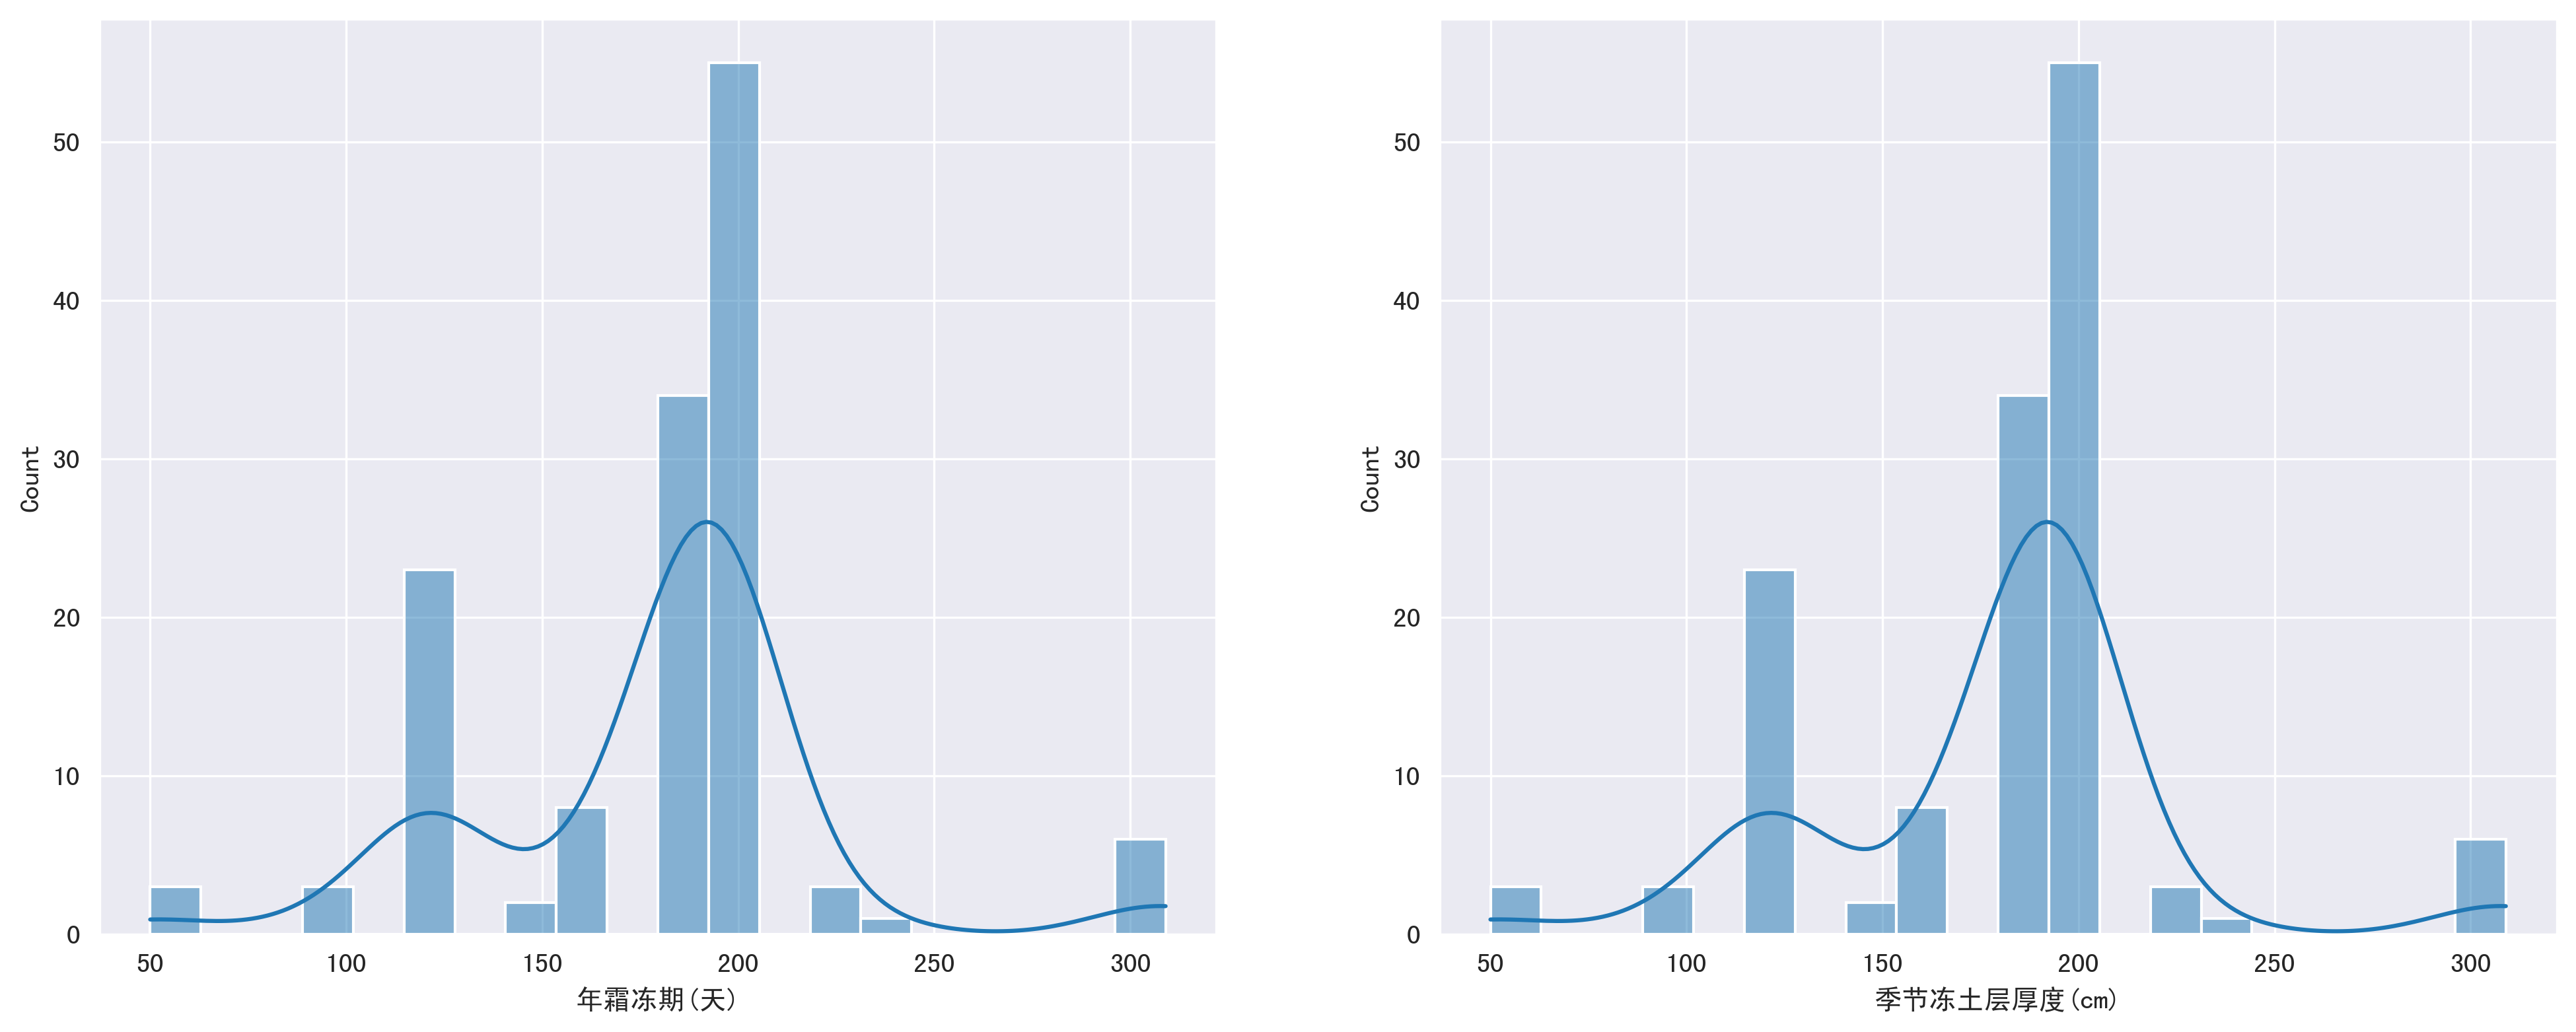

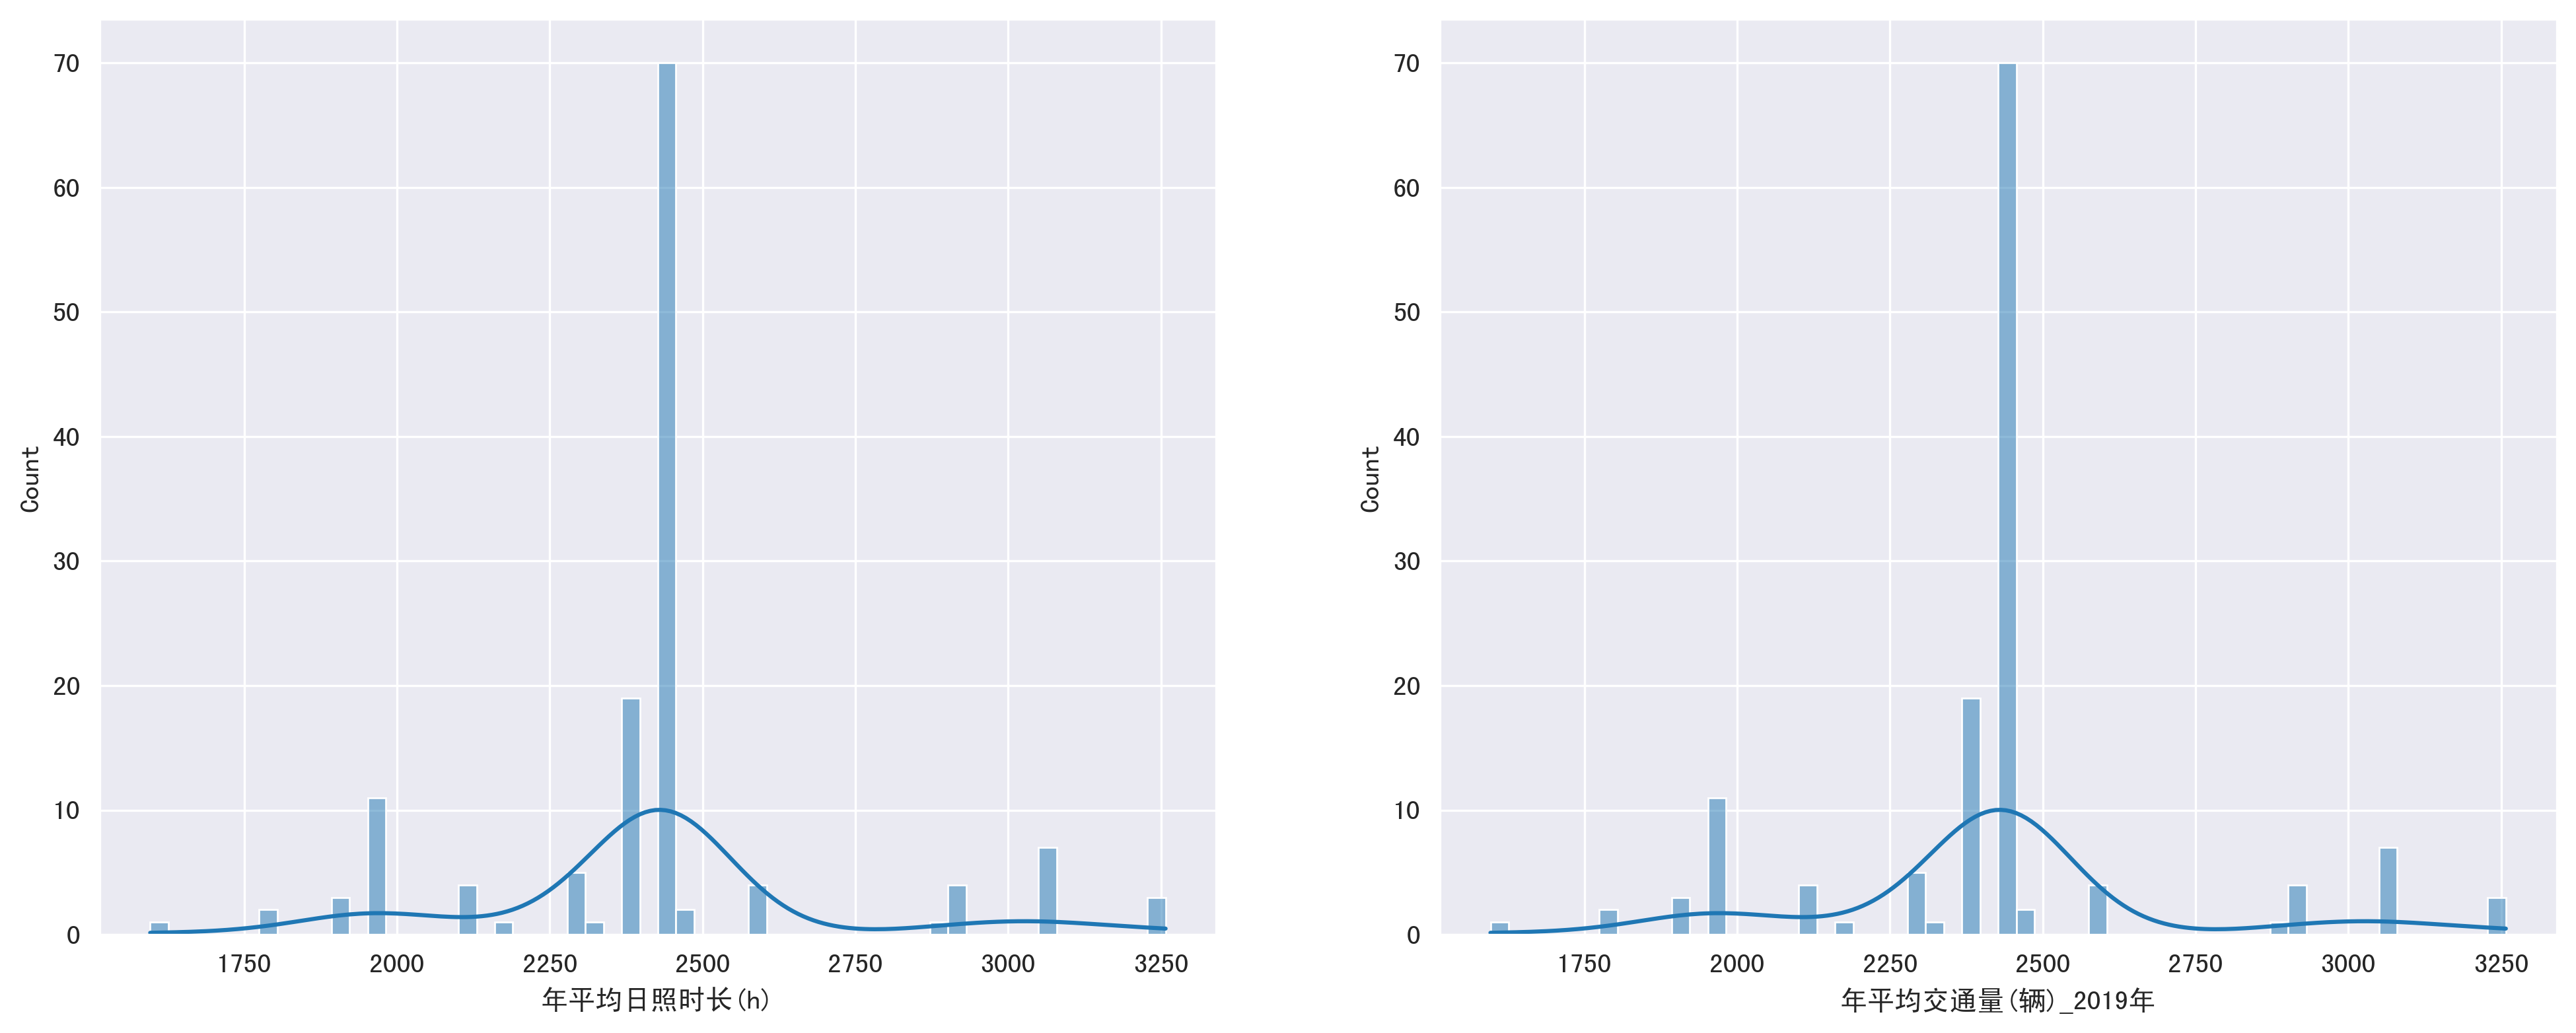

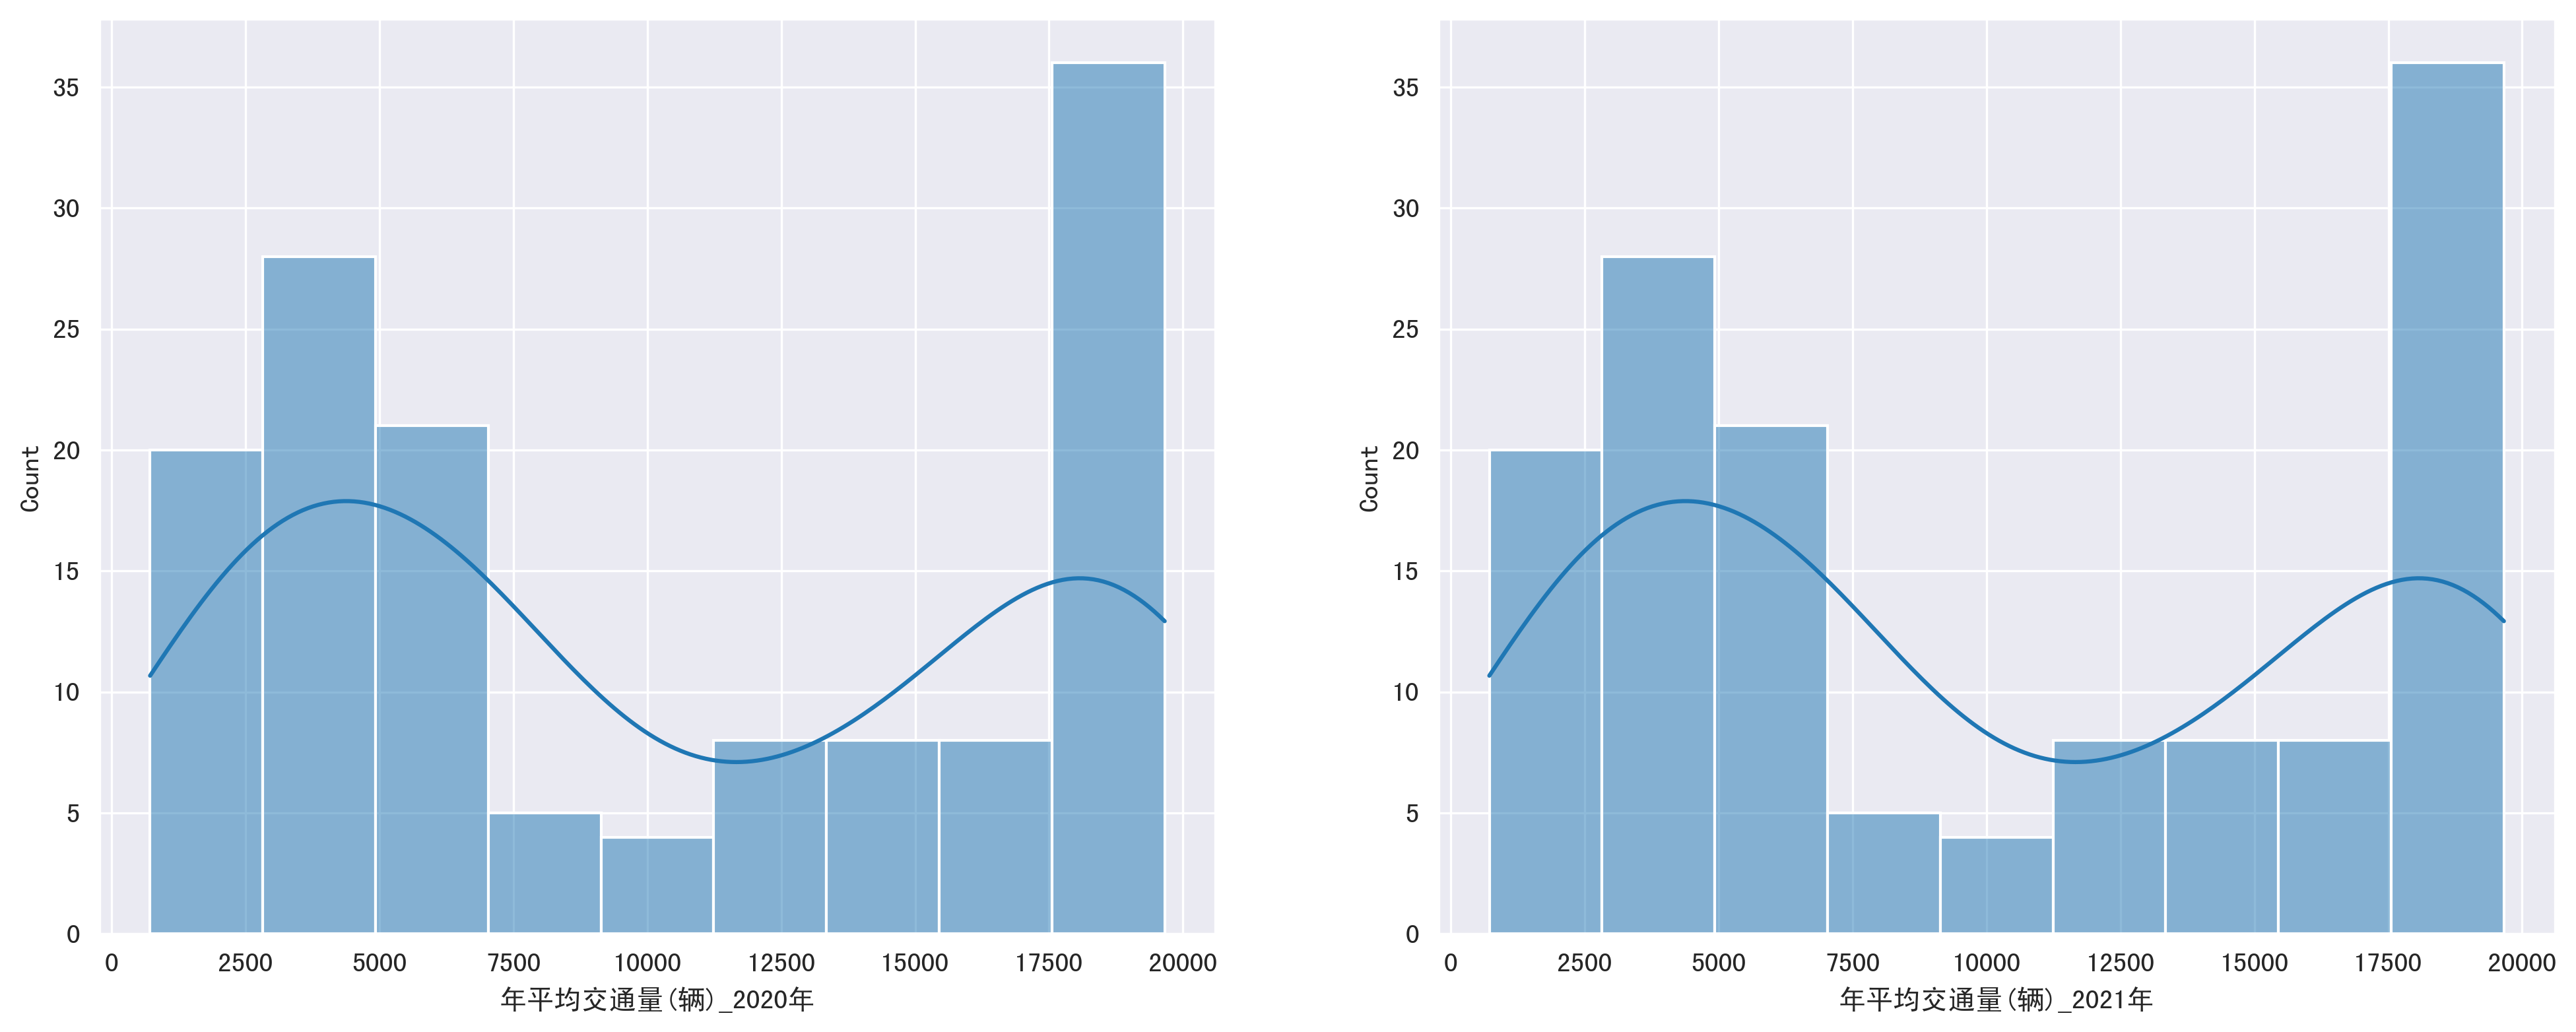

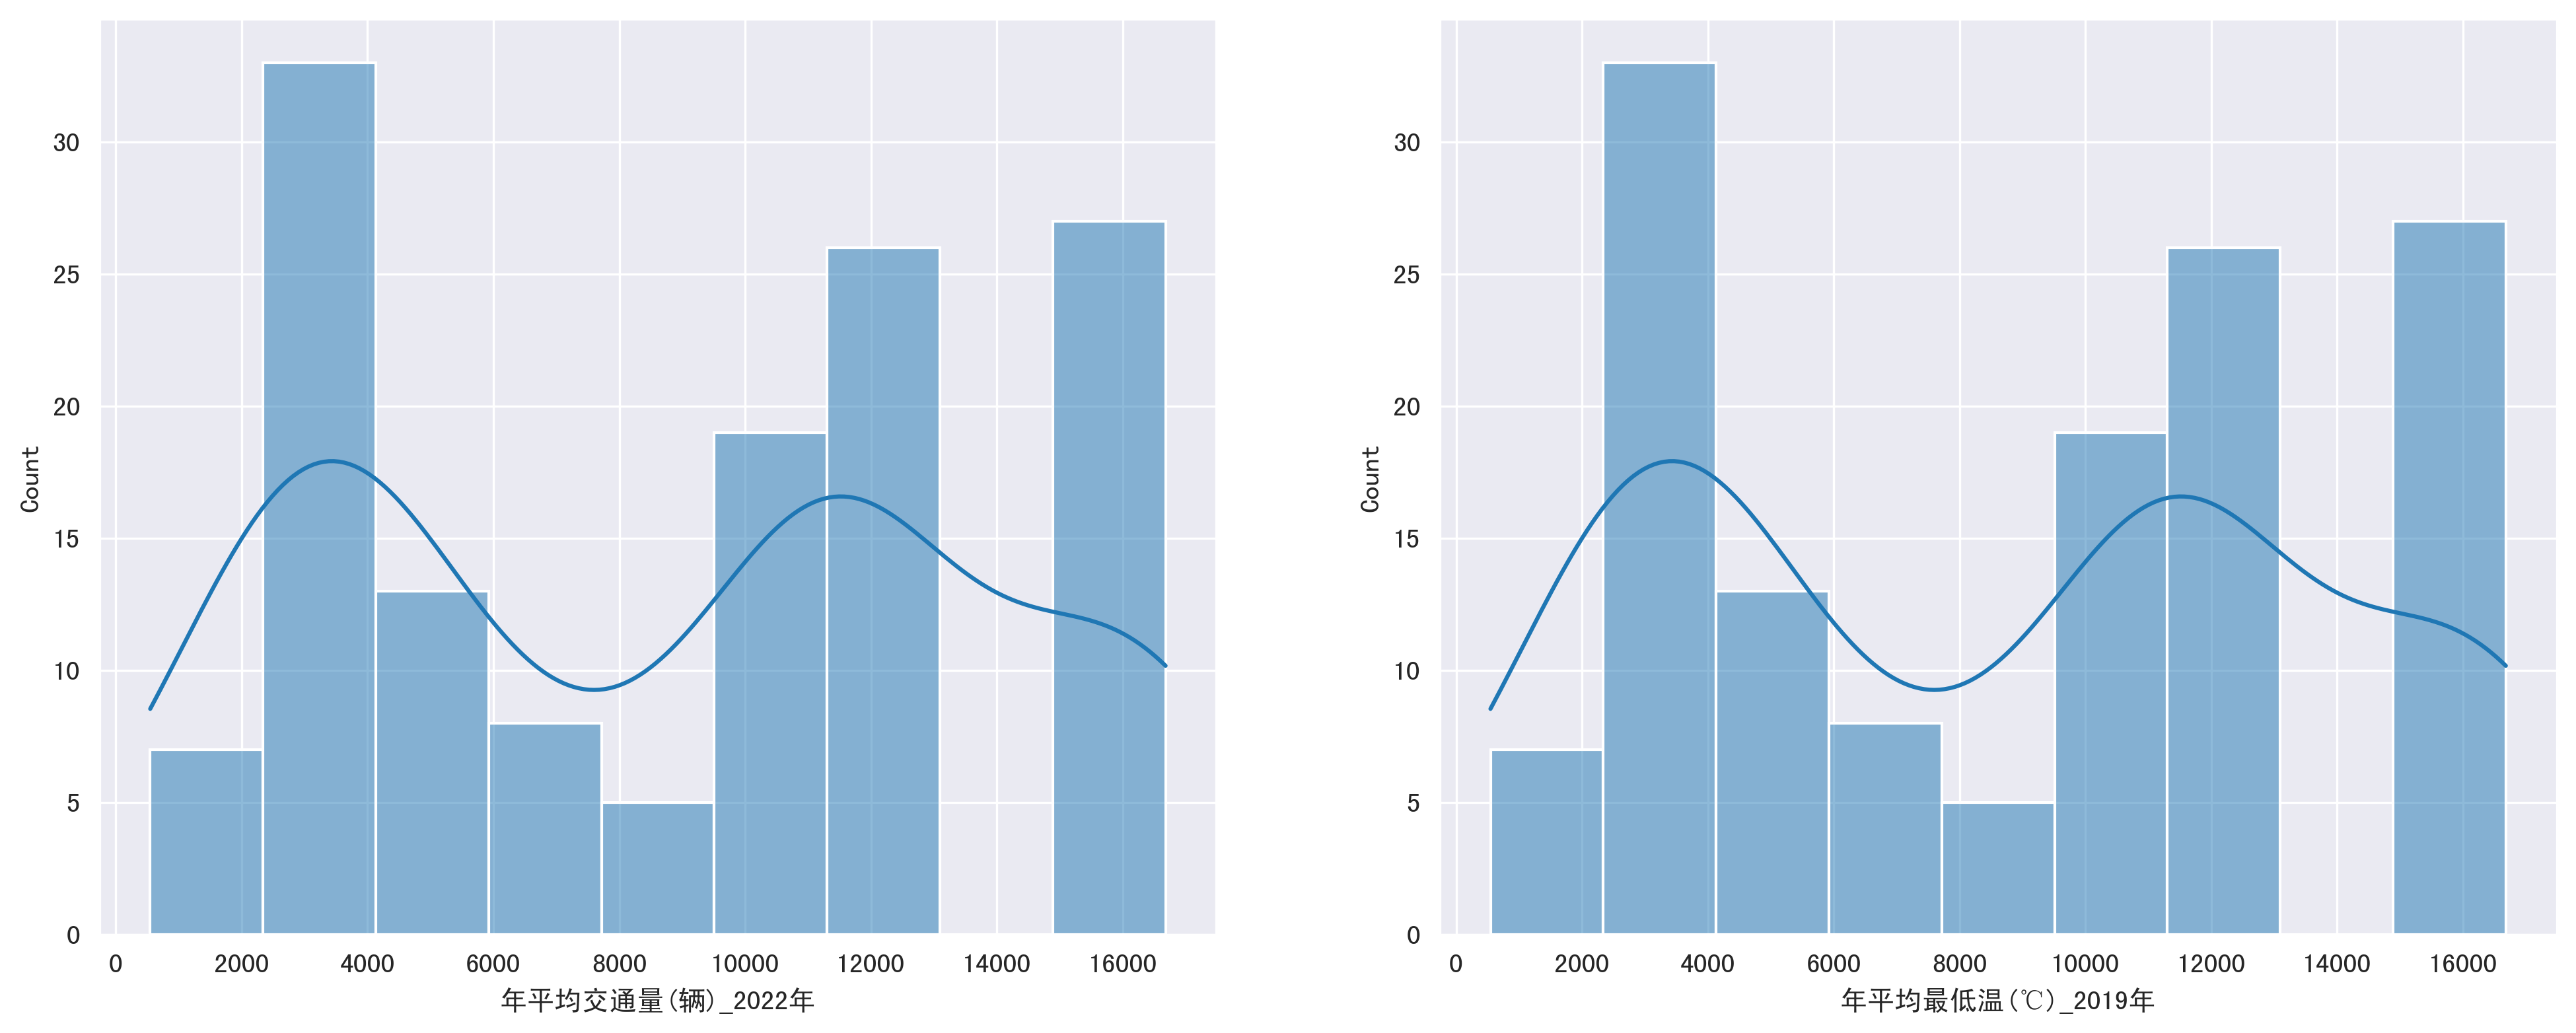

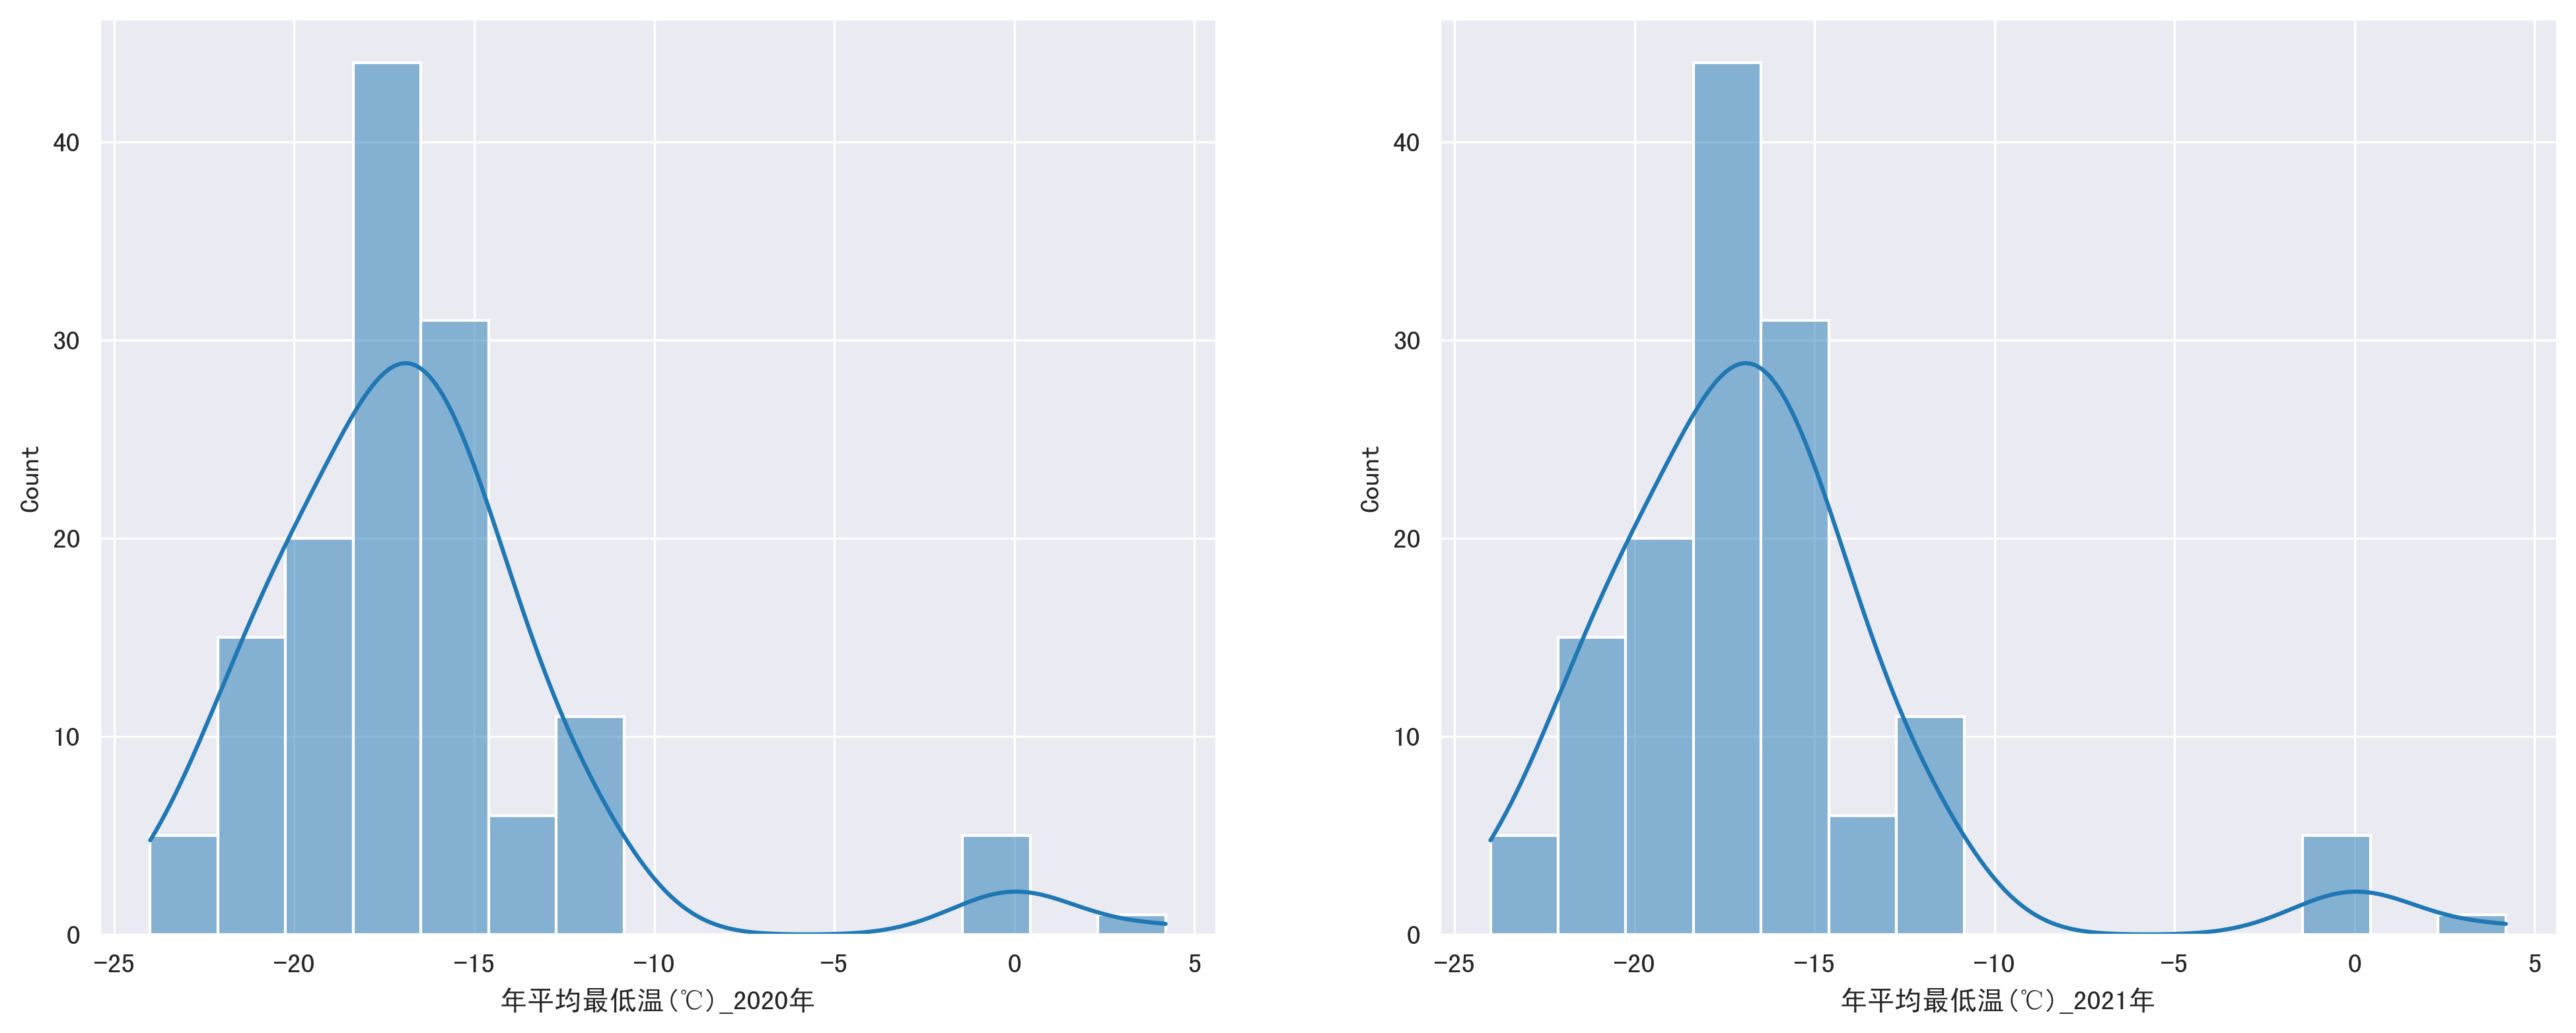

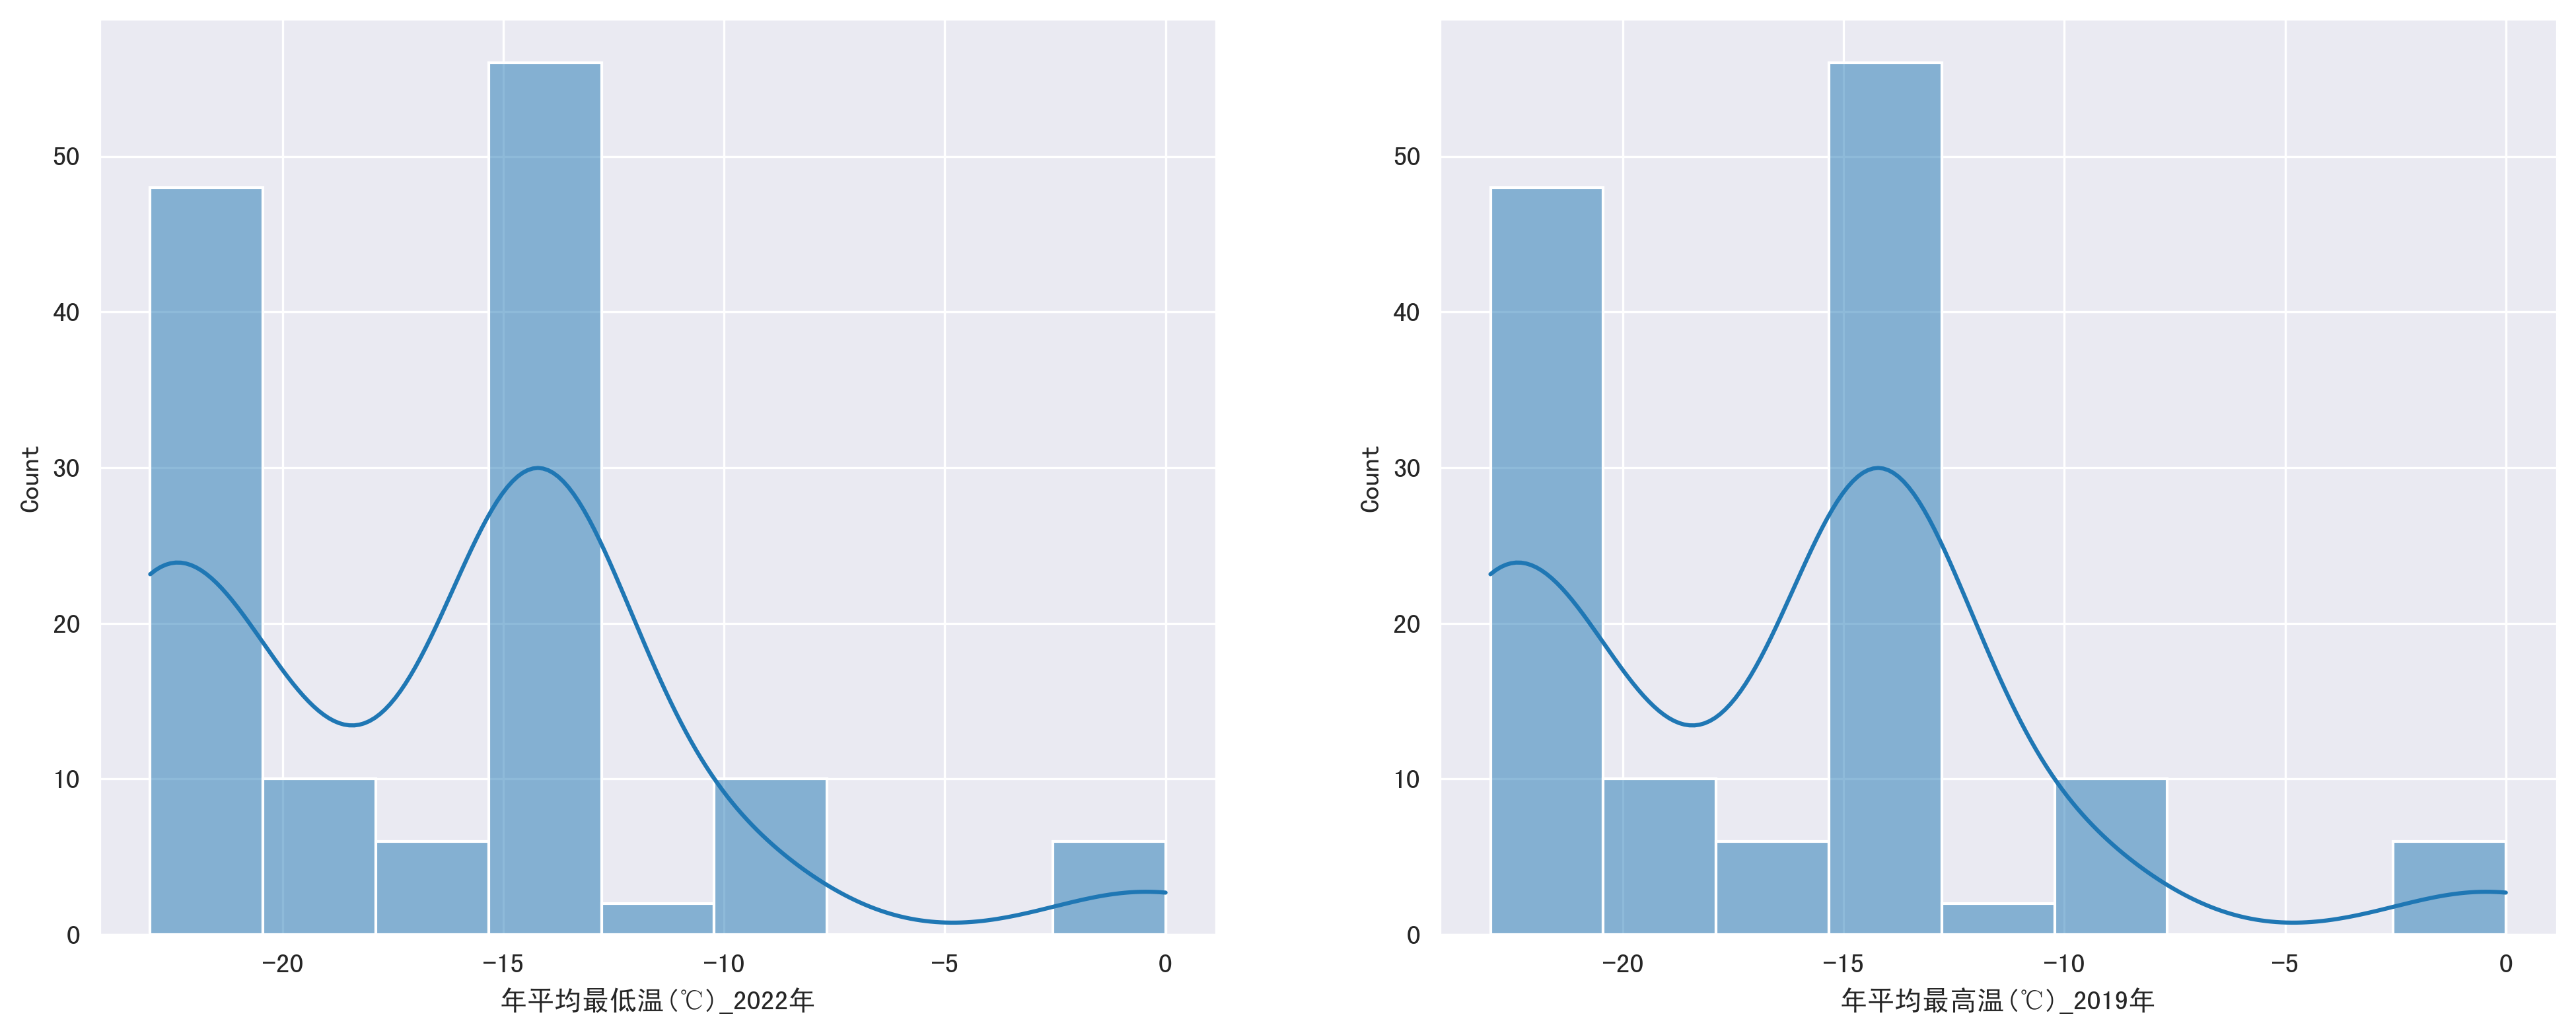

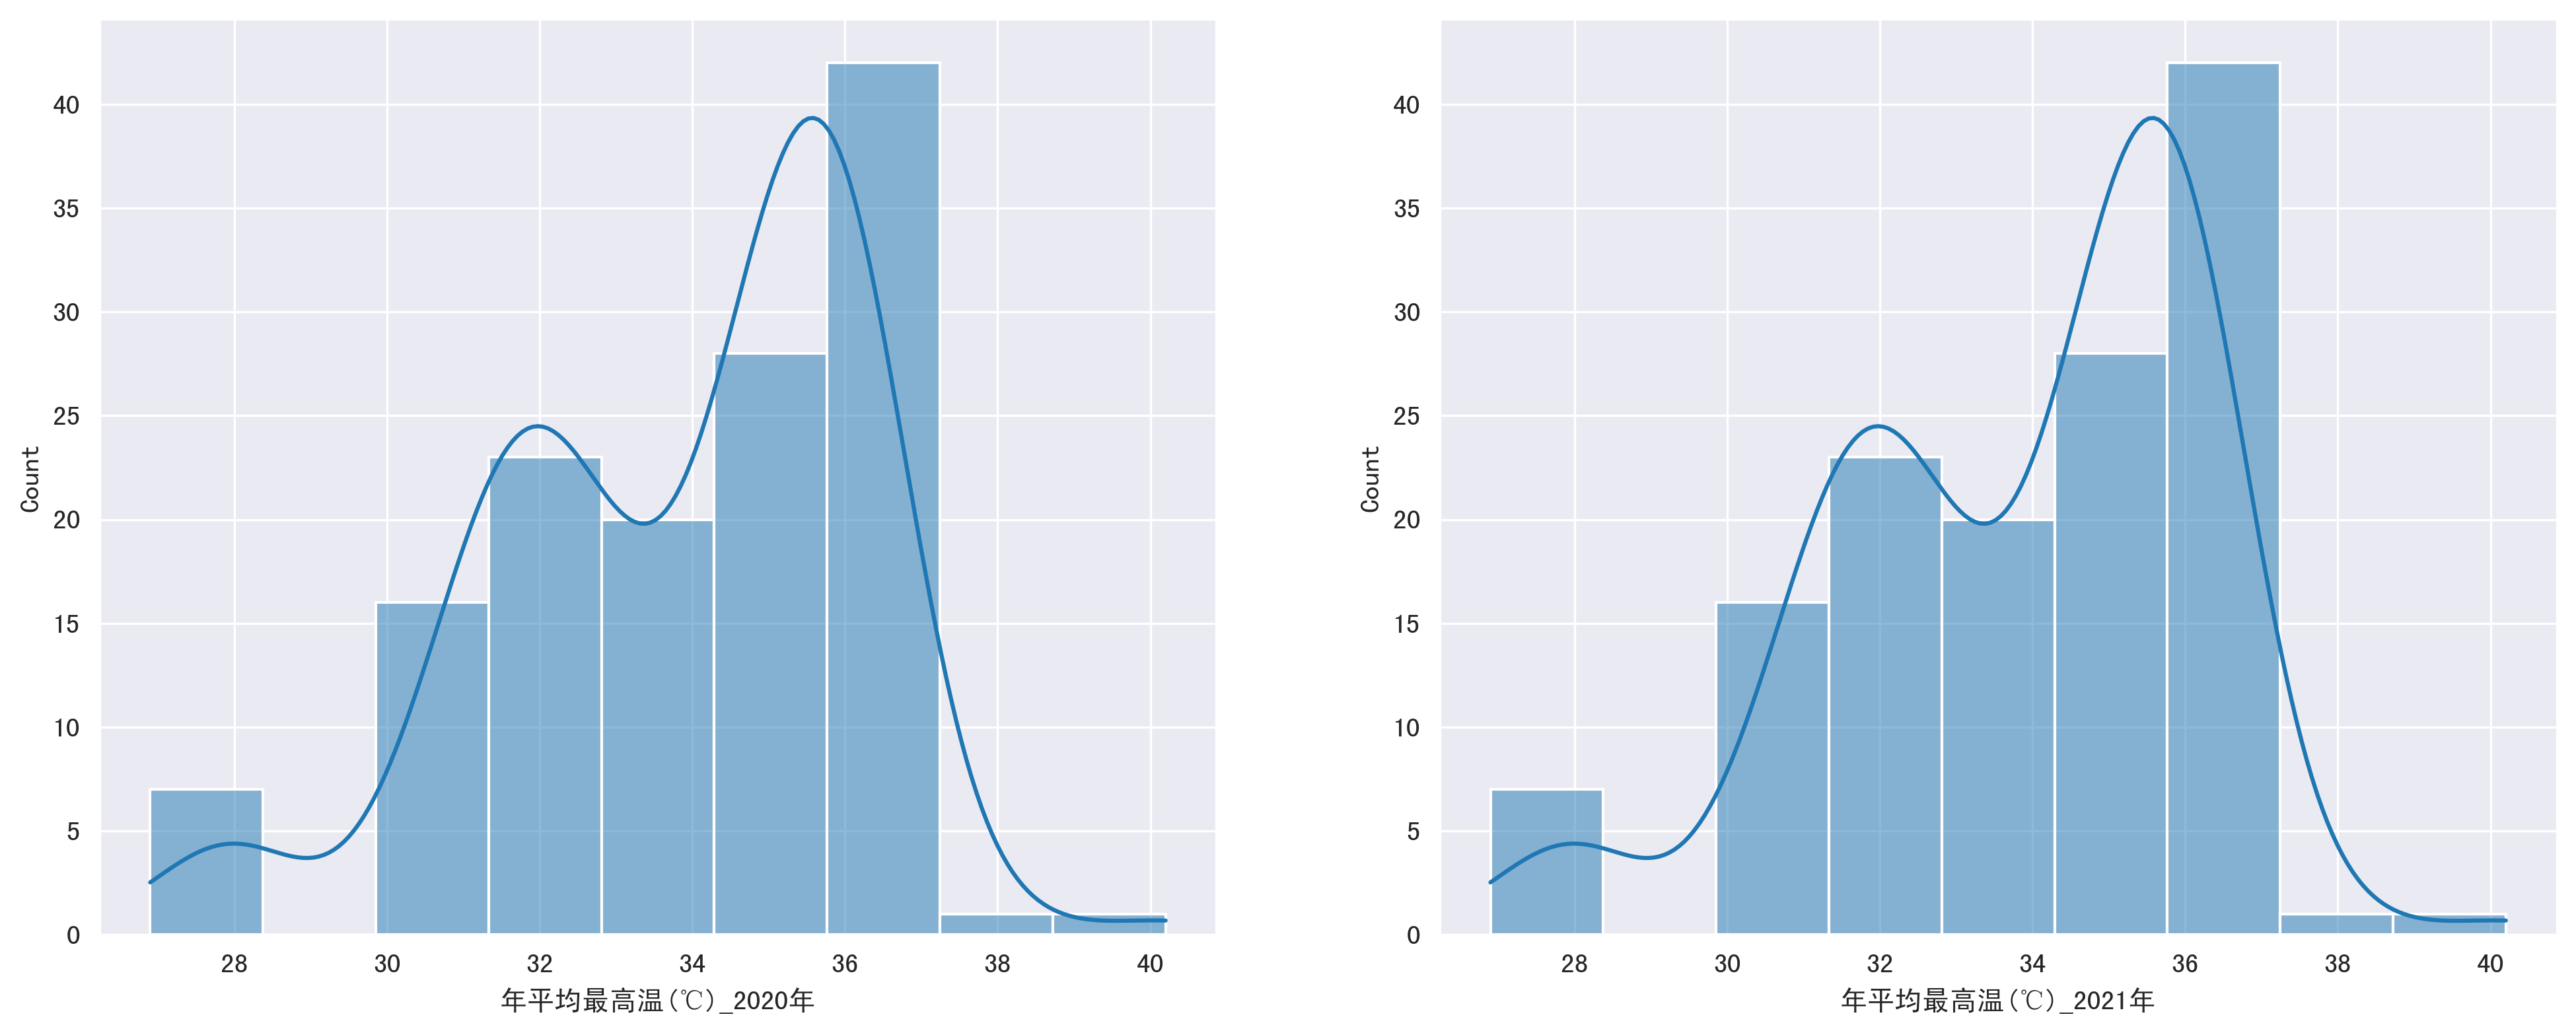

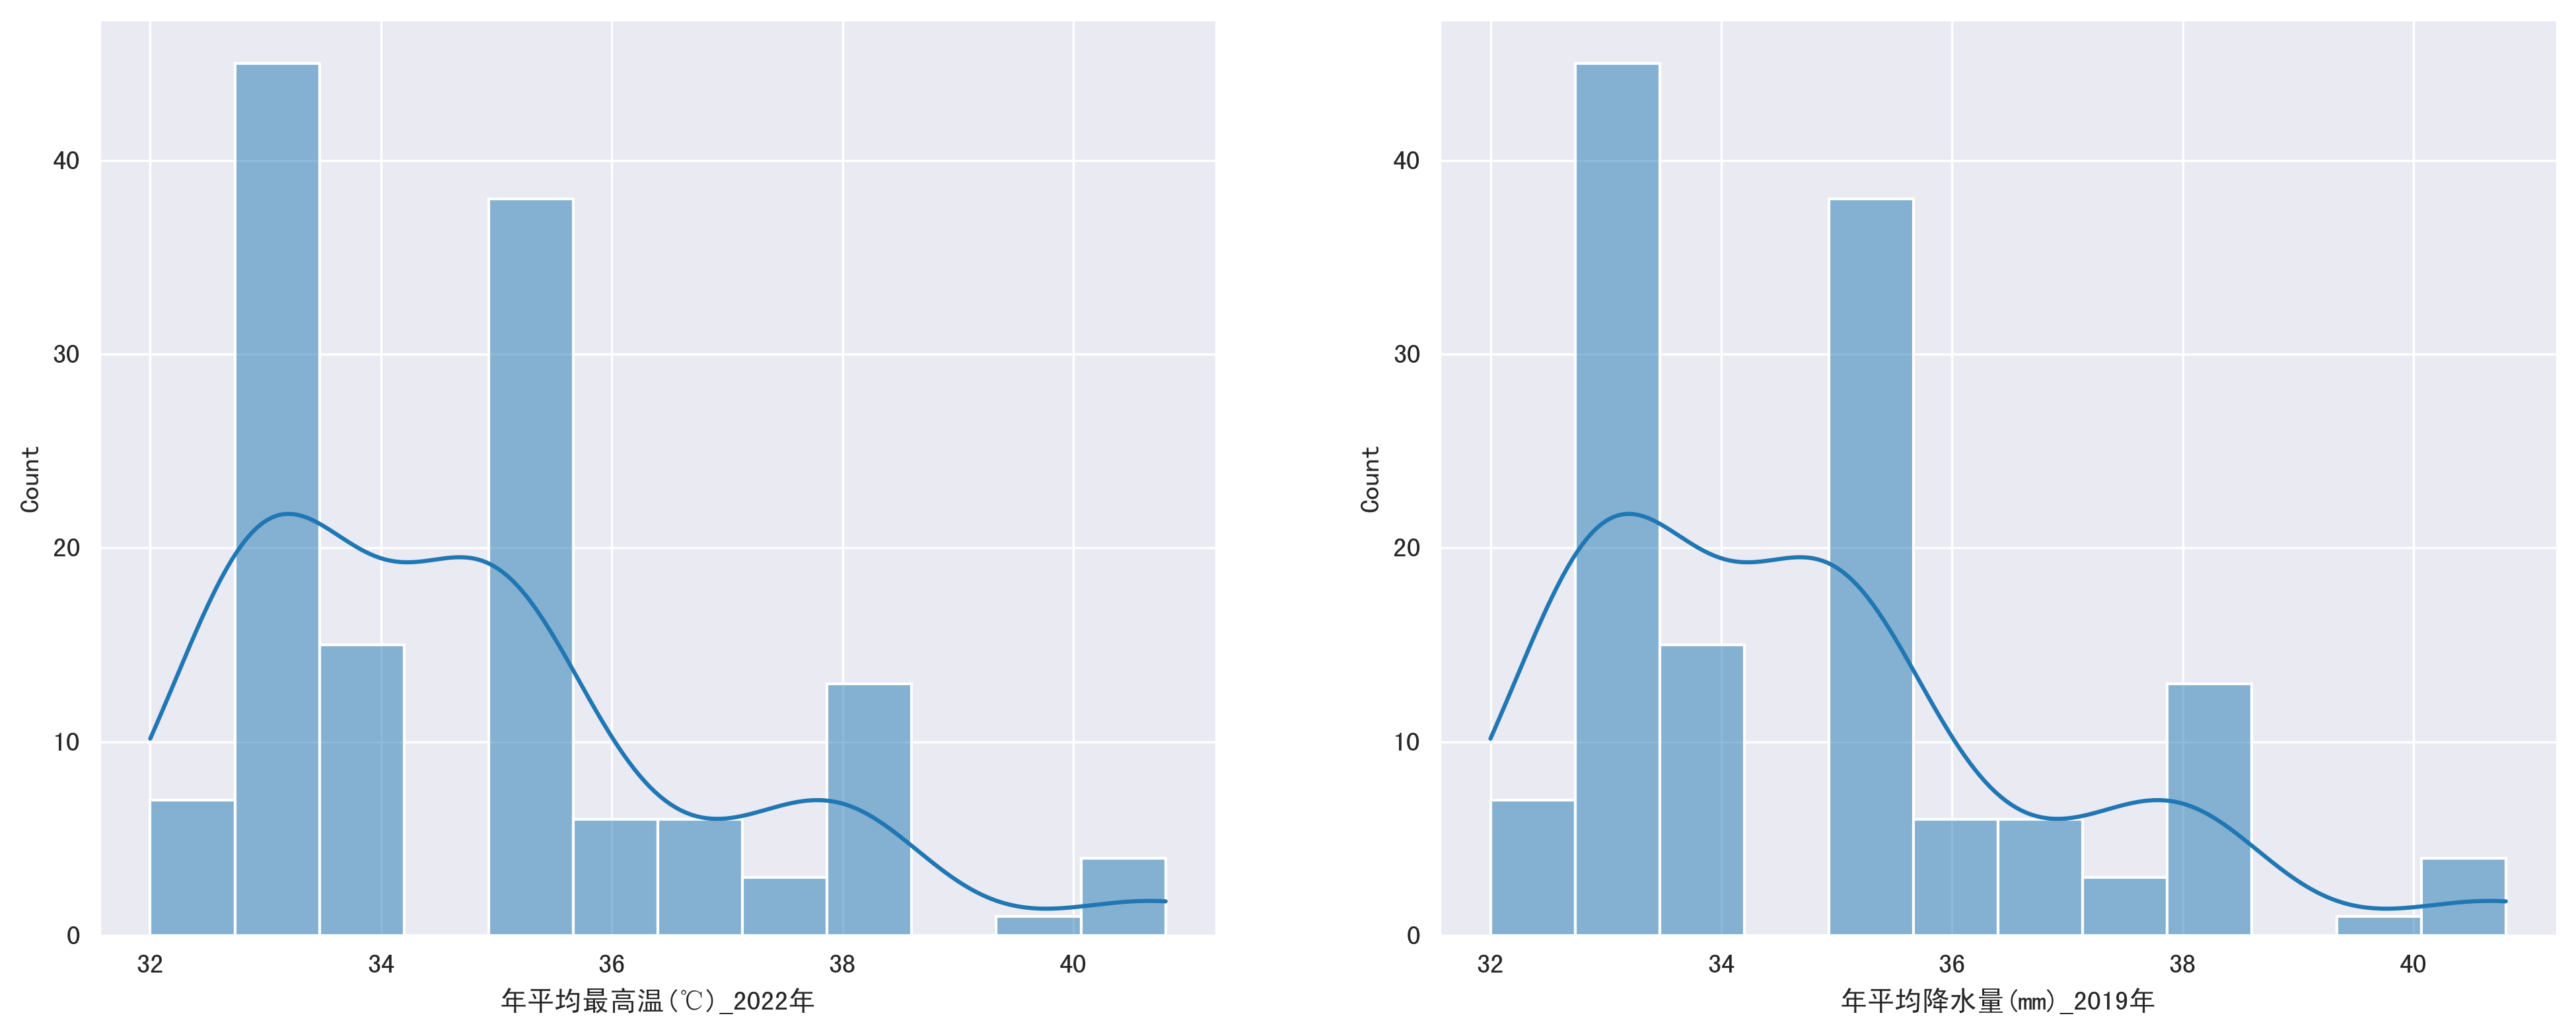

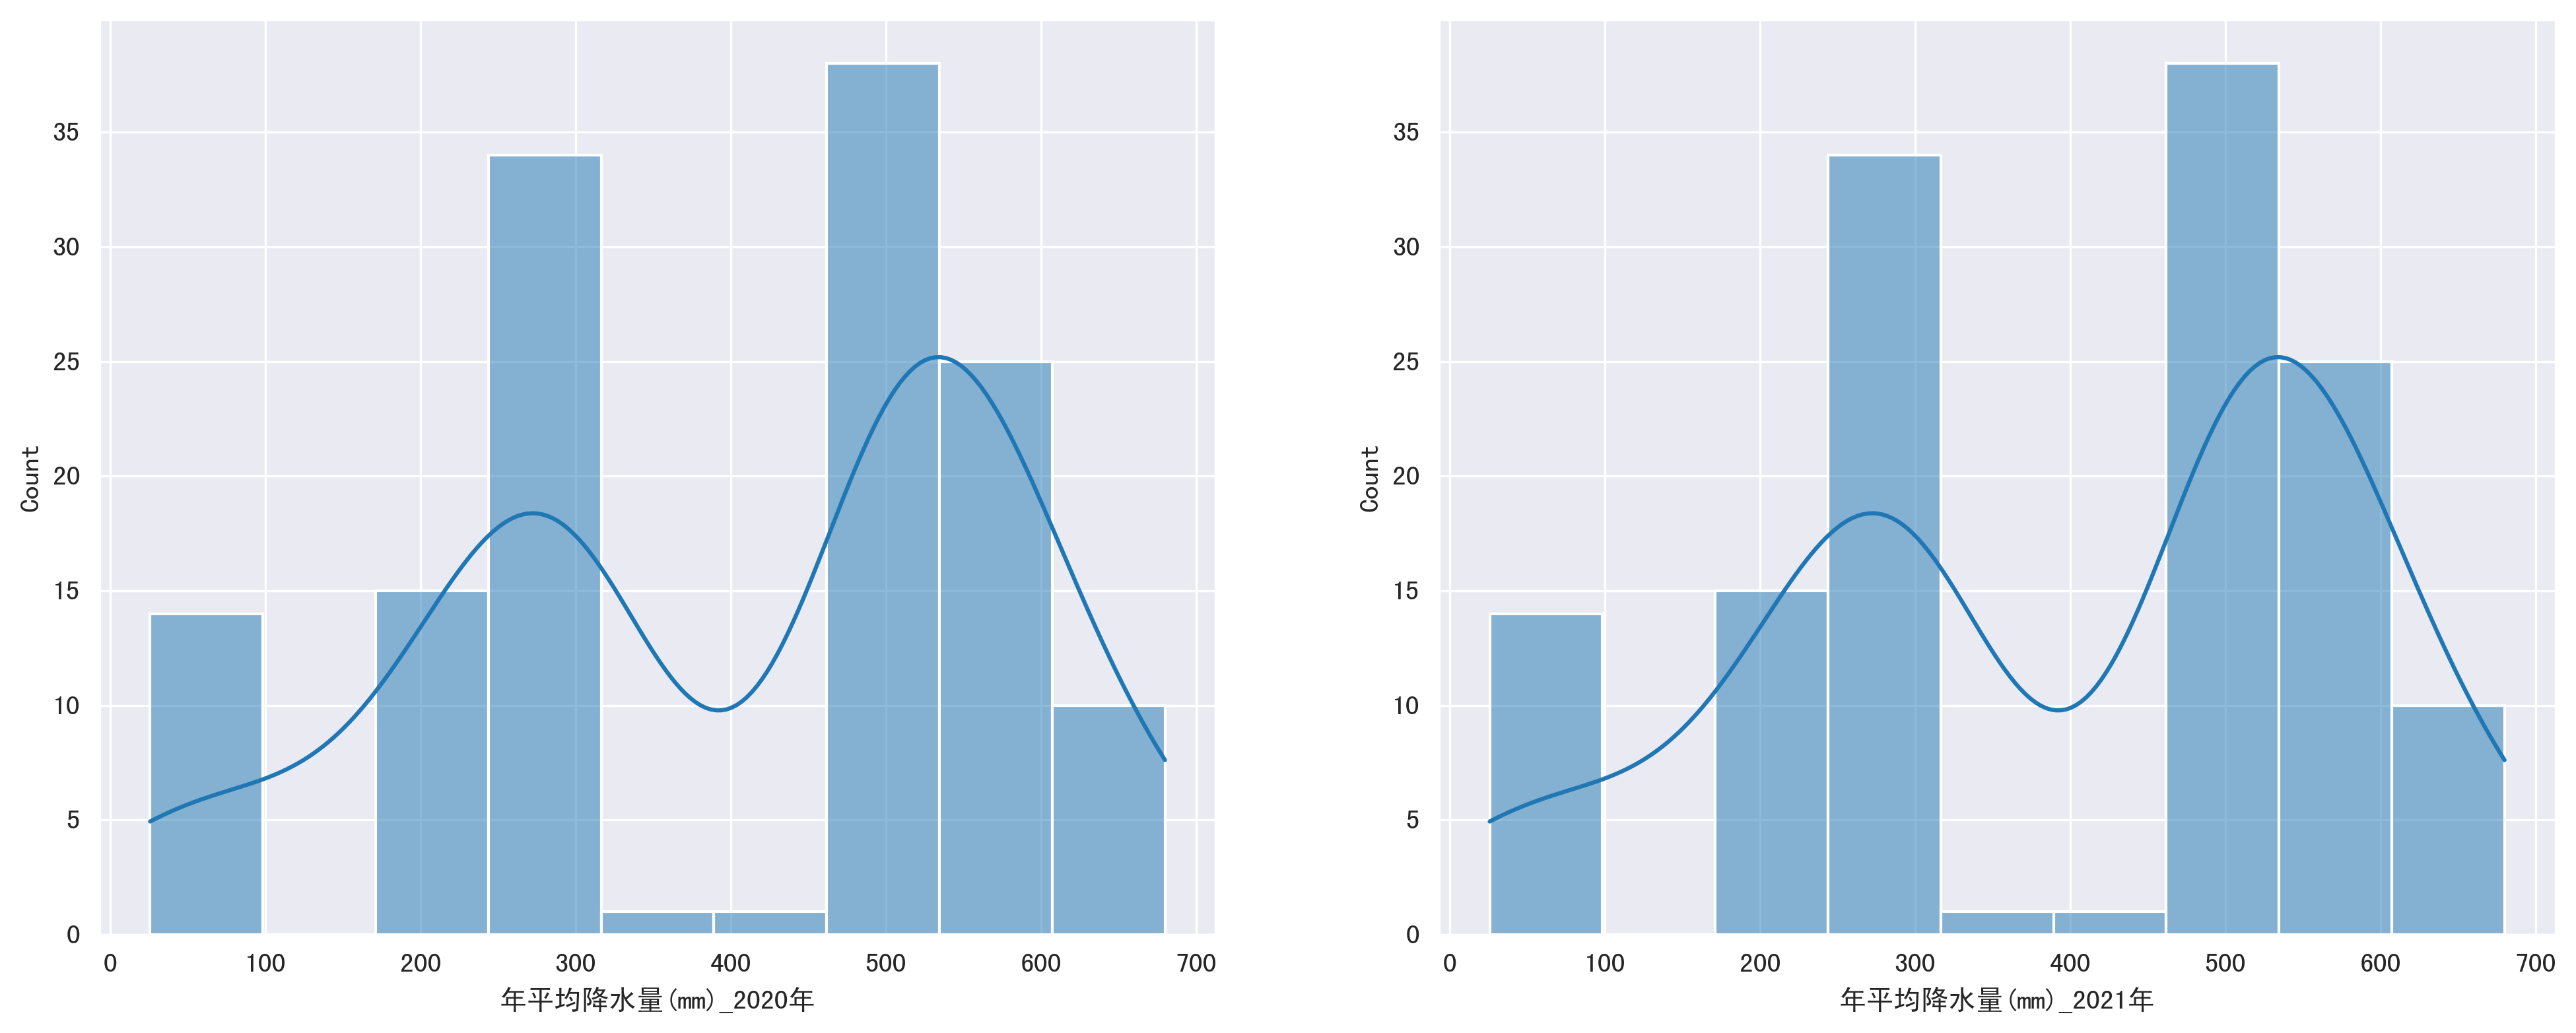

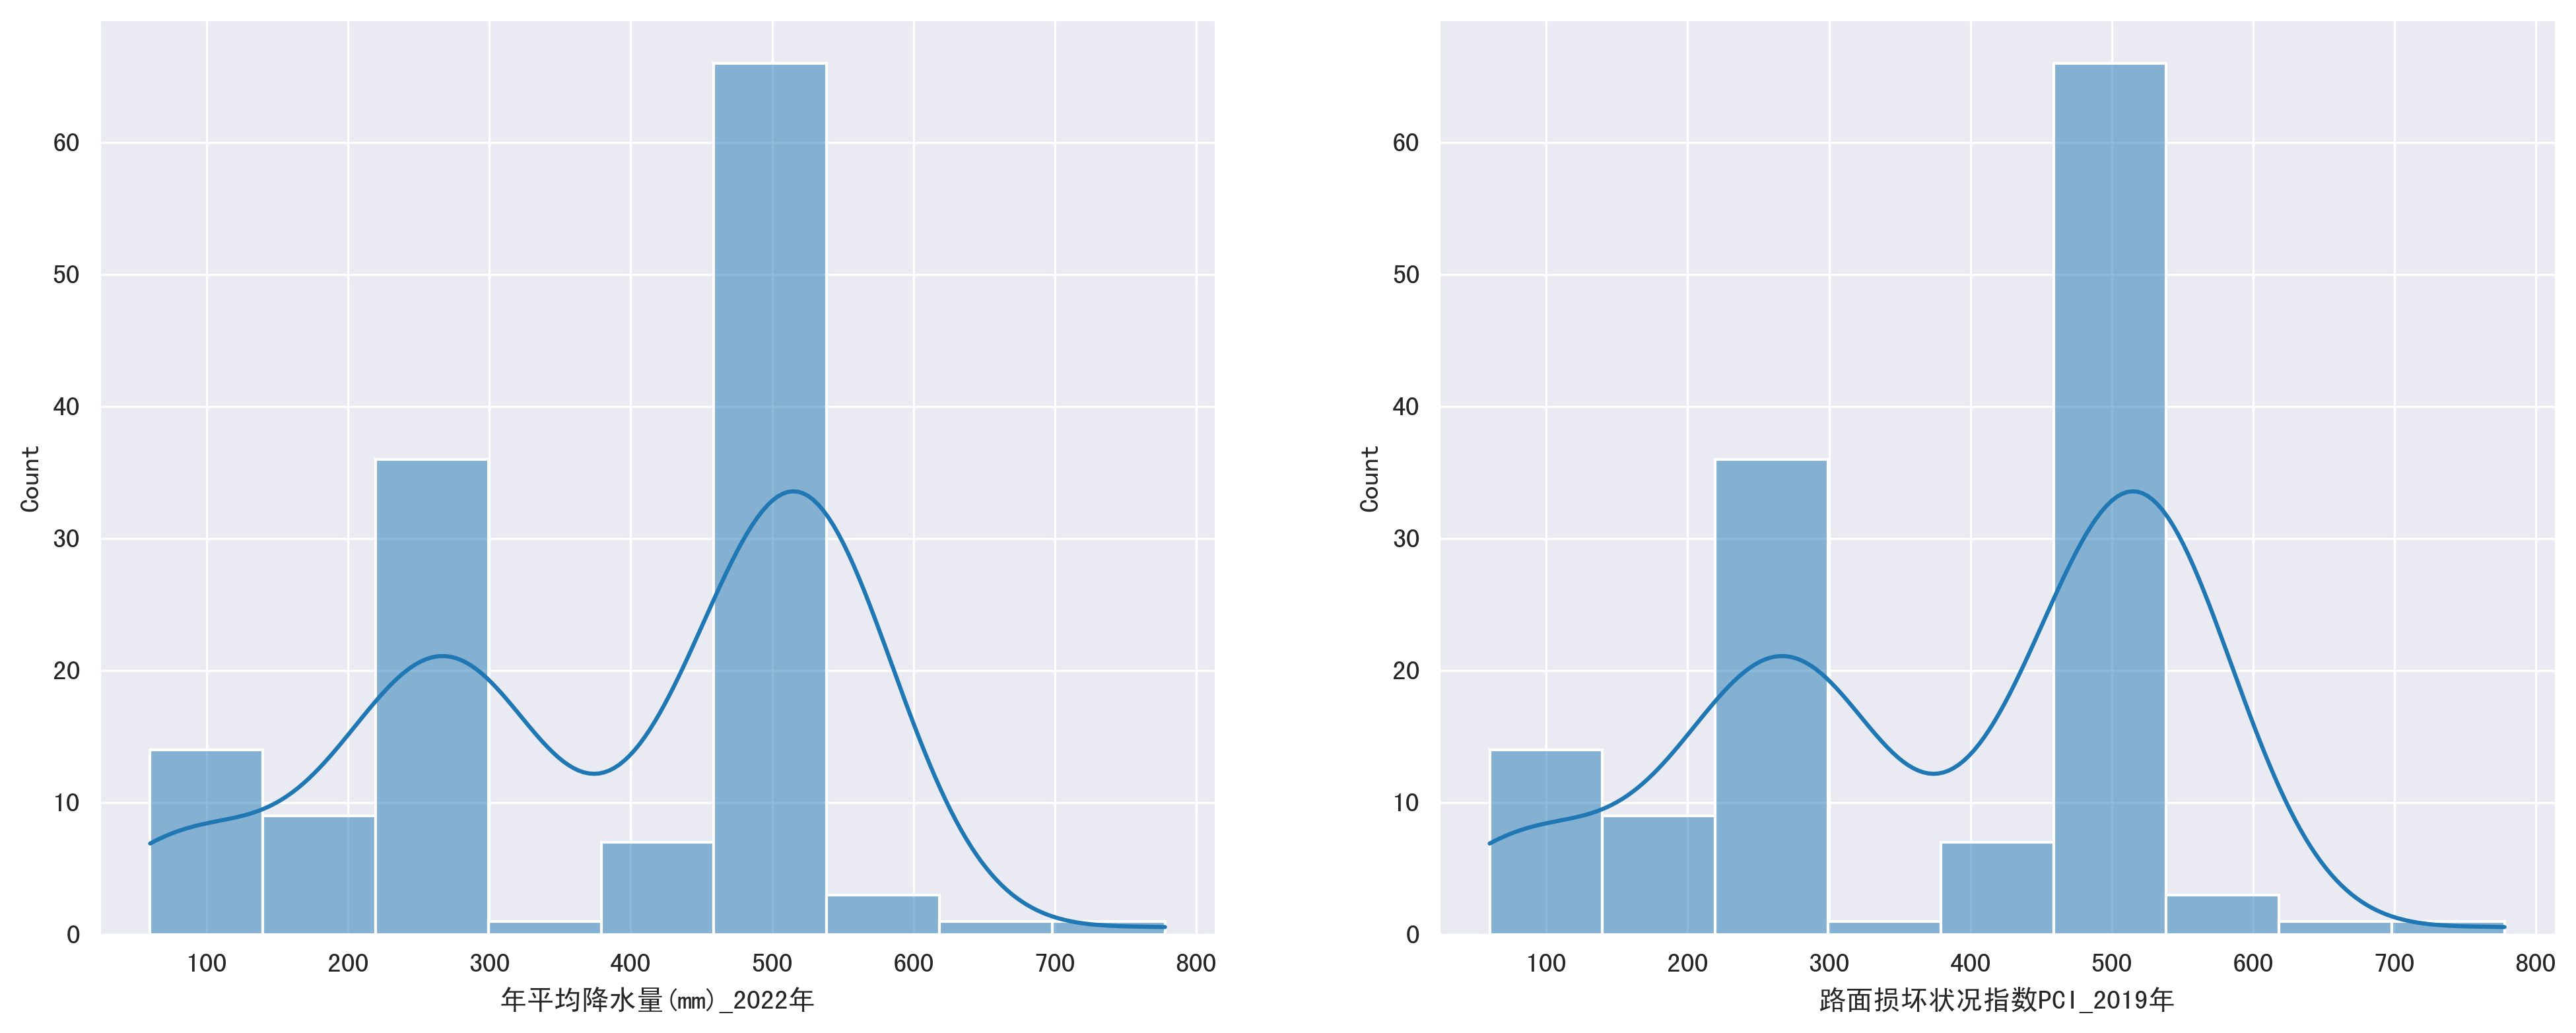

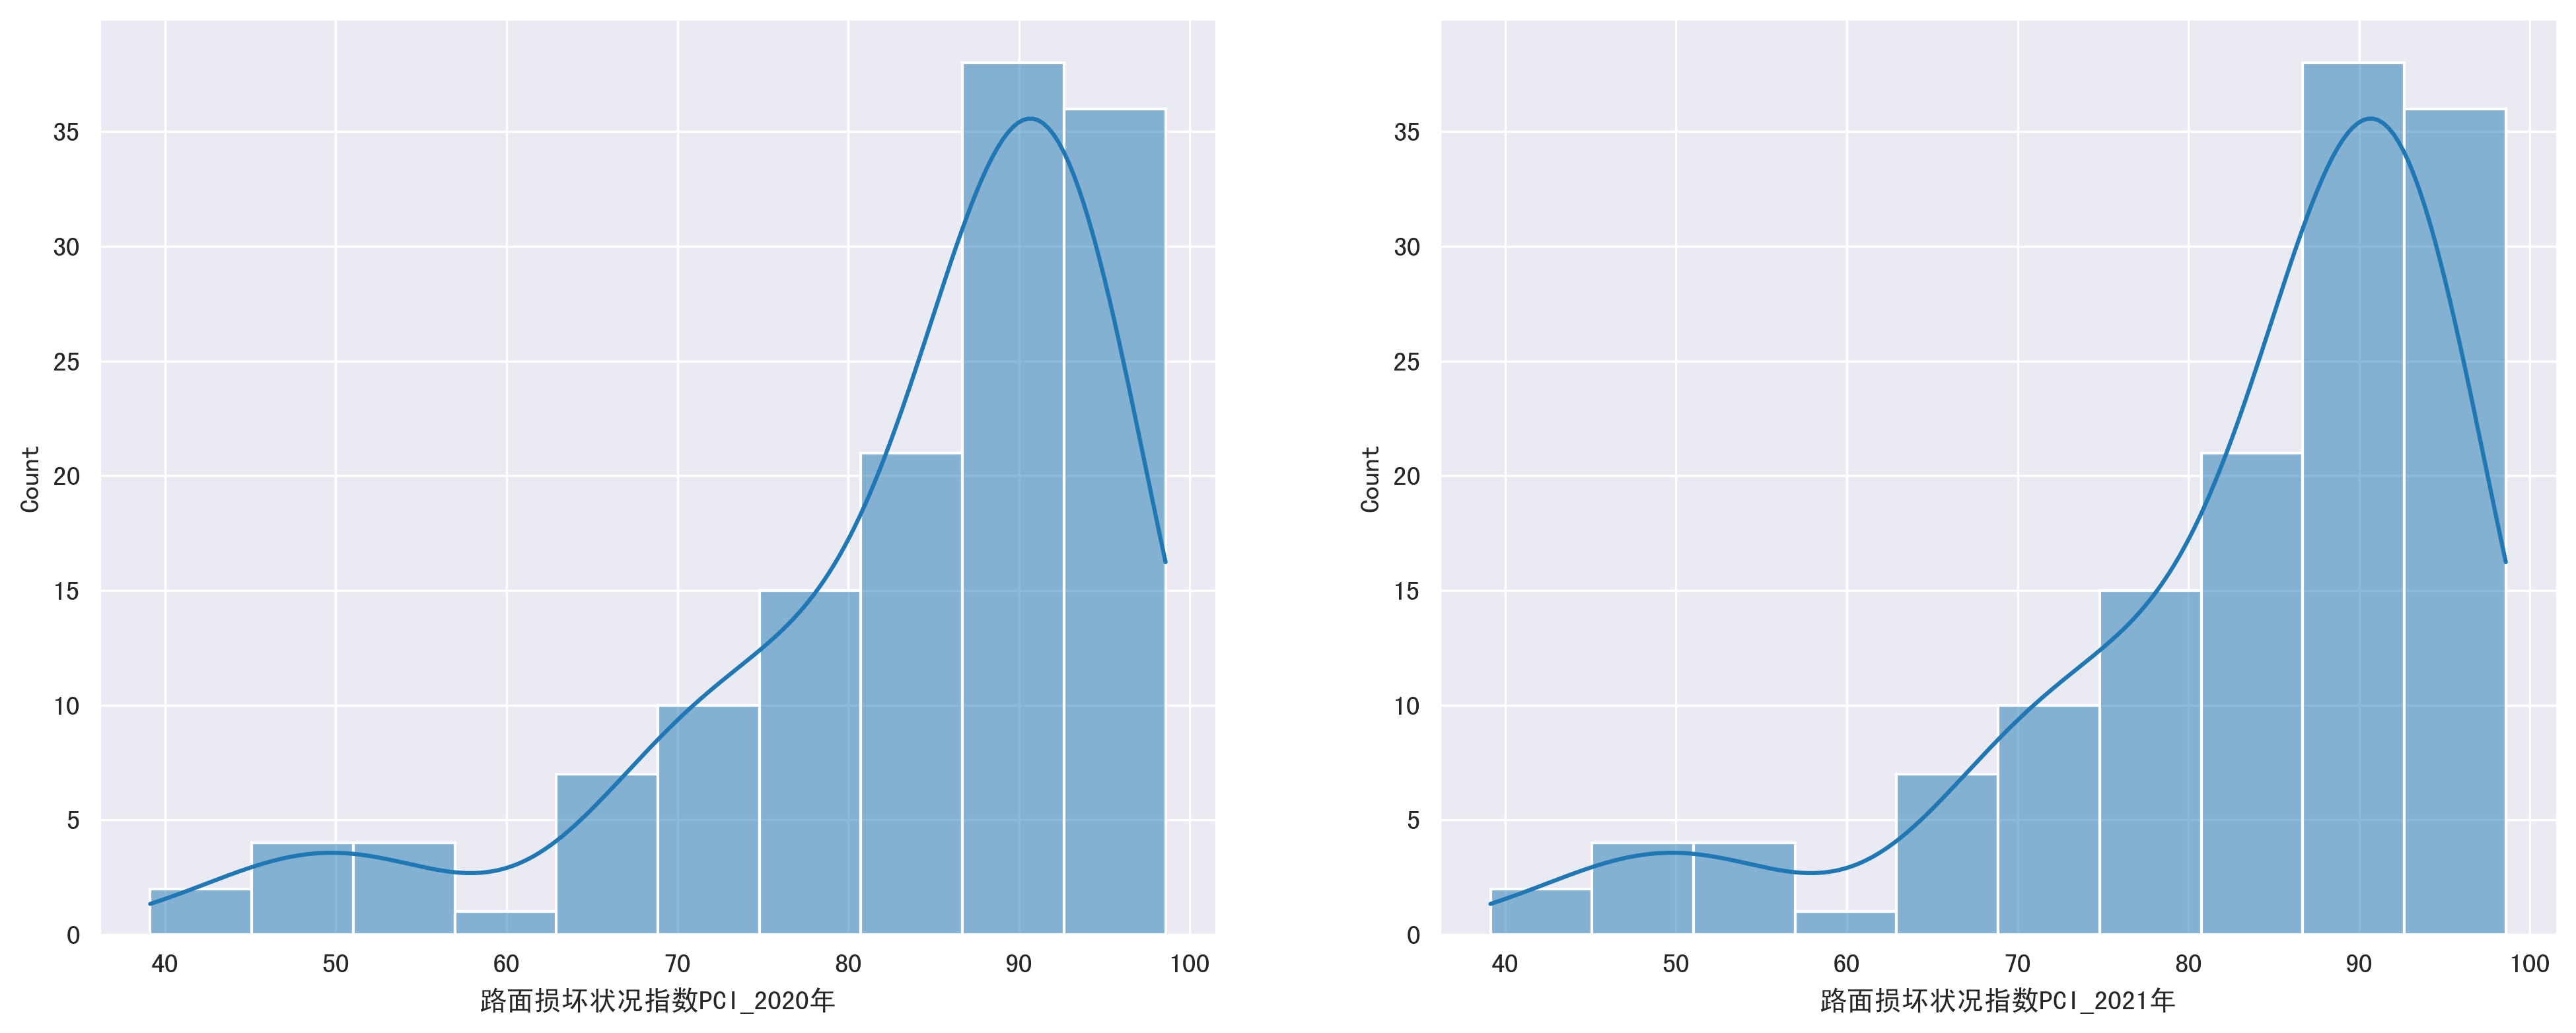

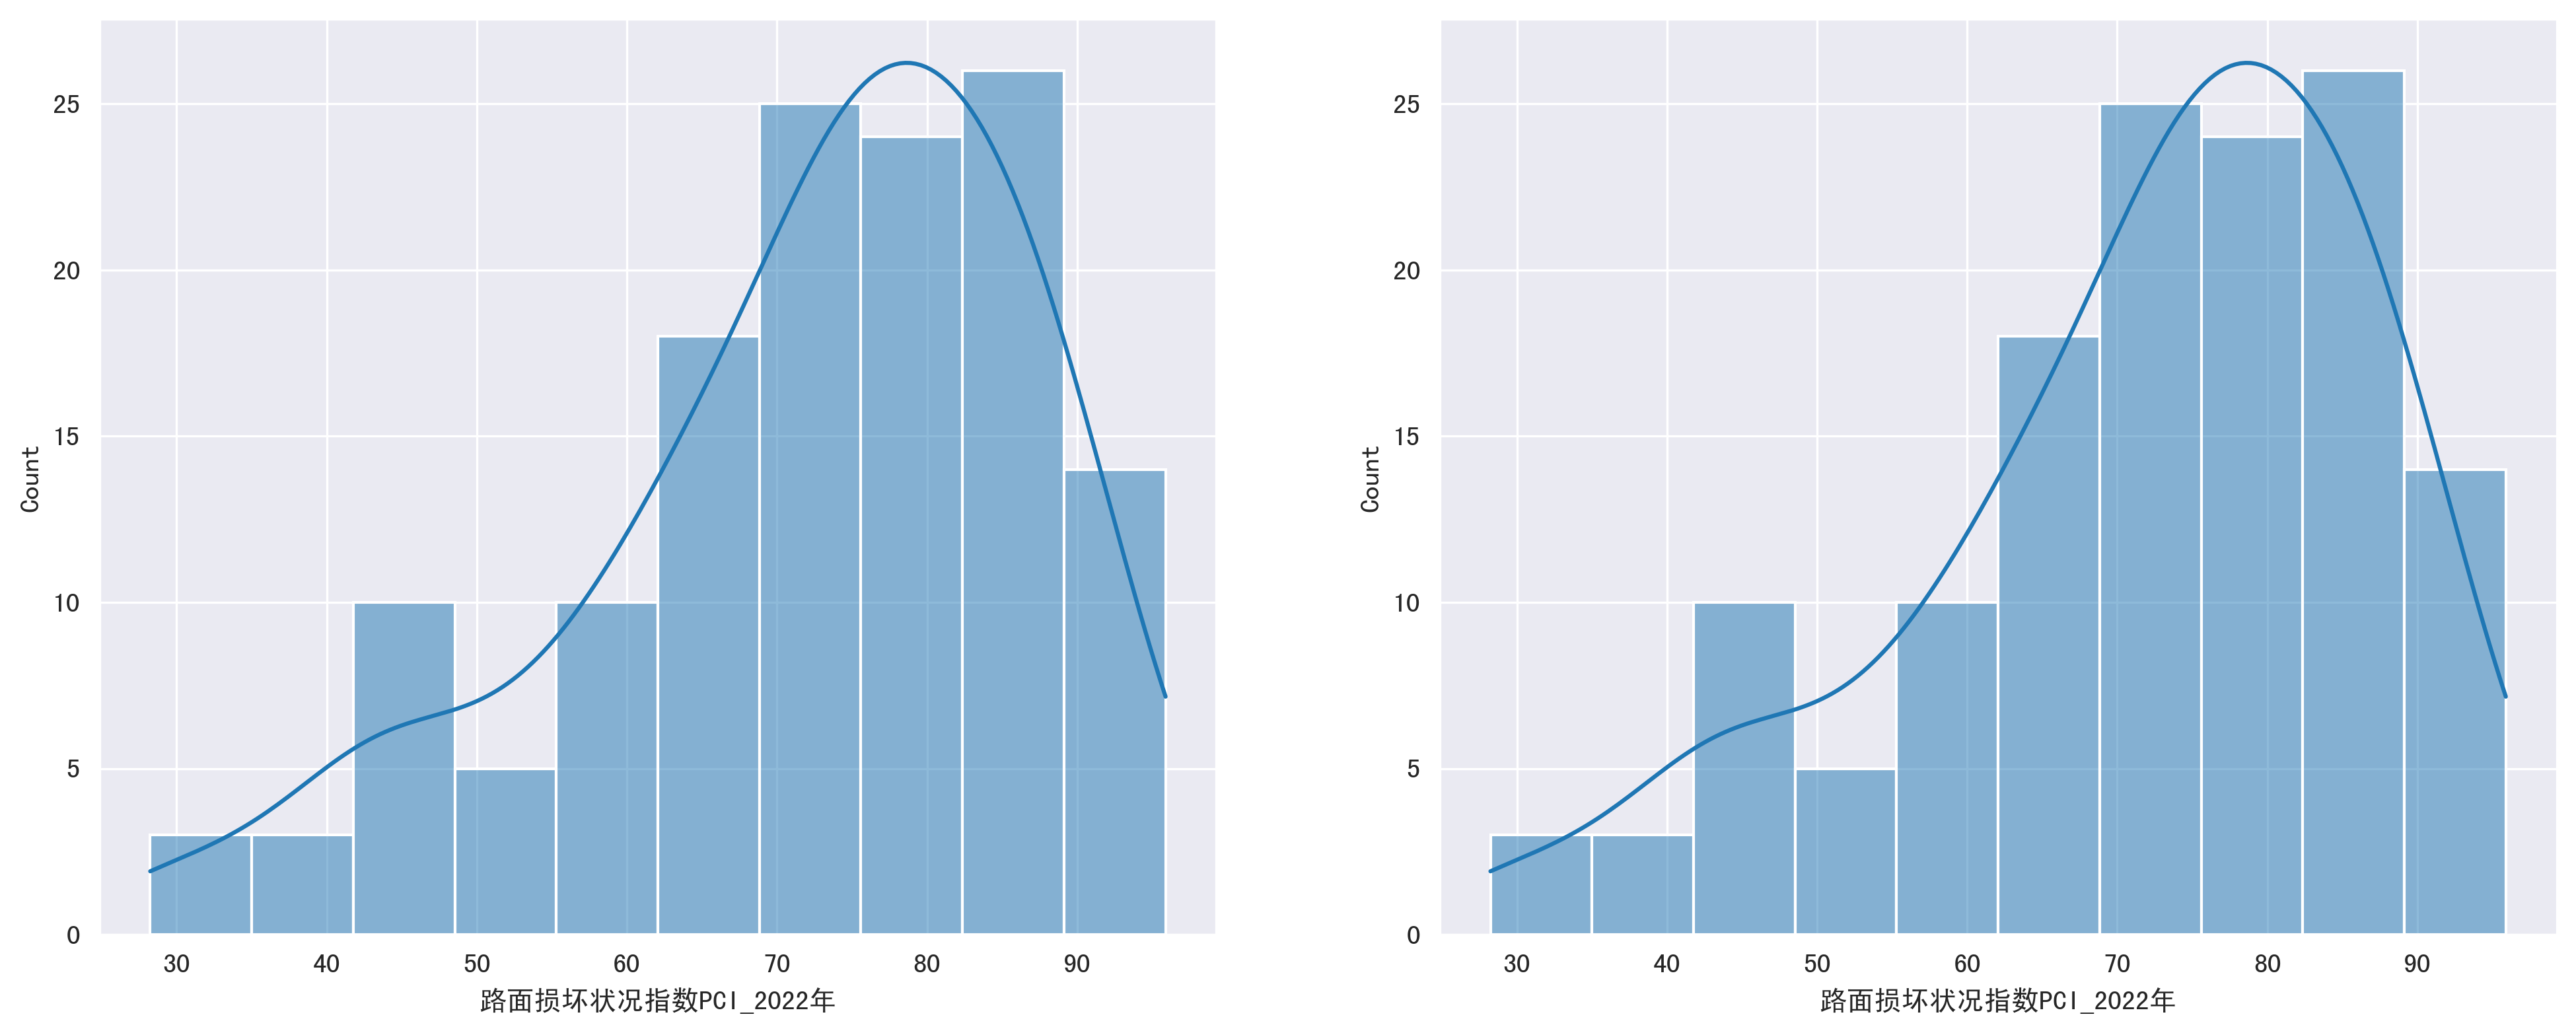

In [19]:
# 直方图查看异常值
for i in list(range(0,24,2)):
    plt.figure(figsize=(16, 6), dpi=300) # 画布长宽、清晰度
    for j in list(range(i,i+2,1)):
        plt.subplot(1,2,j+1-i)
        sns.histplot (filtered_df[ll[i]], kde=True)
        plt.xlabel(ll[j])

# 三、聚类
聚类变量为所有七个气候变量、四年不一样的（最低温, 最高温和降水量）取均值、全部都归一化，k-means聚类 

In [20]:
# 指定要计算均值的列, 这里只需要计算最低温, 最高温和降水量这三个因素的均值
columns_lowtemp = list(filter(lambda element: "最低温" in element, rename_list))
                # ['年平均最低温(℃)_2019年', '年平均最低温(℃)_2020年', '年平均最低温(℃)_2021年', '年平均最低温(℃)_2022年']
columns_hightemp = list(filter(lambda element: "最高温" in element, rename_list))
                # ['年平均最高温(℃)_2019年', '年平均最高温(℃)_2020年', '年平均最高温(℃)_2021年', '年平均最高温(℃)_2022年']
columns_precip = list(filter(lambda element: "降水量" in element, rename_list))
                # ['年平均降水量(mm)_2019年','年平均降水量(mm)_2020年','年平均降水量(mm)_2021年','年平均降水量(mm)_2022年']
# 最低温, 最高温和降水量这三个因素的均值加入表格
filtered_df['avg_lowtemp'] = filtered_df[columns_lowtemp].mean(axis=1)
filtered_df['avg_hightemp'] = filtered_df[columns_hightemp].mean(axis=1)
filtered_df['avg_precip'] = filtered_df[columns_precip].mean(axis=1)
filtered_df

,个体编号,路线编号,起讫桩号,起讫桩号(P),年霜冻期(天),季节冻土层厚度(cm),年平均日照时长(h),年平均交通量(辆)_2019年,年平均交通量(辆)_2020年,年平均交通量(辆)_2021年,...,年平均降水量(mm)_2020年,年平均降水量(mm)_2021年,年平均降水量(mm)_2022年,路面损坏状况指数PCI_2019年,路面损坏状况指数PCI_2020年,路面损坏状况指数PCI_2021年,路面损坏状况指数PCI_2022年,avg_lowtemp,avg_hightemp,avg_precip
10,11,G109,1635~1640,1639~1640,182,75,2446.0,3385.0,3213.0,3472.0,...,263.0,266.0,266.0,91.20,89.50,83.90,78.74,-15.50,36.75,263.25
12,13,G109,1650.508~1657,1652~1653,182,75,2446.0,3385.0,2926.0,3064.0,...,263.0,266.0,266.0,94.20,90.60,87.02,85.19,-15.50,36.75,263.25
13,14,G109,1650.508~1657,1653~1654,182,75,2446.0,3385.0,2926.0,3064.0,...,263.0,266.0,266.0,93.96,92.84,88.41,85.88,-15.50,36.75,263.25
14,15,G109,1650.508~1657,1654~1655,182,75,2446.0,3385.0,2926.0,3064.0,...,263.0,266.0,266.0,92.58,90.36,87.00,81.26,-15.50,36.75,263.25
15,16,G109,1650.508~1657,1655~1656,182,75,2446.0,3385.0,2926.0,3064.0,...,263.0,266.0,266.0,91.60,90.12,86.40,82.48,-15.50,36.75,263.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,402,G568,230~238,230~231,309,150,2296.0,8091.0,8102.0,8273.0,...,508.0,516.0,510.0,92.70,85.42,84.28,79.84,-15.75,29.50,509.75
402,403,G568,230~238,231~232,309,150,2296.0,8091.0,8102.0,8273.0,...,508.0,516.0,510.0,91.63,87.24,84.98,78.44,-15.75,29.50,509.75
404,405,G568,230~238,233~234,309,150,2296.0,8091.0,8102.0,8273.0,...,508.0,516.0,510.0,92.90,89.59,83.16,82.76,-15.75,29.50,509.75
405,406,G568,230~238,234~235,309,150,2296.0,8091.0,8102.0,8273.0,...,508.0,516.0,510.0,91.63,90.26,87.14,81.21,-15.75,29.50,509.75


/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' 

根据肘部法得到的最佳聚类数量: 6


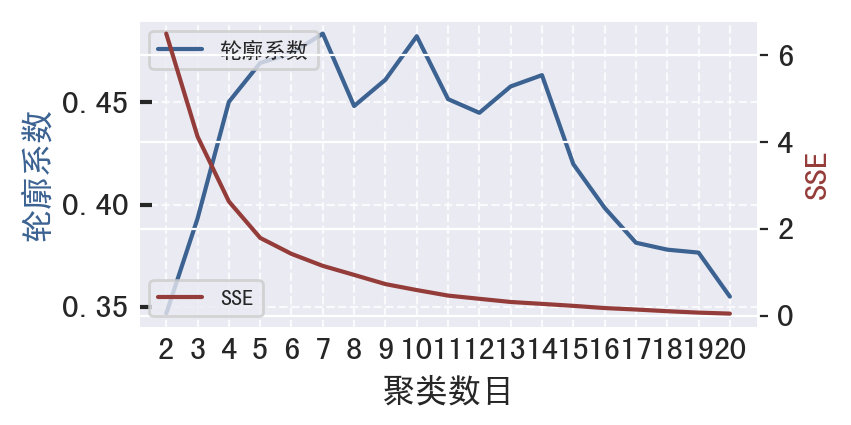

In [23]:
# 1、确定聚类元素, 归一化数据
envir_features = ["年霜冻期(天)", "季节冻土层厚度(cm)", "年平均日照时长(h)", "avg_lowtemp", "avg_hightemp","avg_precip"]
# 只有气候变量的数据表
features_ds = filtered_df[envir_features]
# 对气候变量去重的数据表，每一行的气候都不相同
features_ds_unique = features_ds.drop_duplicates(subset=None, keep='first', inplace=False)
scaler = MinMaxScaler() # 可以换成normalize()试试：sklearn中的归一化特指将单个样本（一行数据）放缩为单位范数（1范数或者2范数为单位范数）的过程，该操作常见于核方法或者衡量样本之间相似性的过程中。
scaled_features = scaler.fit_transform(features_ds_unique)
# 2、确定聚类数量
# 放轮廓系数的列表
silhouette_coefficients = []
# 放所有样本距离聚类中心的距离的总和的列表
sse = []
MAX_CLUSTER = 21
num_clusters = list(range(2, MAX_CLUSTER))
for k in range(2, MAX_CLUSTER):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled_features)
    s_score = silhouette_score(scaled_features, kmeans.labels_) # 轮廓系数
    silhouette_coefficients.append(s_score)
    sse.append(kmeans.inertia_) # 所有样本距离聚类中心的距离的总和
kl = KneeLocator(num_clusters, sse, curve="convex", direction="decreasing")
print("根据肘部法得到的最佳聚类数量: %d" % kl.elbow)
# 设置全局字体为Times New Roman，字体大小为18，轴宽度为2
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['font.sans-serif'] = ['SimHei']
# 设置图例标题大小
plt.rcParams['legend.title_fontsize'] = 9
fig, ax1 = plt.subplots(figsize=(4, 2), dpi=200)
colors = ["#3b6291", "#943c39"]
legend = ['轮廓系数', 'SSE']
ax1.plot(num_clusters, silhouette_coefficients, color=colors[0], label=legend[0])
ax1.set_xlabel('聚类数目')
ax1.set_ylabel('轮廓系数', color=colors[0])
plt.xticks(num_clusters)
ax2 = ax1.twinx()
ax2.plot(num_clusters, sse, color=colors[1], label=legend[1])
ax2.set_ylabel('SSE', color=colors[1])
# 修改刻度属性
ax1.tick_params(which='major', length=5, width=1.5, direction='in')
ax1.tick_params(which='minor', length=3, width=1, direction='in')
# 添加网格
ax1.grid(which='major', ls='--', alpha=.8, lw=.8)
# 添加图例
ax1.legend(fontsize=8, loc='upper left', title="")
ax2.legend(fontsize=8, loc='lower left', title="")
# 添加文本信息
ax1.set_title("", fontsize=14, pad=10)
# plt.savefig('image/kmeans.png', dpi=300)
plt.show()

## 开始聚类，把类别放入表格中

In [24]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(scaled_features)
result = kmeans.predict(scaled_features) # 聚类结果
features_ds_unique["cluster"] = result # 去重的气候数据表多了一个聚类的列
cluster_data = pd.merge(filtered_df, features_ds_unique, on=envir_features, how='left') # 所有数据表和去重的气候数据表左链接，那么所有数据表就有了聚类这一列
cluster_data = cluster_data.sort_values(by=['cluster', '路线编号', '起讫桩号', '起讫桩号(P)'])
cluster_data = cluster_data.drop('个体编号', axis=1)
cluster_data = cluster_data.reset_index(drop=True)
cluster_data.to_excel("/Users/yy/PycharmProjects/pythonProject/excel/cluster.xlsx")
cluster_data

/Users/yy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,路线编号,起讫桩号,起讫桩号(P),年霜冻期(天),季节冻土层厚度(cm),年平均日照时长(h),年平均交通量(辆)_2019年,年平均交通量(辆)_2020年,年平均交通量(辆)_2021年,年平均交通量(辆)_2022年,...,年平均降水量(mm)_2021年,年平均降水量(mm)_2022年,路面损坏状况指数PCI_2019年,路面损坏状况指数PCI_2020年,路面损坏状况指数PCI_2021年,路面损坏状况指数PCI_2022年,avg_lowtemp,avg_hightemp,avg_precip,cluster
0,G211,325~331,325~326,198,53,2445.0,21265.0,18159.0,15224.0,11859.0,...,520.0,537.0,76.11,70.11,65.82,47.54,-15.00,35.0,526.00,0
1,G211,325~331,327~328,198,53,2445.0,21265.0,18159.0,15224.0,11859.0,...,520.0,537.0,75.70,67.51,62.60,59.03,-15.00,35.0,526.00,0
2,G211,325~331,328~329,198,53,2445.0,21265.0,18159.0,15224.0,11859.0,...,520.0,537.0,79.80,71.58,63.52,54.03,-15.00,35.0,526.00,0
3,G211,336~349,336~337,198,53,2445.0,21265.0,18159.0,15224.0,11859.0,...,520.0,537.0,87.90,52.43,47.05,43.04,-15.00,35.0,526.00,0
4,G211,336~349,339~340,198,53,2445.0,21265.0,18159.0,15224.0,11859.0,...,520.0,537.0,67.14,51.35,48.88,47.98,-15.00,35.0,526.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,G312,2279~2294,2289~2290,121,120,2446.0,20128.0,19659.0,18324.0,15983.0,...,290.0,290.0,95.42,84.00,75.82,66.93,-20.25,32.0,291.75,5
134,G312,2279~2294,2290~2291,121,120,2446.0,20128.0,19659.0,18324.0,15983.0,...,290.0,290.0,95.44,90.32,83.65,76.54,-20.25,32.0,291.75,5
135,G312,2279~2294,2291~2292,121,120,2446.0,20128.0,19659.0,18324.0,15983.0,...,290.0,290.0,95.02,90.21,84.58,79.96,-20.25,32.0,291.75,5
136,G312,2279~2294,2292~2293,121,120,2446.0,20128.0,19659.0,18324.0,15983.0,...,290.0,290.0,95.52,91.41,89.66,87.06,-20.25,32.0,291.75,5


# 四、生成训练集和测试集
聚类结果、type：19-20/19-21、交通量（对数化） 、初始pci是自变量、末年pci是因变量
## 1、训练数据取中位数
19-20的：同一类路段中，19年交通量一摸一样的几条路段（也是其他气候变量一摸一样的），19-20的pci，取中位数，成为一条数据
19-21：19和20的交通量相加后，同上，一摸一样

### （1）2019年--2020年

In [59]:
median_20_df = cluster_data[  
    ['cluster', '路线编号', '起讫桩号', '起讫桩号(P)', '年霜冻期(天)','季节冻土层厚度(cm)','年平均日照时长(h)','年平均交通量(辆)_2019年', '年平均最低温(℃)_2019年','年平均最高温(℃)_2019年','年平均降水量(mm)_2019年','路面损坏状况指数PCI_2019年',
     '路面损坏状况指数PCI_2020年']
] # 我觉得应该用19年交通量
median_20_df['diff'] = median_20_df['路面损坏状况指数PCI_2019年'] - median_20_df['路面损坏状况指数PCI_2020年']
median_df = median_20_df.sort_values(by=['cluster', '路线编号', '起讫桩号', 'diff'])
median_df

,cluster,路线编号,起讫桩号,起讫桩号(P),年霜冻期(天),季节冻土层厚度(cm),年平均日照时长(h),年平均交通量(辆)_2019年,年平均最低温(℃)_2019年,年平均最高温(℃)_2019年,年平均降水量(mm)_2019年,路面损坏状况指数PCI_2019年,路面损坏状况指数PCI_2020年,diff
0,0,G211,325~331,325~326,198,53,2445.0,21265.0,-17.0,34.0,537.0,76.11,70.11,6.00
1,0,G211,325~331,327~328,198,53,2445.0,21265.0,-17.0,34.0,537.0,75.70,67.51,8.19
2,0,G211,325~331,328~329,198,53,2445.0,21265.0,-17.0,34.0,537.0,79.80,71.58,8.22
9,0,G211,336~349,345~346,198,53,2445.0,21265.0,-17.0,34.0,537.0,51.88,48.72,3.16
12,0,G211,336~349,348~349,198,53,2445.0,21265.0,-17.0,34.0,537.0,43.04,39.14,3.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,5,G312,2279~2294,2287~2288,121,120,2446.0,20128.0,-19.0,32.0,294.0,97.34,90.57,6.77
126,5,G312,2279~2294,2282~2283,121,120,2446.0,20128.0,-19.0,32.0,294.0,89.44,80.68,8.76
123,5,G312,2279~2294,2279~2280,121,120,2446.0,20128.0,-19.0,32.0,294.0,80.62,71.22,9.40
128,5,G312,2279~2294,2284~2285,121,120,2446.0,20128.0,-19.0,32.0,294.0,87.36,77.32,10.04


In [60]:
# 自定义聚合函数，计算中位数并选择中间位置的两个样本(PCI要不要也取中位数？)
def custom_agg_middle_samples(x):
    median_var2 = x['diff'].median()
    if len(x) % 2 == 0:  # 如果样本数量为偶数
        middle_samples = x.iloc[(x['diff'] - median_var2).abs().argsort()[:2]]
    else:  # 如果样本数量为奇数
        middle_samples = x.iloc[(x['diff'] - median_var2).abs().argsort()[:1]]
    return middle_samples

In [61]:
# 使用 groupby 和自定义聚合函数来处理数据  # 咋回事，717的交通量还是两个？？
result_df = median_df.groupby(['cluster', '年平均交通量(辆)_2019年']).apply(custom_agg_middle_samples).reset_index(
    drop=True)
result_df

,cluster,路线编号,起讫桩号,起讫桩号(P),年霜冻期(天),季节冻土层厚度(cm),年平均日照时长(h),年平均交通量(辆)_2019年,年平均最低温(℃)_2019年,年平均最高温(℃)_2019年,年平均降水量(mm)_2019年,路面损坏状况指数PCI_2019年,路面损坏状况指数PCI_2020年,diff
0,0,G316,2547~2559,2549~2550,182,61,1968.1,2670.0,-11.0,33.0,488.2,97.54,93.74,3.80
1,0,G316,2547~2559,2552~2553,182,61,1968.1,2670.0,-11.0,33.0,488.2,91.24,86.64,4.60
2,0,G244,681~687,686~687,143,38,1968.0,3680.0,-16.8,38.5,575.4,72.02,68.01,4.01
3,0,G327,1511~1516,1514~1515,190,74,2465.0,5063.0,-17.0,34.0,589.0,76.02,75.80,0.22
4,0,G327,1511~1516,1513~1514,190,74,2465.0,5063.0,-17.0,34.0,589.0,76.83,74.30,2.53
5,0,G566,158~162,159~160,142,30,2179.0,5432.0,-13.0,33.0,412.0,76.64,74.63,2.01
6,0,G244,475~479,478~479,195,62,2450.0,7052.0,-19.0,32.0,653.0,97.24,93.82,3.42
7,0,G327,1418~1429.643,1426~1427,197,86,2369.0,7786.0,-18.0,35.0,566.0,82.86,80.30,2.56
8,0,G327,1418~1429.643,1421~1422,197,86,2369.0,7786.0,-18.0,35.0,566.0,85.52,82.89,2.63
9,0,G211,355.576~363,359~360,198,53,2445.0,10244.0,-17.0,34.0,537.0,98.21,92.76,5.45


In [62]:
# 不是取中位数吗，怎么这里是均值？？
# mean_pci = result_df.groupby(['cluster', '年平均交通量(辆)_2020年']).mean(['路面损坏状况指数PCI_2019年', '路面损坏状况指数PCI_2020年', 'diff']).reset_index()

In [63]:
# mean_pci

In [64]:
median_19_20 = result_df.rename(columns={'年霜冻期(天)':'shuangdong','季节冻土层厚度(cm)':'dongtu',
                                         '年平均日照时长(h)':'sunlight', '年平均最低温(℃)_2019年':'low_tmp',
                                         '年平均最高温(℃)_2019年':'high_tmp','年平均降水量(mm)_2019年':'rain',
                                         '年平均交通量(辆)_2019年': 'traffic', 
                                         '路面损坏状况指数PCI_2019年': 'PCI_0',
                                         '路面损坏状况指数PCI_2020年': 'PCI_contemp'})
median_19_20['type'] = '2019-2020(median)'
median_19_20

,cluster,路线编号,起讫桩号,起讫桩号(P),shuangdong,dongtu,sunlight,traffic,low_tmp,high_tmp,rain,PCI_0,PCI_contemp,diff,type
0,0,G316,2547~2559,2549~2550,182,61,1968.1,2670.0,-11.0,33.0,488.2,97.54,93.74,3.80,2019-2020(median)
1,0,G316,2547~2559,2552~2553,182,61,1968.1,2670.0,-11.0,33.0,488.2,91.24,86.64,4.60,2019-2020(median)
2,0,G244,681~687,686~687,143,38,1968.0,3680.0,-16.8,38.5,575.4,72.02,68.01,4.01,2019-2020(median)
3,0,G327,1511~1516,1514~1515,190,74,2465.0,5063.0,-17.0,34.0,589.0,76.02,75.80,0.22,2019-2020(median)
4,0,G327,1511~1516,1513~1514,190,74,2465.0,5063.0,-17.0,34.0,589.0,76.83,74.30,2.53,2019-2020(median)
5,0,G566,158~162,159~160,142,30,2179.0,5432.0,-13.0,33.0,412.0,76.64,74.63,2.01,2019-2020(median)
6,0,G244,475~479,478~479,195,62,2450.0,7052.0,-19.0,32.0,653.0,97.24,93.82,3.42,2019-2020(median)
7,0,G327,1418~1429.643,1426~1427,197,86,2369.0,7786.0,-18.0,35.0,566.0,82.86,80.30,2.56,2019-2020(median)
8,0,G327,1418~1429.643,1421~1422,197,86,2369.0,7786.0,-18.0,35.0,566.0,85.52,82.89,2.63,2019-2020(median)
9,0,G211,355.576~363,359~360,198,53,2445.0,10244.0,-17.0,34.0,537.0,98.21,92.76,5.45,2019-2020(median)


In [65]:
median_19_20 = median_19_20[['cluster', 'type', 'shuangdong','dongtu','sunlight','low_tmp','high_tmp','rain','traffic', 'PCI_0', 'PCI_contemp','diff']]
median_19_20
# median_19_20.to_excel("excel/temp.xlsx")

,cluster,type,shuangdong,dongtu,sunlight,low_tmp,high_tmp,rain,traffic,PCI_0,PCI_contemp,diff
0,0,2019-2020(median),182,61,1968.1,-11.0,33.0,488.2,2670.0,97.54,93.74,3.80
1,0,2019-2020(median),182,61,1968.1,-11.0,33.0,488.2,2670.0,91.24,86.64,4.60
2,0,2019-2020(median),143,38,1968.0,-16.8,38.5,575.4,3680.0,72.02,68.01,4.01
3,0,2019-2020(median),190,74,2465.0,-17.0,34.0,589.0,5063.0,76.02,75.80,0.22
4,0,2019-2020(median),190,74,2465.0,-17.0,34.0,589.0,5063.0,76.83,74.30,2.53
5,0,2019-2020(median),142,30,2179.0,-13.0,33.0,412.0,5432.0,76.64,74.63,2.01
6,0,2019-2020(median),195,62,2450.0,-19.0,32.0,653.0,7052.0,97.24,93.82,3.42
7,0,2019-2020(median),197,86,2369.0,-18.0,35.0,566.0,7786.0,82.86,80.30,2.56
8,0,2019-2020(median),197,86,2369.0,-18.0,35.0,566.0,7786.0,85.52,82.89,2.63
9,0,2019-2020(median),198,53,2445.0,-17.0,34.0,537.0,10244.0,98.21,92.76,5.45


### （2）2020年--2021年

In [66]:
median_21_df = cluster_data[  
    ['cluster', '路线编号', '起讫桩号', '起讫桩号(P)', '年霜冻期(天)','季节冻土层厚度(cm)','年平均日照时长(h)','年平均交通量(辆)_2020年', '年平均最低温(℃)_2020年','年平均最高温(℃)_2020年','年平均降水量(mm)_2020年','路面损坏状况指数PCI_2020年',
     '路面损坏状况指数PCI_2021年']
] # 我觉得应该用20年交通量
median_21_df['diff'] = median_21_df['路面损坏状况指数PCI_2020年'] - median_21_df['路面损坏状况指数PCI_2021年']
median_21_df = median_21_df.sort_values(by=['cluster', '路线编号', '起讫桩号', 'diff'])
median_21_df 

,cluster,路线编号,起讫桩号,起讫桩号(P),年霜冻期(天),季节冻土层厚度(cm),年平均日照时长(h),年平均交通量(辆)_2020年,年平均最低温(℃)_2020年,年平均最高温(℃)_2020年,年平均降水量(mm)_2020年,路面损坏状况指数PCI_2020年,路面损坏状况指数PCI_2021年,diff
0,0,G211,325~331,325~326,198,53,2445.0,18159.0,-15.0,35.0,510.0,70.11,65.82,4.29
1,0,G211,325~331,327~328,198,53,2445.0,18159.0,-15.0,35.0,510.0,67.51,62.60,4.91
2,0,G211,325~331,328~329,198,53,2445.0,18159.0,-15.0,35.0,510.0,71.58,63.52,8.06
12,0,G211,336~349,348~349,198,53,2445.0,18159.0,-15.0,35.0,510.0,39.14,37.94,1.20
4,0,G211,336~349,339~340,198,53,2445.0,18159.0,-15.0,35.0,510.0,51.35,48.88,2.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,5,G312,2279~2294,2282~2283,121,120,2446.0,19659.0,-20.0,32.0,293.0,80.68,71.62,9.06
129,5,G312,2279~2294,2285~2286,121,120,2446.0,19659.0,-20.0,32.0,293.0,88.67,79.54,9.13
125,5,G312,2279~2294,2281~2282,121,120,2446.0,19659.0,-20.0,32.0,293.0,88.92,79.00,9.92
127,5,G312,2279~2294,2283~2284,121,120,2446.0,19659.0,-20.0,32.0,293.0,84.56,70.92,13.64


In [67]:
# 使用 groupby 和自定义聚合函数来处理数据  # 咋回事，717的交通量还是两个？？
result_21_df = median_21_df.groupby(['cluster', '年平均交通量(辆)_2020年']).apply(custom_agg_middle_samples).reset_index(
    drop=True)
result_21_df

,cluster,路线编号,起讫桩号,起讫桩号(P),年霜冻期(天),季节冻土层厚度(cm),年平均日照时长(h),年平均交通量(辆)_2020年,年平均最低温(℃)_2020年,年平均最高温(℃)_2020年,年平均降水量(mm)_2020年,路面损坏状况指数PCI_2020年,路面损坏状况指数PCI_2021年,diff
0,0,G316,2547~2559,2551~2552,182,61,1968.1,2020.0,-12.0,31.0,500.0,94.26,86.59,7.67
1,0,G316,2547~2559,2550~2551,182,61,1968.1,2020.0,-12.0,31.0,500.0,84.04,76.27,7.77
2,0,G244,681~687,686~687,143,38,1968.0,3725.0,-13.6,37.9,618.7,68.01,62.22,5.79
3,0,G211,364~369.98,369~369.98,198,53,2445.0,4746.0,-15.0,35.0,510.0,54.84,45.06,9.78
4,0,G211,406~415,406~407,197,86,2369.0,4746.0,-17.0,36.0,570.0,91.14,82.90,8.24
5,0,G327,1511~1516,1514~1515,190,74,2465.0,5071.0,-16.0,35.0,600.0,75.80,65.88,9.92
6,0,G327,1511~1516,1513~1514,190,74,2465.0,5071.0,-16.0,35.0,600.0,74.30,63.79,10.51
7,0,G566,158~162,159~160,142,30,2179.0,5746.0,-12.0,34.0,498.0,74.63,69.45,5.18
8,0,G327,1418~1429.643,1420~1421,197,86,2369.0,6997.0,-17.0,36.0,570.0,84.16,79.72,4.44
9,0,G327,1418~1429.643,1426~1427,197,86,2369.0,6997.0,-17.0,36.0,570.0,80.30,75.86,4.44


In [68]:
median_20_21 = result_21_df.rename(columns={'年霜冻期(天)':'shuangdong','季节冻土层厚度(cm)':'dongtu',
                                         '年平均日照时长(h)':'sunlight', '年平均最低温(℃)_2020年':'low_tmp',
                                         '年平均最高温(℃)_2020年':'high_tmp','年平均降水量(mm)_2020年':'rain',
                                         '年平均交通量(辆)_2020年': 'traffic', 
                                         '路面损坏状况指数PCI_2020年': 'PCI_0',
                                         '路面损坏状况指数PCI_2021年': 'PCI_contemp'})
median_20_21['type'] = '2020-2021(median)'
median_20_21

,cluster,路线编号,起讫桩号,起讫桩号(P),shuangdong,dongtu,sunlight,traffic,low_tmp,high_tmp,rain,PCI_0,PCI_contemp,diff,type
0,0,G316,2547~2559,2551~2552,182,61,1968.1,2020.0,-12.0,31.0,500.0,94.26,86.59,7.67,2020-2021(median)
1,0,G316,2547~2559,2550~2551,182,61,1968.1,2020.0,-12.0,31.0,500.0,84.04,76.27,7.77,2020-2021(median)
2,0,G244,681~687,686~687,143,38,1968.0,3725.0,-13.6,37.9,618.7,68.01,62.22,5.79,2020-2021(median)
3,0,G211,364~369.98,369~369.98,198,53,2445.0,4746.0,-15.0,35.0,510.0,54.84,45.06,9.78,2020-2021(median)
4,0,G211,406~415,406~407,197,86,2369.0,4746.0,-17.0,36.0,570.0,91.14,82.90,8.24,2020-2021(median)
5,0,G327,1511~1516,1514~1515,190,74,2465.0,5071.0,-16.0,35.0,600.0,75.80,65.88,9.92,2020-2021(median)
6,0,G327,1511~1516,1513~1514,190,74,2465.0,5071.0,-16.0,35.0,600.0,74.30,63.79,10.51,2020-2021(median)
7,0,G566,158~162,159~160,142,30,2179.0,5746.0,-12.0,34.0,498.0,74.63,69.45,5.18,2020-2021(median)
8,0,G327,1418~1429.643,1420~1421,197,86,2369.0,6997.0,-17.0,36.0,570.0,84.16,79.72,4.44,2020-2021(median)
9,0,G327,1418~1429.643,1426~1427,197,86,2369.0,6997.0,-17.0,36.0,570.0,80.30,75.86,4.44,2020-2021(median)


In [69]:
median_20_21= median_20_21[['cluster', 'type', 'shuangdong','dongtu','sunlight','low_tmp','high_tmp','rain','traffic', 'PCI_0', 'PCI_contemp','diff']]
median_20_21

,cluster,type,shuangdong,dongtu,sunlight,low_tmp,high_tmp,rain,traffic,PCI_0,PCI_contemp,diff
0,0,2020-2021(median),182,61,1968.1,-12.0,31.0,500.0,2020.0,94.26,86.59,7.67
1,0,2020-2021(median),182,61,1968.1,-12.0,31.0,500.0,2020.0,84.04,76.27,7.77
2,0,2020-2021(median),143,38,1968.0,-13.6,37.9,618.7,3725.0,68.01,62.22,5.79
3,0,2020-2021(median),198,53,2445.0,-15.0,35.0,510.0,4746.0,54.84,45.06,9.78
4,0,2020-2021(median),197,86,2369.0,-17.0,36.0,570.0,4746.0,91.14,82.90,8.24
5,0,2020-2021(median),190,74,2465.0,-16.0,35.0,600.0,5071.0,75.80,65.88,9.92
6,0,2020-2021(median),190,74,2465.0,-16.0,35.0,600.0,5071.0,74.30,63.79,10.51
7,0,2020-2021(median),142,30,2179.0,-12.0,34.0,498.0,5746.0,74.63,69.45,5.18
8,0,2020-2021(median),197,86,2369.0,-17.0,36.0,570.0,6997.0,84.16,79.72,4.44
9,0,2020-2021(median),197,86,2369.0,-17.0,36.0,570.0,6997.0,80.30,75.86,4.44


## 2、测试数据：2021年–-2022年
不做任何处理

In [70]:
test_22_df = cluster_data[
    ['cluster', '路线编号', '起讫桩号', '起讫桩号(P)', '年霜冻期(天)','季节冻土层厚度(cm)','年平均日照时长(h)', '年平均最低温(℃)_2021年','年平均最高温(℃)_2021年','年平均降水量(mm)_2021年','年平均交通量(辆)_2021年', '路面损坏状况指数PCI_2021年',
     '路面损坏状况指数PCI_2022年']]
test_22_df['diff'] = test_22_df['路面损坏状况指数PCI_2021年'] - test_22_df['路面损坏状况指数PCI_2022年']

test_21_22 = test_22_df.rename(columns={'年霜冻期(天)':'shuangdong','季节冻土层厚度(cm)':'dongtu',
                                         '年平均日照时长(h)':'sunlight', '年平均最低温(℃)_2021年':'low_tmp',
                                         '年平均最高温(℃)_2021年':'high_tmp','年平均降水量(mm)_2021年':'rain',
                                         '年平均交通量(辆)_2021年': 'traffic', 
                                         '路面损坏状况指数PCI_2021年': 'PCI_0',
                                         '路面损坏状况指数PCI_2022年': 'PCI_contemp'})
test_21_22['type'] = '2021-2022'
test_21_22 = test_21_22[
    ['cluster', 'type', 'shuangdong','dongtu','sunlight','low_tmp','high_tmp','rain','traffic', 'PCI_0', 'PCI_contemp','diff']]
test_21_22
# test_21_22.to_excel("../temp.xlsx")

,cluster,type,shuangdong,dongtu,sunlight,low_tmp,high_tmp,rain,traffic,PCI_0,PCI_contemp,diff
0,0,2021-2022,198,53,2445.0,-14.0,36.0,520.0,15224.0,65.82,47.54,18.28
1,0,2021-2022,198,53,2445.0,-14.0,36.0,520.0,15224.0,62.60,59.03,3.57
2,0,2021-2022,198,53,2445.0,-14.0,36.0,520.0,15224.0,63.52,54.03,9.49
3,0,2021-2022,198,53,2445.0,-14.0,36.0,520.0,15224.0,47.05,43.04,4.01
4,0,2021-2022,198,53,2445.0,-14.0,36.0,520.0,15224.0,48.88,47.98,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...
133,5,2021-2022,121,120,2446.0,-19.0,31.0,290.0,18324.0,75.82,66.93,8.89
134,5,2021-2022,121,120,2446.0,-19.0,31.0,290.0,18324.0,83.65,76.54,7.11
135,5,2021-2022,121,120,2446.0,-19.0,31.0,290.0,18324.0,84.58,79.96,4.62
136,5,2021-2022,121,120,2446.0,-19.0,31.0,290.0,18324.0,89.66,87.06,2.60


## 3、合并所有数据
### 删除一些异常数据：交通量大的, 差值反而小；交通量小的，差值反而大；差值过大的

In [71]:
intack = pd.concat([median_19_20, median_20_21, test_21_22], axis=0, join='inner',
                   ignore_index=True)
# intack.to_excel("excel/temp.xlsx")
intack = intack.drop(intack[
                         (intack['traffic'] == 9725) |
                         (intack['traffic'] == 2008) |
                         (intack['traffic'] == 31728)].index)
intack['traffic'] = intack['traffic'] * 365 # 因为是日均交通量，所以要✖️365
intack['log_traffic'] = np.log(intack['traffic'])
intack['cluster'] = intack['cluster'] + 1
intack

,cluster,type,shuangdong,dongtu,sunlight,low_tmp,high_tmp,rain,traffic,PCI_0,PCI_contemp,diff,log_traffic
0,1,2019-2020(median),182,61,1968.1,-11.0,33.0,488.2,974550.0,97.54,93.74,3.80,13.789731
1,1,2019-2020(median),182,61,1968.1,-11.0,33.0,488.2,974550.0,91.24,86.64,4.60,13.789731
2,1,2019-2020(median),143,38,1968.0,-16.8,38.5,575.4,1343200.0,72.02,68.01,4.01,14.110565
3,1,2019-2020(median),190,74,2465.0,-17.0,34.0,589.0,1847995.0,76.02,75.80,0.22,14.429612
4,1,2019-2020(median),190,74,2465.0,-17.0,34.0,589.0,1847995.0,76.83,74.30,2.53,14.429612
...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,6,2021-2022,121,120,2446.0,-19.0,31.0,290.0,6688260.0,75.82,66.93,8.89,15.715864
218,6,2021-2022,121,120,2446.0,-19.0,31.0,290.0,6688260.0,83.65,76.54,7.11,15.715864
219,6,2021-2022,121,120,2446.0,-19.0,31.0,290.0,6688260.0,84.58,79.96,4.62,15.715864
220,6,2021-2022,121,120,2446.0,-19.0,31.0,290.0,6688260.0,89.66,87.06,2.60,15.715864


# 4、拆分出训练集、测试集
type为2019-2020和2019-2021的数据作为训练集
type为2021-2022的数据作为测试集

In [97]:
median_train = intack[intack['type'].str.contains("median")].reset_index(drop=True)
median_train.to_excel("./excel/median_trainDs.xlsx",index = False,)
test = intack[intack['type'].str.contains("2022")].reset_index(drop=True)
test.to_excel("./excel/testDs.xlsx",index = False,)

# 五、变量相关性探索
## 1、PCI差值和各个自变量的皮尔逊相关系数
不分类的话，整体来看，下雨、交通量与PCI的下降相关
分类查看，每一类的最相关变量都不一样

In [79]:
intack_corr=intack.drop('type',axis=1)
intack_corr.corr()['diff'].sort_values(ascending=False)

diff           1.000000
rain           0.191803
log_traffic    0.191080
traffic        0.162767
shuangdong     0.081781
sunlight       0.038203
high_tmp      -0.008803
dongtu        -0.011703
low_tmp       -0.085472
PCI_0         -0.213066
cluster       -0.229806
PCI_contemp   -0.456061
Name: diff, dtype: float64

In [86]:
intack_corr_type_1=intack_corr.loc[intack_corr['cluster']==1,:]
intack_corr_type_1.corr()['diff'].sort_values(ascending=False)

diff           1.000000
shuangdong     0.159841
traffic        0.137499
sunlight       0.124784
rain           0.116512
log_traffic    0.103977
PCI_0          0.062714
high_tmp      -0.018809
low_tmp       -0.051686
dongtu        -0.064476
PCI_contemp   -0.230692
cluster             NaN
Name: diff, dtype: float64

In [89]:
intack_corr_type_1=intack_corr.loc[intack_corr['cluster']==2,:]
intack_corr_type_1.corr()['diff'].sort_values(ascending=False)

diff           1.000000
sunlight       0.469153
traffic        0.095447
log_traffic    0.003044
shuangdong    -0.126345
low_tmp       -0.171343
high_tmp      -0.257178
dongtu        -0.347201
PCI_0         -0.417646
rain          -0.615612
PCI_contemp   -0.678718
cluster             NaN
Name: diff, dtype: float64

In [90]:
intack_corr_type_1=intack_corr.loc[intack_corr['cluster']==3,:]
intack_corr_type_1.corr()['diff'].sort_values(ascending=False)

diff           1.000000
PCI_0          0.472516
low_tmp        0.239827
traffic        0.236520
log_traffic    0.207511
sunlight       0.150078
PCI_contemp   -0.032094
high_tmp      -0.139886
shuangdong    -0.449313
rain          -0.496485
cluster             NaN
dongtu              NaN
Name: diff, dtype: float64

In [91]:
intack_corr_type_1=intack_corr.loc[intack_corr['cluster']==4,:]
intack_corr_type_1.corr()['diff'].sort_values(ascending=False)

diff           1.000000
PCI_0          0.686132
sunlight       0.241314
PCI_contemp    0.078324
high_tmp      -0.169589
low_tmp       -0.194831
traffic       -0.235180
log_traffic   -0.236367
shuangdong    -0.241314
rain          -0.478427
cluster             NaN
dongtu              NaN
Name: diff, dtype: float64

In [92]:
intack_corr_type_1=intack_corr.loc[intack_corr['cluster']==5,:]
intack_corr_type_1.corr()['diff'].sort_values(ascending=False)

diff           1.000000
traffic        0.327442
sunlight       0.266582
log_traffic    0.259869
rain           0.033993
low_tmp       -0.076156
high_tmp      -0.092834
shuangdong    -0.243782
dongtu        -0.344611
PCI_0         -0.440541
PCI_contemp   -0.703994
cluster             NaN
Name: diff, dtype: float64

In [93]:
intack_corr_type_1=intack_corr.loc[intack_corr['cluster']==6,:]
intack_corr_type_1.corr()['diff'].sort_values(ascending=False)

diff           1.000000
traffic        0.553079
log_traffic    0.528172
low_tmp        0.488704
rain           0.441891
high_tmp       0.420427
dongtu         0.039794
sunlight      -0.345946
PCI_0         -0.527854
shuangdong    -0.645794
PCI_contemp   -0.673121
cluster             NaN
Name: diff, dtype: float64